# MTS Gold Price

## First Steps

### Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px # type: ignore

In [6]:
import sys
sys.path.append('..')

In [7]:
from utils.plot import plot_time_series
from utils.preds import evaluate_preds

### Fetch Data

In [8]:
dirname = os.path.join(os.getcwd(), '..', 'data', 'Gold_Price.csv')

In [9]:
gold_price = pd.read_csv(dirname, header=0, index_col=0)
gold_price.head()

Price   Open   High    Low  Volume  Chg%
Date                                                
2025-01-06  77149  77309  77542  76545   27160  0.44
2025-01-03  76813  77246  78600  76613      60 -0.05
2025-01-02  76849  76849  76849  76849       0  0.83
2025-01-01  76214  76232  76302  76053      60 -0.02
2024-12-31  76232  75680  76970  75572    1920  0.95

### Clean the Data

In [10]:
gold_price.shape

(2848, 6)

In [11]:
# Check out if there is some NA in our dataframe
gold_price.isna().any().any()

np.False_

In [12]:
# Let's conver the index into datetime
gold_price.index = pd.to_datetime(gold_price.index)
isinstance(gold_price.index, pd.DatetimeIndex)

True

We have to reverse the order of the index, i.e, the first date we see must be the last one in the pd.DataFrame as so on.

In [13]:
gold_price = gold_price.sort_index(ascending=True)
gold_price.head(5)

Price   Open   High    Low  Volume  Chg%
Date                                                
2014-01-01  29542  29435  29598  29340    2930  0.25
2014-01-02  29975  29678  30050  29678    3140  1.47
2014-01-03  29727  30031  30125  29539    3050 -0.83
2014-01-04  29279  29279  29279  29279       0 -1.51
2014-01-06  29119  29300  29395  29051   24380 -0.55

In [14]:
# Let's check which days are missing from a given year
year = 2023
all_days = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
existing_days = gold_price.loc[str(year)].index.normalize() # remove the hours
missing_days = all_days.difference(existing_days)

print(f'Total number of days in {year}: {len(all_days)}')
print(f'Number of existing days in the Gold Price dataset in {year}: {len(existing_days)}')
print(f'Number of missing days in the Gold Price dataset in {year}: {len(missing_days)}')

Total number of days in 2023: 365
Number of existing days in the Gold Price dataset in 2023: 256
Number of missing days in the Gold Price dataset in 2023: 109


In [15]:
missing_weekends = missing_days[missing_days.weekday >= 5]
missing_non_weekends = missing_days[missing_days.weekday < 5]

print(f'Number of Weekend Days in {year}: {len(missing_weekends)}')
print(f'Number of Non Weekend Days in {year}: {len(missing_non_weekends)}')

Number of Weekend Days in 2023: 104
Number of Non Weekend Days in 2023: 5


The gold market does not operate on holidays or weekends.

We could fill the gaps with the technique `ffill()`, which fill with the last known value. This one is a good approach in this case, because the value doesn't change when the market is closed.

In [16]:
gold_price = gold_price.reindex(pd.date_range(gold_price.index.min(), gold_price.index.max(), freq='D'))
cols_ffill = gold_price.columns.difference(['Chg%', 'Volume'])
gold_price[cols_ffill] = gold_price[cols_ffill].ffill()
gold_price['Chg%'] = gold_price['Chg%'].fillna(0.0)
gold_price['Volume'] = gold_price['Volume'].fillna(0.0)
gold_price.head(10)

Price     Open     High      Low   Volume  Chg%
2014-01-01  29542.0  29435.0  29598.0  29340.0   2930.0  0.25
2014-01-02  29975.0  29678.0  30050.0  29678.0   3140.0  1.47
2014-01-03  29727.0  30031.0  30125.0  29539.0   3050.0 -0.83
2014-01-04  29279.0  29279.0  29279.0  29279.0      0.0 -1.51
2014-01-05  29279.0  29279.0  29279.0  29279.0      0.0  0.00
2014-01-06  29119.0  29300.0  29395.0  29051.0  24380.0 -0.55
2014-01-07  28959.0  29130.0  29195.0  28912.0  18710.0 -0.55
2014-01-08  28934.0  28916.0  29029.0  28820.0  18140.0 -0.09
2014-01-09  28997.0  28990.0  29053.0  28865.0  15130.0  0.22
2014-01-10  29169.0  29030.0  29198.0  28960.0  15810.0  0.59

Let's drop innecessary columns

In [17]:
gold_price = gold_price.drop(columns=['Open', 'High', 'Low', 'Volume', 'Chg%'])
gold_price.head()

Price
2014-01-01  29542.0
2014-01-02  29975.0
2014-01-03  29727.0
2014-01-04  29279.0
2014-01-05  29279.0

### Visualize the Gold Price and some simple statistics

In [18]:
# First date and Last date
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [19]:
# Min value, Max value
gold_price.Price.min(), gold_price.Price.max()

(np.float64(24545.0), np.float64(79257.0))

In [20]:
fig = px.line(gold_price, x=gold_price.index, y='Price', title='Evolution of the Gold Price through Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Gold Price (USD)'
)
fig.show()

### Decompose the Serie

Let's check whether our time serie is additive or multiplicative.

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

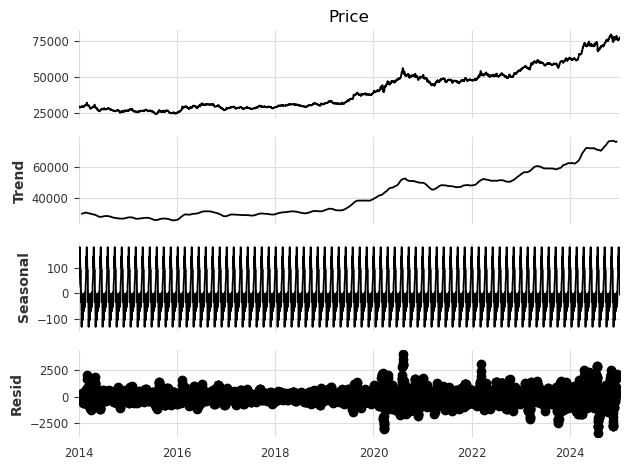

In [22]:
decompose_plot_additive = seasonal_decompose(gold_price.Price, model='additive', period=52)
decompose_plot_additive.plot()
plt.show()

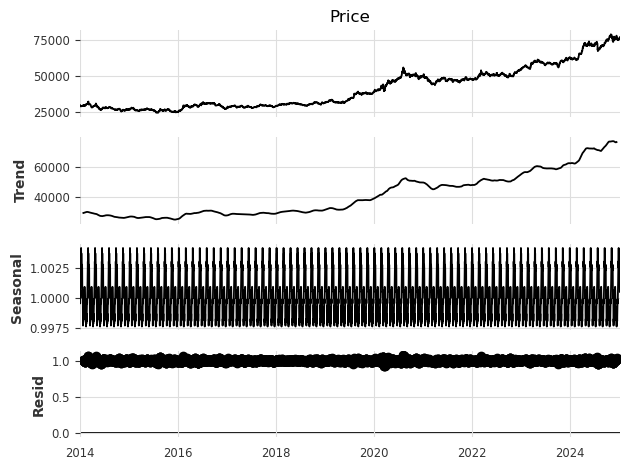

In [23]:
decompose_plot_multiplicative = seasonal_decompose(gold_price.Price, model='multiplicative', period=52)
decompose_plot_multiplicative.plot()
plt.show()

We can see that is multiplicative by the residuals, in the additive models they grow up with the time.

So, we will have to apply `log` to our serie in a future.

### Feature Engineering

In [24]:
import holidays

In [25]:
start_year = gold_price.index.min().year
end_year = gold_price.index.max().year

us_holidays = holidays.UnitedStates(years=range(start_year, end_year + 1))
uk_holidays = holidays.UnitedKingdom(years=range(start_year, end_year + 1))

combined = set(us_holidays.keys()) | set(uk_holidays.keys())

idx_dates = gold_price.index.normalize().date
gold_price["is_holiday"] = [1 if d in combined else 0 for d in idx_dates]

holiday_list = sorted(list(combined))

def days_to_next(date_val: pd.Timestamp) -> int:
    for h in holiday_list:
        if h >= date_val:
            return (h - date_val).days
    return np.nan
    
gold_price['days_to_next_holiday'] = [days_to_next(d) for d in idx_dates]

gold_price.loc[:, "is_weekend"] = (gold_price.index.weekday >= 5).astype(int)

gold_price.head(10)

Price  is_holiday  days_to_next_holiday  is_weekend
2014-01-01  29542.0           1                     0           0
2014-01-02  29975.0           0                    18           0
2014-01-03  29727.0           0                    17           0
2014-01-04  29279.0           0                    16           1
2014-01-05  29279.0           0                    15           1
2014-01-06  29119.0           0                    14           0
2014-01-07  28959.0           0                    13           0
2014-01-08  28934.0           0                    12           0
2014-01-09  28997.0           0                    11           0
2014-01-10  29169.0           0                    10           0

In [26]:
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

### Create train and test sets for time series

In [27]:
timesteps = gold_price.index.to_numpy()
price = gold_price.Price.to_numpy()

In [28]:
# Create train and test splits, 80% train, 20% test
# split_size = int(0.8 * len(price))
split_size = -127

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:2*split_size], price[:2*split_size]

# Create validation data splits (everything before the split)
X_val, y_val = timesteps[2*split_size:split_size], price[2*split_size:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], price[split_size:]

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

len(X_train), len(y_train), len(X_test), len(y_test)

(3770, 3770, 127, 127)

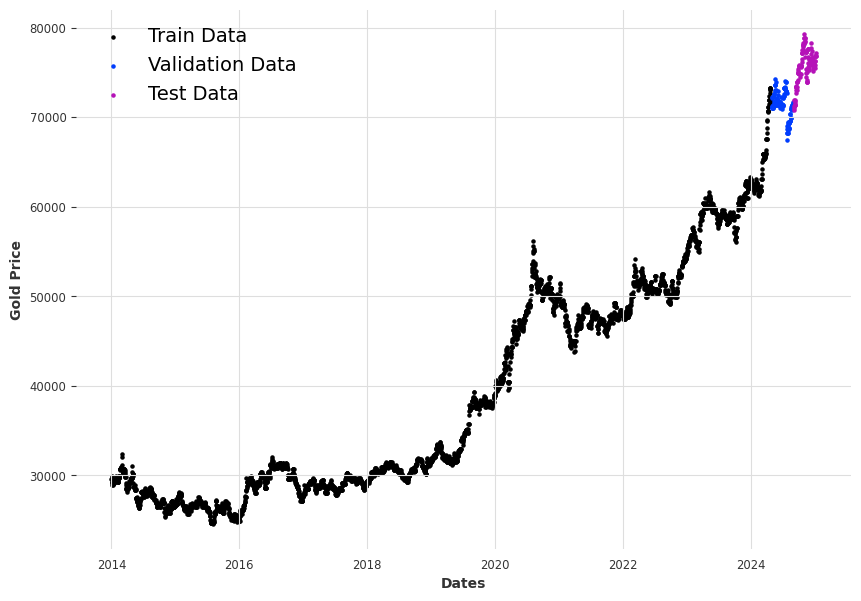

In [29]:
# Plot with train and test
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train Data')
plt.scatter(X_val, y_val, s=5, label = 'Validation Data')
plt.scatter(X_test, y_test, s=5, label='Test Data')
plt.xlabel('Dates')
plt.ylabel('Gold Price')
plt.legend(fontsize=14)
plt.show()

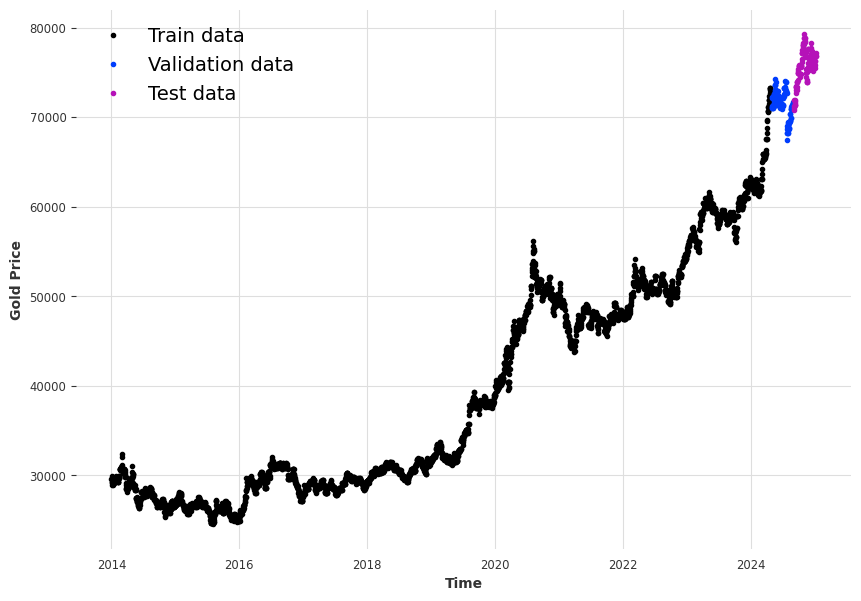

In [30]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data", xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_val, values=y_val, label="Validation data", xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_test, values=y_test, label="Test data", xlabel='Time', ylabel='Gold Price')

## Baselines Models

### Baseline 0: Naive Forecast

$$\hat{y}_{t+1} = y_t$$

In [31]:
# Create a naive forecast
naive_preds = y_test[:-1]
naive_preds[:5]

array([71233., 70807., 71053., 71890., 71409.])

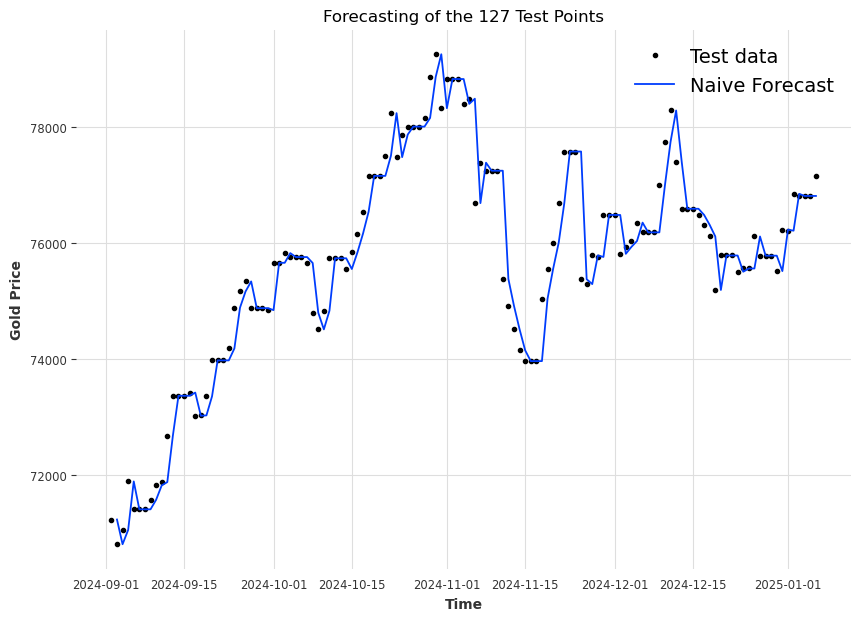

In [32]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_preds, format='-', label='Naive Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the {-split_size} Test Points')
plt.show()

In [33]:
naive_metrics = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_preds)
naive_metrics

{'mae': np.float32(329.8095),
 'mse': np.float32(263502.38),
 'rmse': np.float32(513.3248),
 'mape': np.float32(0.43505862)}

### Baseline 1: ARIMA

Bibliography: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

* **AR (Autoregression):** This emphasizes the dependent relationship between an observation and its preceding or 'lagged' observations.
* **I (Integrated):** To achieve a stationary time series, one that doesn't exhibit trend or seasonality, differencing is applied. It typically involves subtracting an observation from its preceding observation.
* **MA (Moving Average):** This component zeroes in on the relationship between an observation and the residual error from a moving average model based on lagged observations.

In [34]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot

#### Stationarity

We first need to apply logarithms to the serie, because we saw that it was a multiplicative model.

In [35]:
log_gold_price = np.log(gold_price.Price)
log_gold_price.head()

2014-01-01    10.293568
2014-01-02    10.308119
2014-01-03    10.299811
2014-01-04    10.284626
2014-01-05    10.284626
Freq: D, Name: Price, dtype: float64

In [36]:
# Check for stationarity (mean and variance constant)
adf = adfuller(log_gold_price)
print(f'ADF p-value: {adf[1]}')

ADF p-value: 0.991173454522128


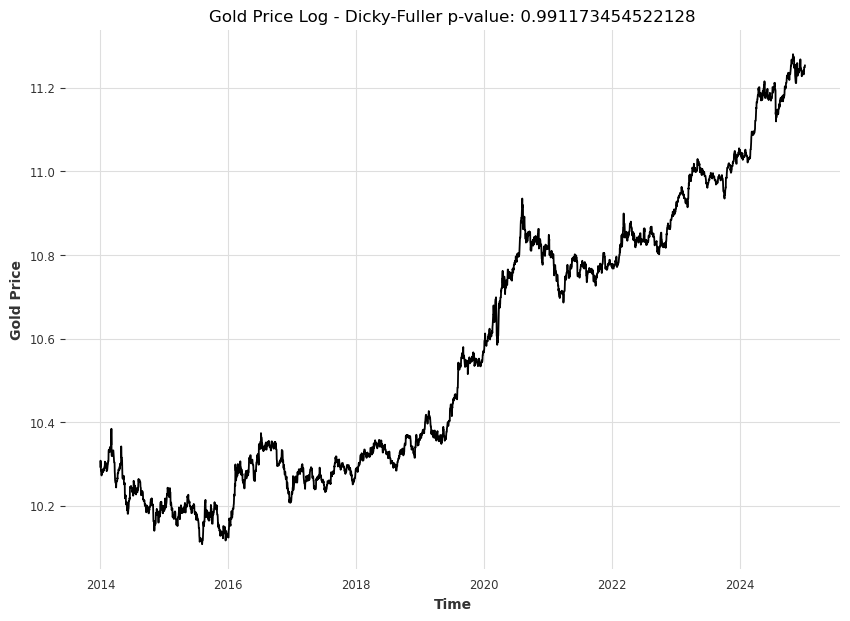

In [37]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price.index,
                 values=log_gold_price.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price')
plt.title(f'Gold Price Log - Dicky-Fuller p-value: {adf[1]}')
plt.show()

In [38]:
# We have to differentiate, because the p-value was greater than 0.05
log_gold_price_stationarity = log_gold_price.diff().dropna()
adf_diff = adfuller(log_gold_price_stationarity)
print(f'ADF p-value with 1 differentation: {adf_diff[1]}')

ADF p-value with 1 differentation: 2.846986989620009e-30


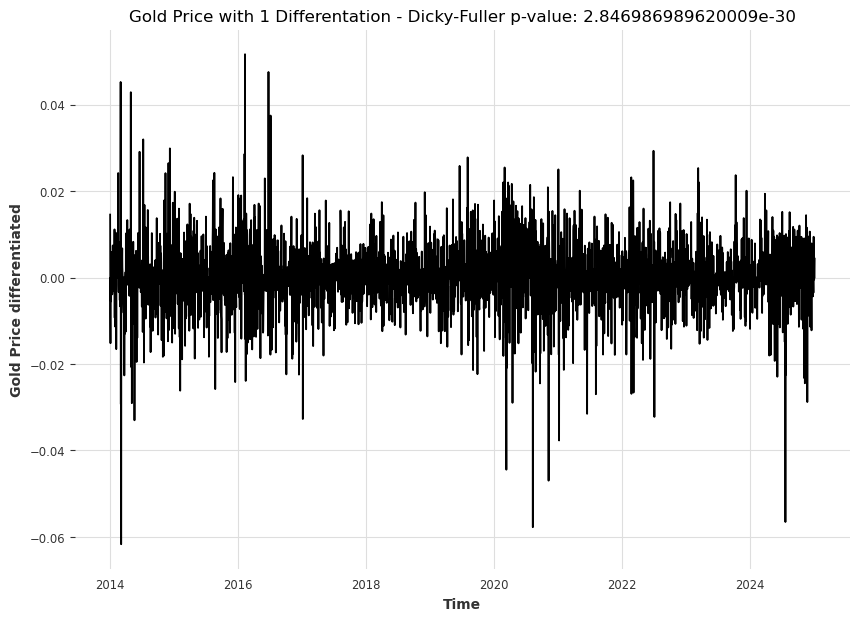

In [39]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price_stationarity.index,
                 values=log_gold_price_stationarity.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price differentiated')
plt.title(f'Gold Price with 1 Differentation - Dicky-Fuller p-value: {adf_diff[1]}')
plt.show()

#### ACF and PACF

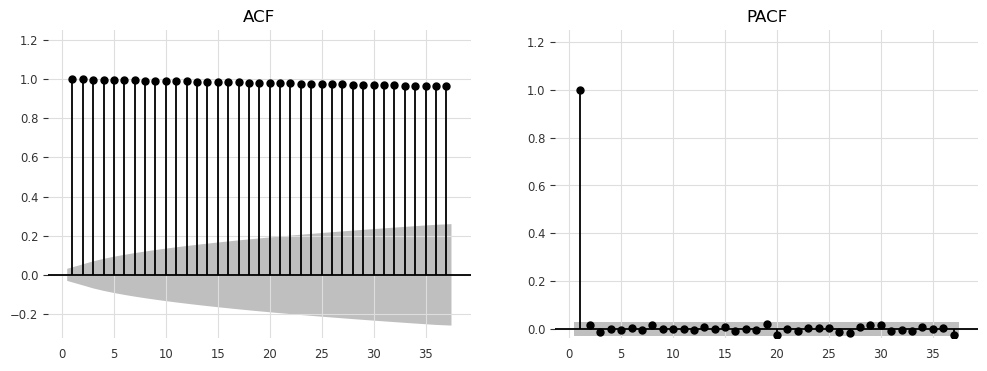

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(gold_price.Price, ax=axes[0], zero=False, auto_ylims=True, title='ACF')
plot_pacf(gold_price.Price, ax=axes[1], zero=False, auto_ylims=True, title='PACF')
plt.show()

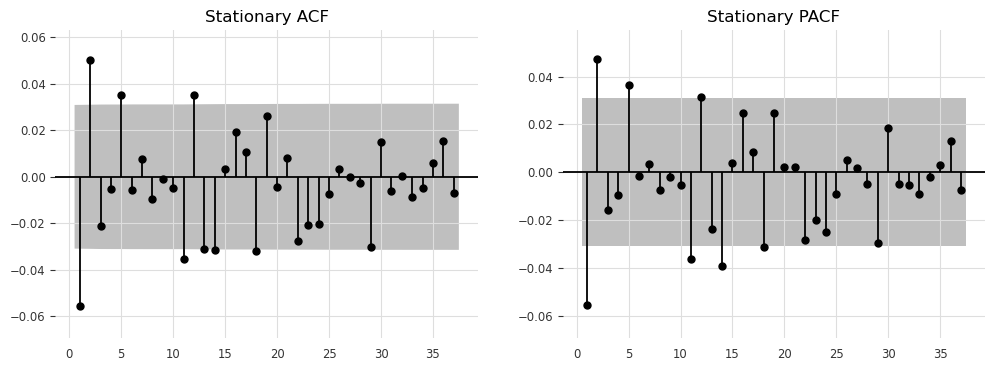

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(log_gold_price_stationarity, ax=axes[0], zero=False, auto_ylims=True, title='Stationary ACF')
plot_pacf(log_gold_price_stationarity, ax=axes[1], zero=False, auto_ylims=True, title='Stationary PACF')
plt.show()

We can try the next models:

* `ARIMA(0, 1, 0)` - **Random Walk**
* `ARIMA(1, 1, 0)`
* `ARIMA(1, 1, 1)`
* `ARIMA(1, 1, 2)`

#### Create Model

In [42]:
log_gold_price_train = pd.Series(np.log(y_train), index=pd.DatetimeIndex(X_train, freq='D'))
log_gold_price_val = pd.Series(np.log(y_val), index=pd.DatetimeIndex(X_val, freq='D'))
log_gold_price_train_val = pd.Series(np.log(y_train_val), index=pd.DatetimeIndex(X_train_val, freq='D'))
log_gold_price_test = pd.Series(np.log(y_test), index=pd.DatetimeIndex(X_test, freq='D'))

In [43]:
model_arima_010 = ARIMA(log_gold_price_train_val, order=(0, 1, 0))
model_arima_110 = ARIMA(log_gold_price_train_val, order=(1, 1, 0))
model_arima_111 = ARIMA(log_gold_price_train_val, order=(1, 1, 1))
model_arima_112 = ARIMA(log_gold_price_train_val, order=(1, 1, 2))
model_arima_212 = ARIMA(log_gold_price_train_val, order=(2, 1, 2))

results_arima_010 = model_arima_010.fit()
results_arima_110 = model_arima_110.fit()
results_arima_111 = model_arima_111.fit()
results_arima_112 = model_arima_112.fit()
results_arima_212 = model_arima_212.fit()

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [44]:
results_arima_010.aic, results_arima_110.aic, results_arima_111.aic, results_arima_112.aic, results_arima_212.aic

(np.float64(-27602.91175301103),
 np.float64(-27614.30278101276),
 np.float64(-27616.859069139005),
 np.float64(-27619.64162493645),
 np.float64(-27621.049219698027))

The best ARIMA model looking at the AIC metric is: `ARIMA(1, 1, 2)`.

#### Make Predictions

Now, we will make the predictions using the **walk-forward** technique.

In [45]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [46]:
history = list(log_gold_price_train_val)
arima_preds = []
for obs in log_gold_price_test:
    model = ARIMA(history, order=(1, 1, 2))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        results = model.fit()
    log_pred = results.forecast()[0]
    arima_preds.append(np.exp(log_pred))
    history.append(obs) # take in the real observation

#### Evaluate Predicts

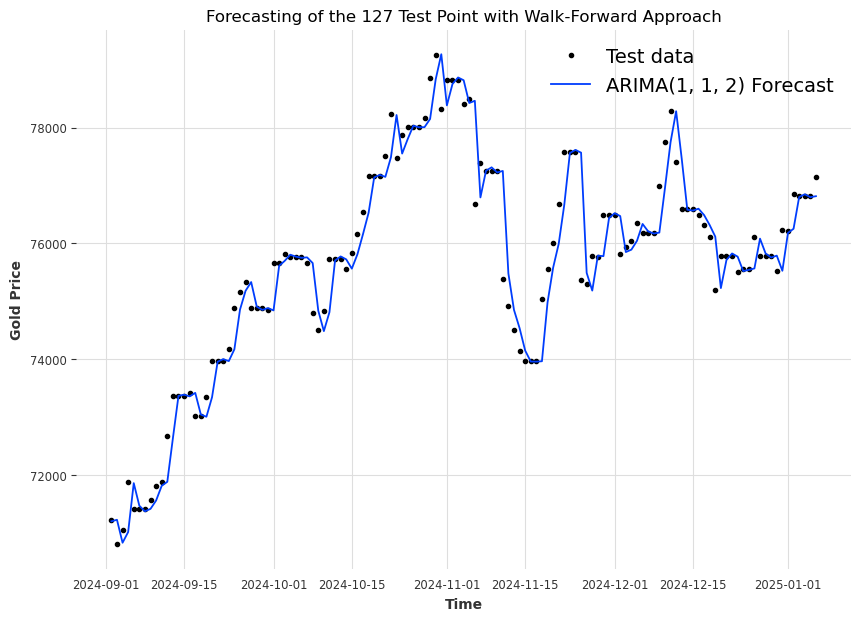

In [47]:
# Plot ARIMA(1, 1, 2) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test, values=arima_preds, format='-', label='ARIMA(1, 1, 2) Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the {-split_size} Test Point with Walk-Forward Approach')
plt.show()

In [48]:
arima_metrics = evaluate_preds(y_true=y_test,
                               y_pred=arima_preds)
arima_metrics

{'mae': np.float32(336.70154),
 'mse': np.float32(263243.75),
 'rmse': np.float32(513.0729),
 'mape': np.float32(0.44425094)}

In [49]:
log_pred_arima_direct = results_arima_112.get_forecast(steps=-split_size)
pred_arima_direct = np.exp(log_pred_arima_direct.predicted_mean).values
arima_direct_metrics = evaluate_preds(y_true=y_test, y_pred=pred_arima_direct)
arima_direct_metrics

{'mae': np.float32(4495.7456),
 'mse': np.float32(23590336.0),
 'rmse': np.float32(4856.9883),
 'mape': np.float32(5.882806)}

### Baseline 2: SARIMAX

Our TS is anual stational, so we would need to look at the lags 365, 730 and so on, if we want to know the parameters P and Q of the model ``SARIMAX(p, d, q)x(P, D, Q, m)``. Therefore, we will use grid search to compute the best parameters. We will try the next models:

* ``SARIMAX(0, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 2, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 2, 365)``

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Exogenus variables

First of all, we have to load, clean, transform and put all the exogenus variables into the `gold_price` dataframe.

In [51]:
from utils.load import load_csv_into_dates, load_csv_and_glue_time_series

In [52]:
folder_exogenus_gold_variables = os.path.join(os.getcwd(), '..', 'data', 'exogenus_gold')

##### BRENT

In [53]:
brent = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'brent', 'brent-daily.csv'))
brent.index.min(), brent.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

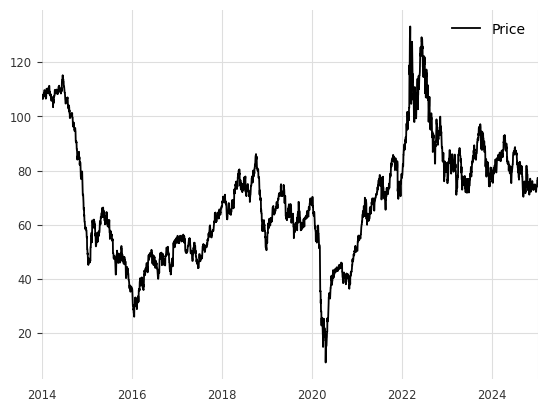

In [54]:
brent.plot()

##### WTI

In [55]:
wti = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'wti', 'wti-daily.csv'))
wti.index.min(), wti.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [56]:
wti[wti.values < 0]

Price
2020-04-18 -36.98
2020-04-19 -36.98
2020-04-20 -36.98

<Axes: >

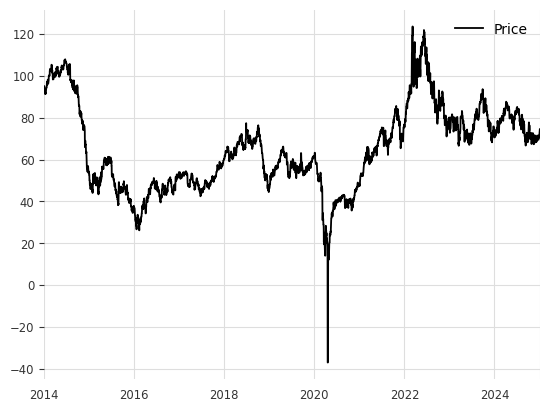

In [57]:
wti.plot()

##### DXY - Dollar Index

In [58]:
folder_dxy = os.path.join(folder_exogenus_gold_variables, 'DXY')
dxy = load_csv_and_glue_time_series(folder_path=folder_dxy, column_name='Open')
dxy.index.min(), dxy.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

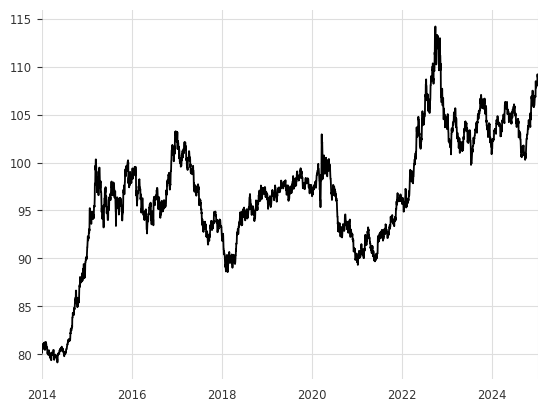

In [59]:
dxy.plot()

##### EURUSD

In [60]:
eurusd = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'EURUSD', 'EURUSD_D1.csv'), header=None)
eurusd = eurusd.iloc[:, 0]
eurusd.index.min(), eurusd.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

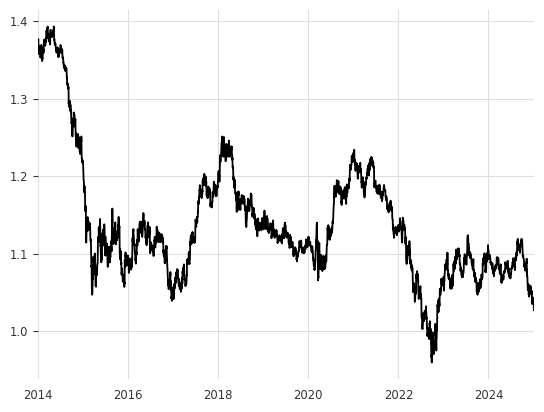

In [61]:
eurusd.plot()

##### VIX

In [62]:
vix = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'VIX', 'VIX_history.csv'),
                          column_name='OPEN')
vix.index.min(), vix.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

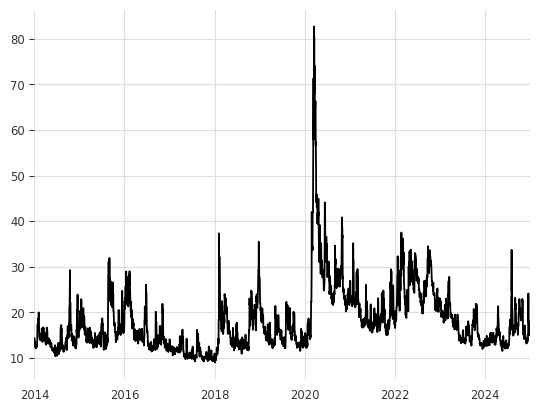

In [63]:
vix.plot()

##### S&P 500

In [64]:
sp500 = load_csv_and_glue_time_series(folder_path=os.path.join(folder_exogenus_gold_variables, 'SP500'),
                                      column_name='Open')
sp500.index.min(), sp500.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

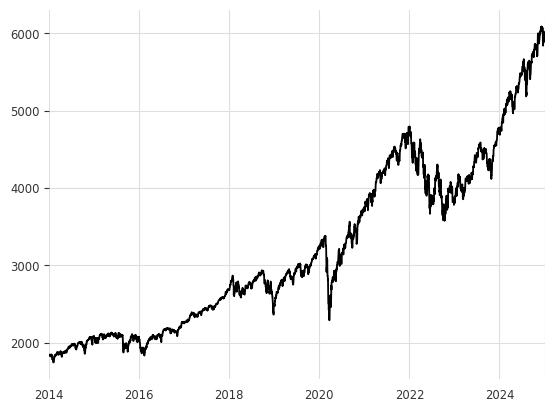

In [65]:
sp500.plot()

##### T5YIE

In [66]:
t5yie = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'T5YIE', 'T5YIE.csv'),
                            column_name='Open')
fecha_01_01_2014 = t5yie.index[0] - pd.Timedelta(days=1)
valor_01_01_2014 = t5yie.iloc[0]
t5yie = pd.concat([
    pd.Series([valor_01_01_2014], index=[fecha_01_01_2014]),
    t5yie
])
t5yie.index.min(), t5yie.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

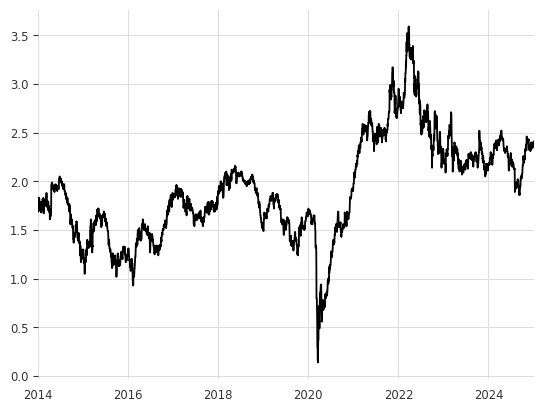

In [67]:
t5yie.plot()

##### T10YIE

In [68]:
t10yie = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'T10YIE', 'T10YIE.csv'),
                            column_name='Open')
fecha_01_01_2014 = t10yie.index[0] - pd.Timedelta(days=1)
valor_01_01_2014 = t10yie.iloc[0]
t10yie = pd.concat([
    pd.Series([valor_01_01_2014], index=[fecha_01_01_2014]),
    t10yie
])
t10yie.index.min(), t10yie.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

<Axes: >

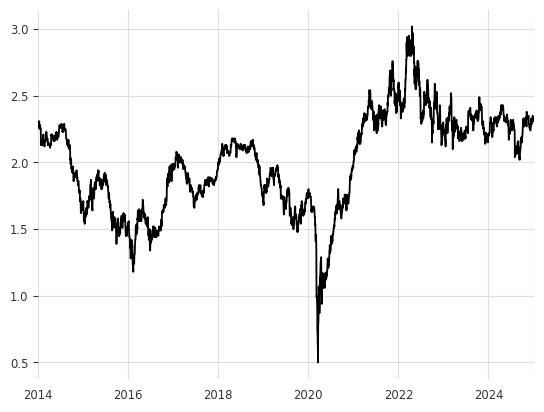

In [69]:
t10yie.plot()

#### Preparing data with Exogenus Variables

In [70]:
gold_price['brent'] = brent
gold_price['wti'] = wti
gold_price['dxy'] = dxy
gold_price['vix'] = vix
gold_price['eurusd'] = eurusd
gold_price['sp500'] = sp500
gold_price['t5yie'] = t5yie
gold_price.head()

Price  is_holiday  days_to_next_holiday  is_weekend   brent  \
2014-01-01  29542.0           1                     0           0  107.94   
2014-01-02  29975.0           0                    18           0  107.94   
2014-01-03  29727.0           0                    17           0  106.57   
2014-01-04  29279.0           0                    16           1  106.71   
2014-01-05  29279.0           0                    15           1  106.71   

              wti    dxy    vix   eurusd        sp500  t5yie  
2014-01-01  95.14  80.21  14.32  1.37553  1845.859985   1.71  
2014-01-02  95.14  80.12  14.32  1.37653  1845.859985   1.71  
2014-01-03  93.66  80.57  14.06  1.36653  1833.209961   1.69  
2014-01-04  93.12  80.86  13.41  1.35935  1832.310059   1.75  
2014-01-05  93.12  80.86  13.41  1.35935  1832.310059   1.75

We need to separate our exogenus variables from our raw gold_price dataframe. Furthermore, we will need also to split in train and test this new dataset.

In [71]:
exog_data = gold_price.reset_index().drop(columns=['index', 'Price'])
exog_data.head()

is_holiday  days_to_next_holiday  is_weekend   brent    wti    dxy    vix  \
0           1                     0           0  107.94  95.14  80.21  14.32   
1           0                    18           0  107.94  95.14  80.12  14.32   
2           0                    17           0  106.57  93.66  80.57  14.06   
3           0                    16           1  106.71  93.12  80.86  13.41   
4           0                    15           1  106.71  93.12  80.86  13.41   

    eurusd        sp500  t5yie  
0  1.37553  1845.859985   1.71  
1  1.37653  1845.859985   1.71  
2  1.36653  1833.209961   1.69  
3  1.35935  1832.310059   1.75  
4  1.35935  1832.310059   1.75

In [72]:
exog_train = exog_data.iloc[:2*split_size, :]
exog_val = exog_data.iloc[2*split_size:split_size, :]
exog_train_val = pd.concat([exog_train, exog_val])
exog_test = exog_data.iloc[split_size:, :]

exog_train.shape, exog_val.shape, exog_train_val.shape, exog_test.shape

((3770, 10), (127, 10), (3897, 10), (127, 10))

We also need to transform our 'anual seasonality' in terms of **Fourier** for agilize the computation, and get rid of the seasonality in SARIMAX.

In [73]:
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima

In [74]:
fourier_gen = FourierFeaturizer(m=365.25, k=4)
log_gold_price_fourier, exog_data_fourier = fourier_gen.fit_transform(log_gold_price.values, exog_data)

exog_train_fourier = exog_data_fourier.iloc[:2*split_size, :]
exog_val_fourier = exog_data_fourier.iloc[2*split_size:split_size, :]
exog_train_val_fourier = pd.concat([exog_train_fourier, exog_val_fourier])
exog_test_fourier = exog_data_fourier.iloc[split_size:, :]

exog_train_fourier.shape, exog_val_fourier.shape, exog_train_val_fourier.shape, exog_test_fourier.shape

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



((3770, 18), (127, 18), (3897, 18), (127, 18))

#### Create Model

In [75]:
# Exogenus without Fourier and without seasonality

model_sarimax_010_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_110_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_111_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_sarimax_112_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0))
model_sarimax_212_000_365 = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))

results_sarimax_010_000_365 = model_sarimax_010_000_365.fit()
results_sarimax_110_000_365 = model_sarimax_110_000_365.fit()
results_sarimax_111_000_365 = model_sarimax_111_000_365.fit()
results_sarimax_112_000_365 = model_sarimax_112_000_365.fit()
results_sarimax_212_000_365 = model_sarimax_212_000_365.fit()

results_sarimax_010_000_365.aic, results_sarimax_110_000_365.aic, results_sarimax_111_000_365.aic, results_sarimax_112_000_365.aic, results_sarimax_212_000_365.aic

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



(np.float64(-27625.232301729488),
 np.float64(-27644.28353556103),
 np.float64(-27646.169811025487),
 np.float64(-27646.95645788657),
 np.float64(-27618.60645484017))

In [76]:
# Exogenus without Fourier, but with seasonality

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore", category=FutureWarning)
    model_sarimax_auto = auto_arima(
        y=log_gold_price_train_val,
        exogenus=exog_train_val,
        seasonal=True,
        m=52,
        stepwise=True,
        suppress_warnings=True,
        trace=False
    )

model_sarimax_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3897
Model:               SARIMAX(2, 1, 2)   Log Likelihood               13817.793
Date:                Tue, 30 Sep 2025   AIC                         -27623.586
Time:                        13:56:13   BIC                         -27585.980
Sample:                    01-01-2014   HQIC                        -27610.238
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.000      2.043      0.041    2.63e-05       0.001
ar.L1         -1.1974      0.151     -7.934      0.000      -1.493      -0.902
ar.L2         -0.6551      0.106     -6.195      0.000      -0.862      -0.448
ma.L1          1.1408      0.149      7.655      0.000       0.849       1.433
ma.L2          0.6401      0.100      6.382      0.000       0.444       0.837
sigma2      4.863e-05   4.97e-07     97.858      0.000    4.77e-05    4.96e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13143.77
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
# Exogenus with Fourier

model_sarimax_010_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_110_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_111_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_sarimax_112_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0))
model_sarimax_212_000_fourier = SARIMAX(log_gold_price_train_val.values,
                                    exog=exog_train_val_fourier, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))

results_sarimax_010_000_fourier = model_sarimax_010_000_fourier.fit()
results_sarimax_110_000_fourier = model_sarimax_110_000_fourier.fit()
results_sarimax_111_000_fourier = model_sarimax_111_000_fourier.fit()
results_sarimax_112_000_fourier = model_sarimax_112_000_fourier.fit()
results_sarimax_212_000_fourier = model_sarimax_212_000_fourier.fit()

results_sarimax_010_000_fourier.aic, results_sarimax_110_000_fourier.aic, results_sarimax_111_000_fourier.aic, results_sarimax_112_000_fourier.aic, results_sarimax_212_000_fourier.aic

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.

(np.float64(-27618.495853166234),
 np.float64(-27639.184343111738),
 np.float64(-27640.776539782928),
 np.float64(-27640.585254638434),
 np.float64(-27612.15922215819))

The model with lowest AIC is `SARIMAX(1, 1, 2)x(0, 0, 0, 0)` without seasonality nor Fourier's features.

#### Make Predictions

In [78]:
history = list(log_gold_price_train_val.values)
sarimax_preds = []

for i in range(len(log_gold_price_test)):

    model = SARIMAX(
        endog=history,
        exog=exog_data.iloc[:len(history)],
        order=(1, 1, 2),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        results = model.fit(disp=False)

    log_pred = results.forecast(steps=1, exog=exog_test.iloc[i:i+1])
    sarimax_preds.append(np.exp(log_pred))

    history.append(log_gold_price_test.values[i])

#### Evaluate Predicts

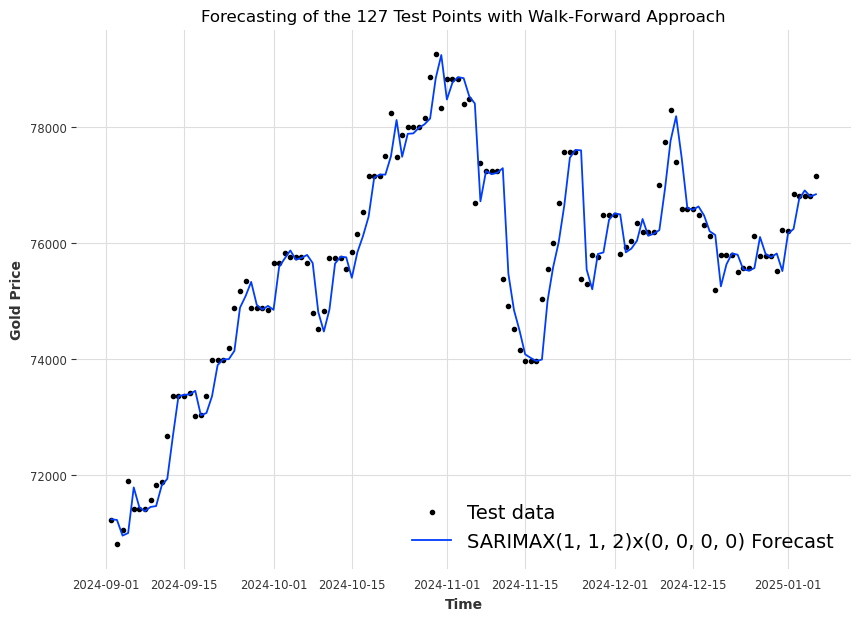

In [79]:
# Plot SARIMAX(1, 1, 2) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test, values=sarimax_preds, format='-', label='SARIMAX(1, 1, 2)x(0, 0, 0, 0) Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the {-split_size} Test Points with Walk-Forward Approach')
plt.show()

In [80]:
sarimax_metrics = evaluate_preds(y_true=y_test,
                                 y_pred=sarimax_preds)
sarimax_metrics

{'mae': np.float32(2067.5217),
 'mse': np.float32(7036406.5),
 'rmse': np.float32(2652.6226),
 'mape': np.float32(2.7454643)}

In [81]:
log_pred_sarimax_direct = results_sarimax_112_000_365.get_forecast(steps=-split_size, exog=exog_test)
pred_sarimax_direct = np.exp(log_pred_sarimax_direct.predicted_mean).values
sarimax_direct_metrics = evaluate_preds(y_true=y_test, y_pred=pred_sarimax_direct)
sarimax_direct_metrics

{'mae': np.float32(4640.455),
 'mse': np.float32(25239028.0),
 'rmse': np.float32(5023.8457),
 'mape': np.float32(6.071576)}

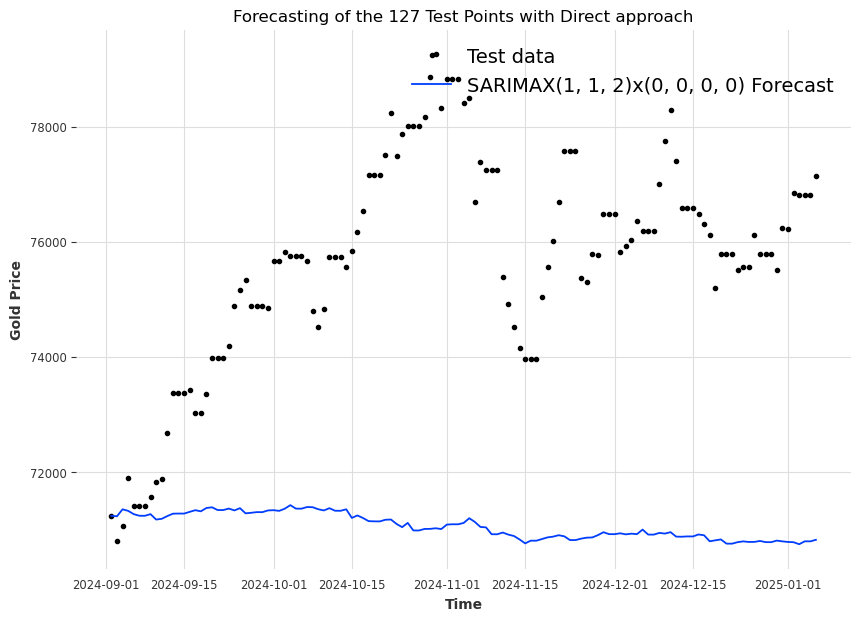

In [82]:
# Plot SARIMAX(1, 1, 2) forecast direct
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test, values=pred_sarimax_direct, format='-', label='SARIMAX(1, 1, 2)x(0, 0, 0, 0) Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the {-split_size} Test Points with Direct approach')
plt.show()

### Final Results for Baseline Models

| Metrics / Baselines | Naive | ARIMA | SARIMAX |
|----------------|-----------|-----------|-----------|
| MAE  | 288.35  | 288.72  | 697.02  |
| MSE  | 174403.08  | 178845.33  | 818114.06  |
| RMSE  | 422.90  | 417.62  | 861.11  |
| MAPE  | 0.38  | 0.38  | 0.91  |


## Main Models

### Make Windows

First of all, we need to transform our Forecasting Time Series problem in a Supervised Prediction problem. So, the technique that we are going to use is make windows (we will try differnt window's sizes), and use this windows like a features where our model is trained on, and the last element will be the `y` that we are trying to predict.

In [83]:
from utils.windows import make_windows

In [84]:
WINDOW_SIZE = 30
HORIZON = 1

We have to include the exogenus variables into the window-format.

In [85]:
index = pd.date_range(start='2014-01-01', periods=len(gold_price)-1, freq='D')[WINDOW_SIZE-1:]
first_iter = True
for var in gold_price.columns.values:
    columns_var = [f'{var}_{i+1}' for i in range(WINDOW_SIZE)]
    if var == 'Price':
        full_windows, full_labels = make_windows(gold_price[var], window_size=WINDOW_SIZE, horizon=HORIZON)
    else:
        full_windows, _ = make_windows(gold_price[var], window_size=WINDOW_SIZE, horizon=HORIZON)
    if first_iter:
        df = pd.DataFrame(full_windows, columns=columns_var, index=index)
        first_iter = False
        continue
    df2 = pd.DataFrame(full_windows, columns=columns_var, index=index)
    df = pd.concat([df, df2], axis=1)

In [86]:
gold_price_windowed = df.copy()
gold_price_windowed.head()

Price_1  Price_2  Price_3  Price_4  Price_5  Price_6  Price_7  \
2014-01-30  29542.0  29975.0  29727.0  29279.0  29279.0  29119.0  28959.0   
2014-01-31  29975.0  29727.0  29279.0  29279.0  29119.0  28959.0  28934.0   
2014-02-01  29727.0  29279.0  29279.0  29119.0  28959.0  28934.0  28997.0   
2014-02-02  29279.0  29279.0  29119.0  28959.0  28934.0  28997.0  29169.0   
2014-02-03  29279.0  29119.0  28959.0  28934.0  28997.0  29169.0  29169.0   

            Price_8  Price_9  Price_10  ...  t5yie_21  t5yie_22  t5yie_23  \
2014-01-30  28934.0  28997.0   29169.0  ...      1.71      1.79      1.72   
2014-01-31  28997.0  29169.0   29169.0  ...      1.79      1.72      1.68   
2014-02-01  29169.0  29169.0   29169.0  ...      1.72      1.68      1.72   
2014-02-02  29169.0  29169.0   29312.0  ...      1.68      1.72      1.72   
2014-02-03  29169.0  29312.0   29198.0  ...      1.72      1.72      1.72   

            t5yie_24  t5yie_25  t5yie_26  t5yie_27  t5yie_28  t5yie_29  \
2014-01-30      1.68      1.72      1.72      1.72      1.71      1.72   
2014-01-31      1.72      1.72      1.72      1.71      1.72      1.76   
2014-02-01      1.72      1.72      1.71      1.72      1.76      1.72   
2014-02-02      1.72      1.71      1.72      1.76      1.72      1.70   
2014-02-03      1.71      1.72      1.76      1.72      1.70      1.70   

            t5yie_30  
2014-01-30      1.76  
2014-01-31      1.72  
2014-02-01      1.70  
2014-02-02      1.70  
2014-02-03      1.70  

[5 rows x 330 columns]

Before continuing, we have to remove all calendar variables from 1 to 29, and only stay with the 30th.

In [87]:
calendar_vars = ["is_weekend", "is_holiday", "days_to_next_holiday"]
keep_cols = []
for var in calendar_vars:
    keep_cols.append(f"{var}_{WINDOW_SIZE}")

for col in gold_price_windowed.columns:
    if not any(col.startswith(var) for var in calendar_vars):
        keep_cols.append(col)

gold_price_windowed = gold_price_windowed[keep_cols]
len(gold_price_windowed.columns.values)

243

In [88]:
# Turning windows into training and tests sets
train_gold_price_windowed = gold_price_windowed[:2*split_size]
val_gold_price_windowed = gold_price_windowed[2*split_size:split_size]
test_gold_price_windowed = gold_price_windowed[split_size:]

train_labels = full_labels[:2*split_size]
val_labels = full_labels[2*split_size:split_size]
test_labels = full_labels[split_size:]

len(train_gold_price_windowed), len(val_gold_price_windowed), len(test_gold_price_windowed), len(train_labels), len(val_labels), len(test_labels)

(3740, 127, 127, 3740, 127, 127)

In [89]:
train_val_gold_price_windowed = pd.concat([train_gold_price_windowed, val_gold_price_windowed])
train_val_labels = np.concatenate((train_labels, val_labels))

### LightGBM

In [90]:
import lightgbm as lgb

In [91]:
df_models_metrics_lightgbm = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [92]:
model_lightgbm_default = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=0,
    reg_alpha=0,
    random_state=42,
    verbose=-1
)

model_lightgbm_default.name = "Default Model"

model_lightgbm_default.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse')

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



LGBMRegressor(colsample_bytree=1, min_split_gain=0, objective='regression',
              random_state=42, reg_alpha=0, reg_lambda=0, subsample=1,
              verbose=-1)

##### Make Predictions

In [93]:
pred_lightgbm_default = model_lightgbm_default.predict(val_gold_price_windowed)
pred_train_lightgbm_default = model_lightgbm_default.predict(train_gold_price_windowed[-200:])

##### Evaluate Predictions

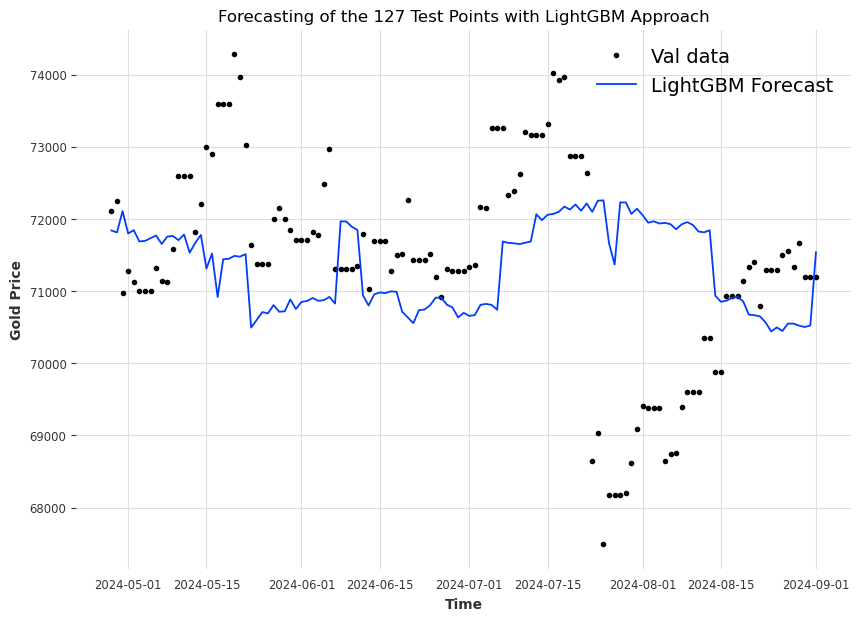

In [94]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm_default, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [95]:
lightgbm_metrics_default = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm_default)
lightgbm_metrics_default

{'mae': np.float32(1283.7336),
 'mse': np.float32(2625386.2),
 'rmse': np.float32(1620.3043),
 'mape': np.float32(1.810699)}

##### Evaluate Overfitting

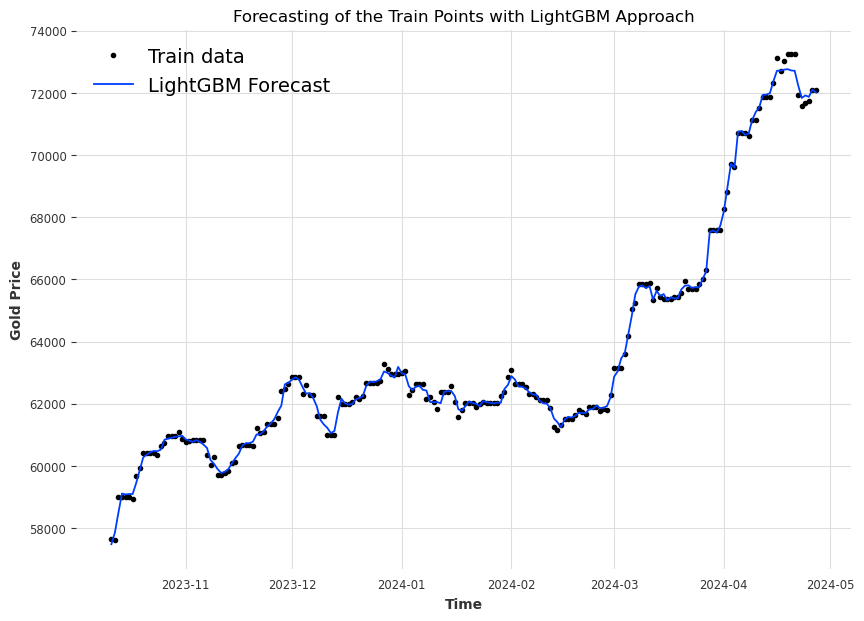

In [96]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=pred_train_lightgbm_default, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [97]:
lightgbm_metrics_train_default = evaluate_preds(y_true=y_train[-200:],
                                        y_pred=pred_train_lightgbm_default)
lightgbm_metrics_train_default

{'mae': np.float32(115.358284),
 'mse': np.float32(24788.42),
 'rmse': np.float32(157.44339),
 'mape': np.float32(0.18102573)}

##### Persist Metrics

In [98]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm_default.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train_default['mape'],
        "Val MAPE": lightgbm_metrics_default['mape'],
        "Train RMSE": lightgbm_metrics_train_default['rmse'],
        "Val RMSE": lightgbm_metrics_default['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11352\2008271142.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [99]:
model_lightgbm_small = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=50,
    learning_rate=0.2,
    num_leaves=21,
    max_depth=4,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=30,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=0,
    reg_alpha=0,
    random_state=42,
    verbose=-1
)

model_lightgbm_small.name = 'Small Model'

model_lightgbm_small.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse')

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



LGBMRegressor(colsample_bytree=1, learning_rate=0.2, max_depth=4,
              min_child_samples=30, min_split_gain=0, n_estimators=50,
              num_leaves=21, objective='regression', random_state=42,
              reg_alpha=0, reg_lambda=0, subsample=1, verbose=-1)

##### Make Predictions

In [100]:
pred_lightgbm_small = model_lightgbm_small.predict(val_gold_price_windowed)
pred_train_lightgbm_small = model_lightgbm_small.predict(train_gold_price_windowed[-200:])

##### Evaluate Predictions

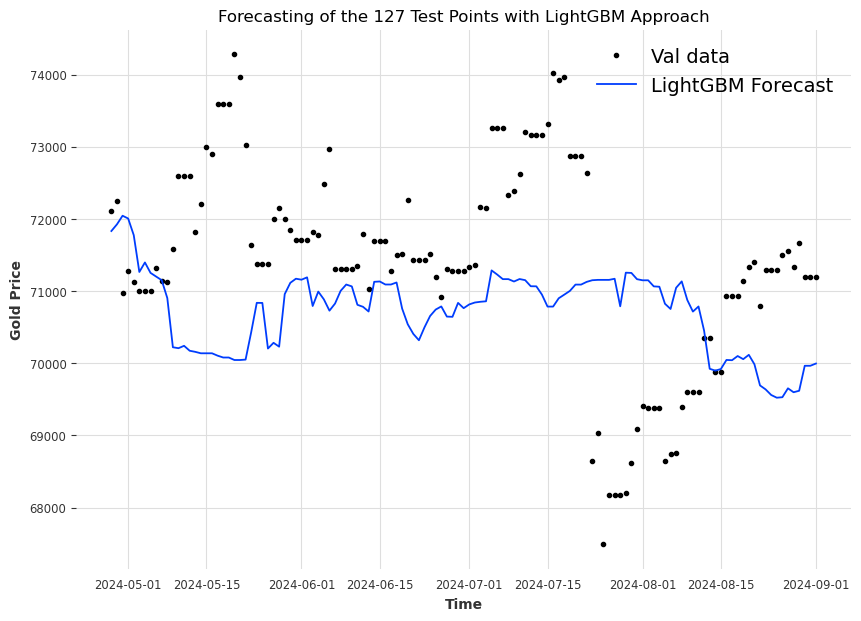

In [101]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm_small, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [102]:
lightgbm_metrics_small = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm_small)
lightgbm_metrics_small

{'mae': np.float32(1443.1083),
 'mse': np.float32(3014293.5),
 'rmse': np.float32(1736.1721),
 'mape': np.float32(2.0175908)}

##### Evaluate Overfitting

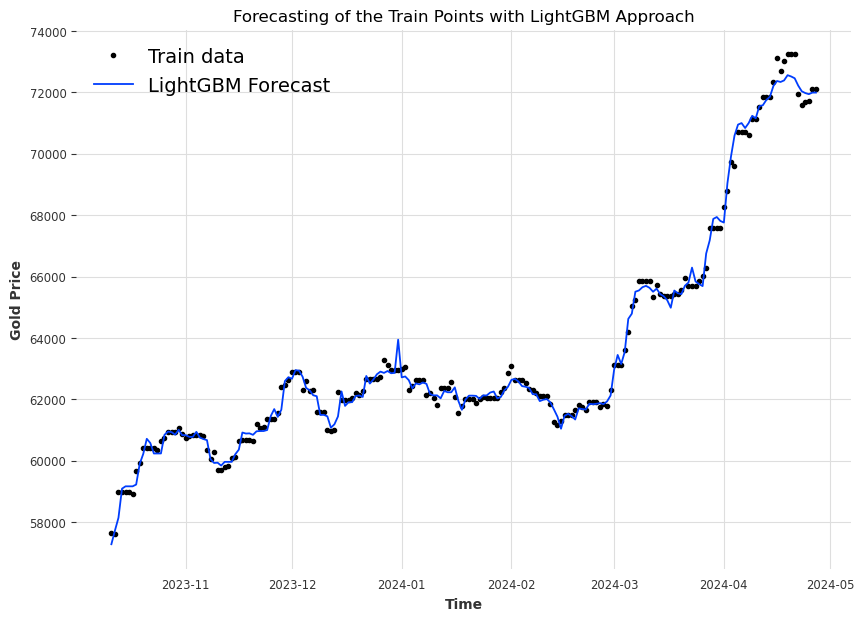

In [103]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=pred_train_lightgbm_small, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [104]:
lightgbm_metrics_train_small = evaluate_preds(y_true=y_train[-200:],
                                        y_pred=pred_train_lightgbm_small)
lightgbm_metrics_train_small

{'mae': np.float32(207.64435),
 'mse': np.float32(77125.24),
 'rmse': np.float32(277.71432),
 'mape': np.float32(0.3237158)}

##### Persist Metrics

In [105]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm_small.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train_small['mape'],
        "Val MAPE": lightgbm_metrics_small['mape'],
        "Train RMSE": lightgbm_metrics_train_small['rmse'],
        "Val RMSE": lightgbm_metrics_small['rmse']
    }])
], ignore_index=True)

#### Regularized Model

##### Create Model

In [106]:
model_lightgbm_regularized = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=0.1,
    random_state=42,
    verbose=-1
)

model_lightgbm_regularized.name = "Regularized Model"

model_lightgbm_regularized.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse')

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



LGBMRegressor(colsample_bytree=0.8, min_split_gain=0, objective='regression',
              random_state=42, reg_alpha=0.1, reg_lambda=1, subsample=0.8,
              verbose=-1)

##### Make Predictions

In [107]:
pred_lightgbm_regularized = model_lightgbm_regularized.predict(val_gold_price_windowed)
pred_train_lightgbm_regularized = model_lightgbm_regularized.predict(train_gold_price_windowed[-200:])

##### Evaluate Predictions

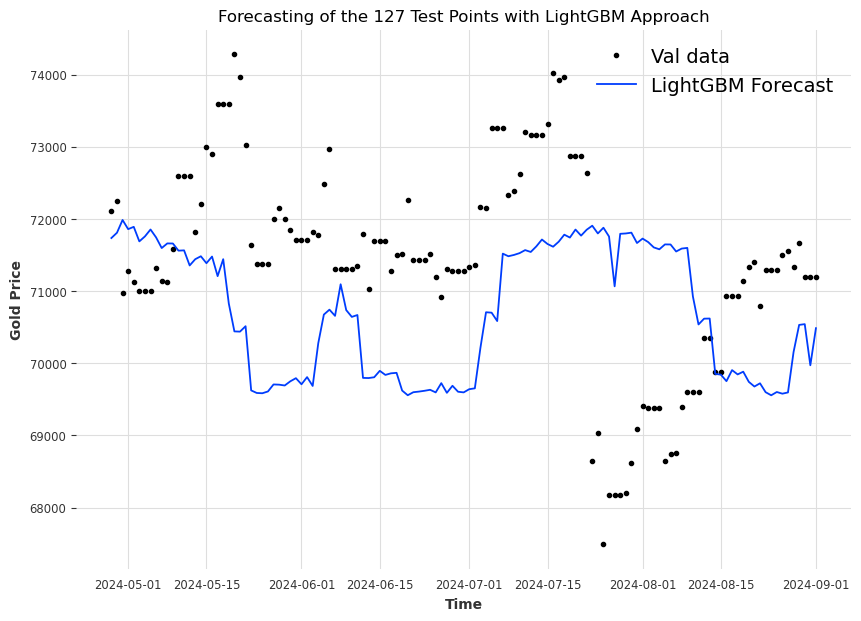

In [108]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm_regularized, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [109]:
lightgbm_metrics_regularized = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm_regularized)
lightgbm_metrics_regularized

{'mae': np.float32(1657.3236),
 'mse': np.float32(3489639.8),
 'rmse': np.float32(1868.0577),
 'mape': np.float32(2.32679)}

##### Evaluate Overfitting

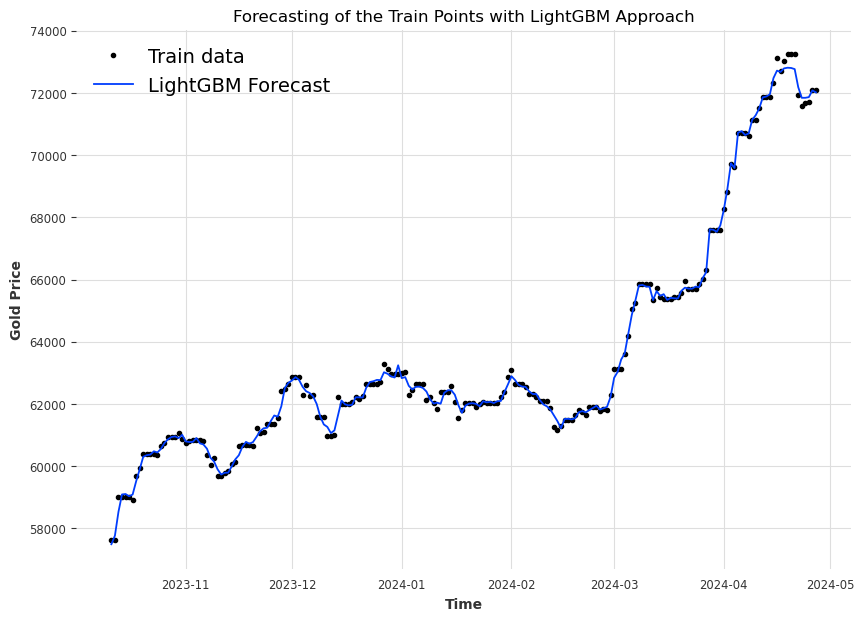

In [110]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=pred_train_lightgbm_regularized, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [111]:
lightgbm_metrics_train_regularized = evaluate_preds(y_true=y_train[-200:],
                                        y_pred=pred_train_lightgbm_regularized)
lightgbm_metrics_train_regularized

{'mae': np.float32(111.920876),
 'mse': np.float32(24491.46),
 'rmse': np.float32(156.49748),
 'mape': np.float32(0.17627949)}

##### Persist Metrics

In [112]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm_regularized.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train_regularized['mape'],
        "Val MAPE": lightgbm_metrics_regularized['mape'],
        "Train RMSE": lightgbm_metrics_train_regularized['rmse'],
        "Val RMSE": lightgbm_metrics_regularized['rmse']
    }])
], ignore_index=True)

#### Early Stopping Model

##### Create Model

In [113]:
model_lightgbm_es = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=-1,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=0,
    reg_alpha=0,
    random_state=42,
    verbose=-1
)

model_lightgbm_es.name = 'Early Stopping Model'

evals_result_lightgbm = {}

model_lightgbm_es.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse',
                   callbacks=[
                       lgb.early_stopping(stopping_rounds=80),
                       lgb.log_evaluation(period=50),
                       lgb.record_evaluation(eval_result=evals_result_lightgbm)
                    ]
                )

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



Training until validation scores don't improve for 80 rounds
[50]	valid_0's rmse: 19642.6	valid_0's l2: 3.85831e+08
[100]	valid_0's rmse: 12245.3	valid_0's l2: 1.49947e+08
[150]	valid_0's rmse: 7763.62	valid_0's l2: 6.02738e+07
[200]	valid_0's rmse: 5085.4	valid_0's l2: 2.58613e+07
[250]	valid_0's rmse: 3458.1	valid_0's l2: 1.19584e+07
[300]	valid_0's rmse: 2528.48	valid_0's l2: 6.39323e+06
[350]	valid_0's rmse: 2015.58	valid_0's l2: 4.06257e+06
[400]	valid_0's rmse: 1771.22	valid_0's l2: 3.13722e+06
[450]	valid_0's rmse: 1651.42	valid_0's l2: 2.7272e+06
[500]	valid_0's rmse: 1598.44	valid_0's l2: 2.55503e+06
[550]	valid_0's rmse: 1579.68	valid_0's l2: 2.4954e+06
[600]	valid_0's rmse: 1563.93	valid_0's l2: 2.44589e+06
[650]	valid_0's rmse: 1555.67	valid_0's l2: 2.42011e+06
[700]	valid_0's rmse: 1558	valid_0's l2: 2.42737e+06
Early stopping, best iteration is:
[663]	valid_0's rmse: 1555.15	valid_0's l2: 2.41849e+06


LGBMRegressor(colsample_bytree=1, learning_rate=0.01, min_split_gain=0,
              n_estimators=1000, objective='regression', random_state=42,
              reg_alpha=0, reg_lambda=0, subsample=1, verbose=-1)

##### Make Predictions

In [114]:
pred_lightgbm_es = model_lightgbm_es.predict(val_gold_price_windowed)
pred_train_lightgbm_es = model_lightgbm_es.predict(train_gold_price_windowed[-200:])

##### Evaluate Predictions

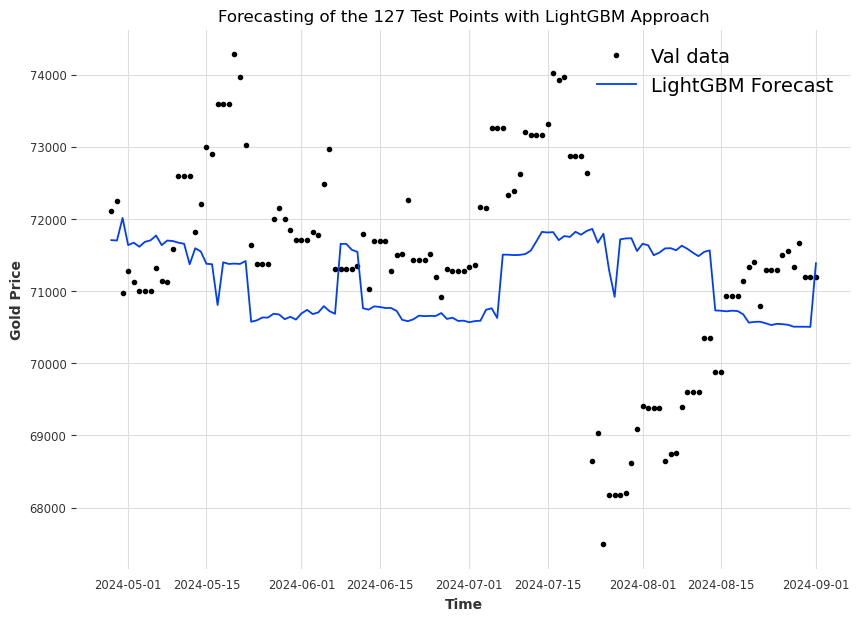

In [115]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm_es, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [116]:
lightgbm_metrics_es = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm_es)
lightgbm_metrics_es

{'mae': np.float32(1289.6598),
 'mse': np.float32(2418492.0),
 'rmse': np.float32(1555.1501),
 'mape': np.float32(1.8138772)}

##### Evaluate Overfitting

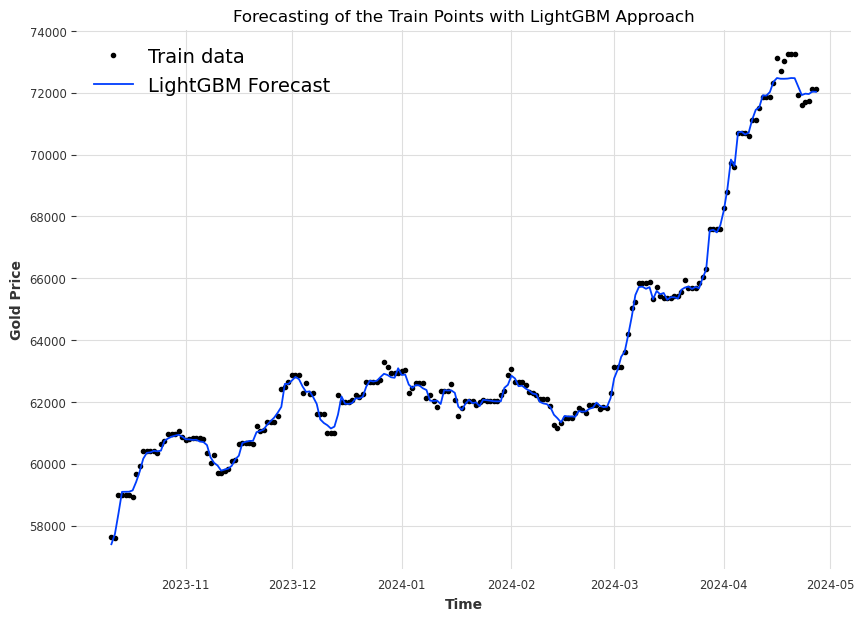

In [117]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=pred_train_lightgbm_es, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [118]:
lightgbm_metrics_train_es = evaluate_preds(y_true=y_train[-200:],
                                        y_pred=pred_train_lightgbm_es)
lightgbm_metrics_train_es

{'mae': np.float32(139.45485),
 'mse': np.float32(40084.17),
 'rmse': np.float32(200.21031),
 'mape': np.float32(0.21763097)}

##### Persist Metrics

In [119]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm_es.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train_es['mape'],
        "Val MAPE": lightgbm_metrics_es['mape'],
        "Train RMSE": lightgbm_metrics_train_es['rmse'],
        "Val RMSE": lightgbm_metrics_es['rmse']
    }])
], ignore_index=True)

#### Early Stopping Extremely Regularized Model

##### Create model

In [120]:
model_lightgbm_es_reg = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=4,
    max_depth=2,
    min_split_gain=0.2,
    min_child_weight=100,
    min_child_samples=400,
    subsample=0.6,
    colsample_bytree=0.6,
    feature_fraction=0.6,
    reg_lambda=20.0,
    reg_alpha=5.0,
    random_state=42,
    verbose=-1
)

model_lightgbm_es_reg.name = 'Early Stopping Extremely Regularized Model'

evals_result_lightgbm = {}

model_lightgbm_es_reg.fit(train_gold_price_windowed, train_labels,
                   eval_set=[(val_gold_price_windowed, val_labels)],
                   eval_metric='rmse',
                   callbacks=[
                       lgb.early_stopping(stopping_rounds=80),
                       lgb.log_evaluation(period=50),
                       lgb.record_evaluation(eval_result=evals_result_lightgbm)
                    ]
                )

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



Training until validation scores don't improve for 80 rounds
[50]	valid_0's rmse: 15854.9	valid_0's l2: 2.51379e+08
[100]	valid_0's rmse: 11553.2	valid_0's l2: 1.33476e+08
[150]	valid_0's rmse: 10226.7	valid_0's l2: 1.04586e+08
[200]	valid_0's rmse: 9652.09	valid_0's l2: 9.31628e+07
[250]	valid_0's rmse: 9396.63	valid_0's l2: 8.82967e+07
[300]	valid_0's rmse: 9244.9	valid_0's l2: 8.54682e+07
[350]	valid_0's rmse: 9128.6	valid_0's l2: 8.33313e+07
[400]	valid_0's rmse: 9024.29	valid_0's l2: 8.14377e+07
[450]	valid_0's rmse: 8948.18	valid_0's l2: 8.00699e+07
[500]	valid_0's rmse: 8895.83	valid_0's l2: 7.91358e+07
[550]	valid_0's rmse: 8831.8	valid_0's l2: 7.80007e+07
[600]	valid_0's rmse: 8794.88	valid_0's l2: 7.73499e+07
[650]	valid_0's rmse: 8757.37	valid_0's l2: 7.66915e+07
[700]	valid_0's rmse: 8709.82	valid_0's l2: 7.58609e+07
[750]	valid_0's rmse: 8683.26	valid_0's l2: 7.53989e+07
[800]	valid_0's rmse: 8648.07	valid_0's l2: 7.47892e+07
[850]	valid_0's rmse: 8602.75	valid_0's l2: 7.4

LGBMRegressor(colsample_bytree=0.6, feature_fraction=0.6, learning_rate=0.03,
              max_depth=2, min_child_samples=400, min_child_weight=100,
              min_split_gain=0.2, n_estimators=3000, num_leaves=4,
              objective='regression', random_state=42, reg_alpha=5.0,
              reg_lambda=20.0, subsample=0.6, verbose=-1)

##### Make predictions

In [121]:
pred_lightgbm_es_reg = model_lightgbm_es_reg.predict(val_gold_price_windowed, num_iteration=model_lightgbm_es_reg.best_iteration_)
pred_train_lightgbm_es_reg = model_lightgbm_es_reg.predict(train_gold_price_windowed[-200:], num_iteration=model_lightgbm_es_reg.best_iteration_)
len(pred_lightgbm_es_reg), len(pred_train_lightgbm_es_reg)

(127, 200)

##### Evaluate predictions

In this model, and all the coming models, there is a possibility of overfitting, so, I will look also the metrics on the train set.

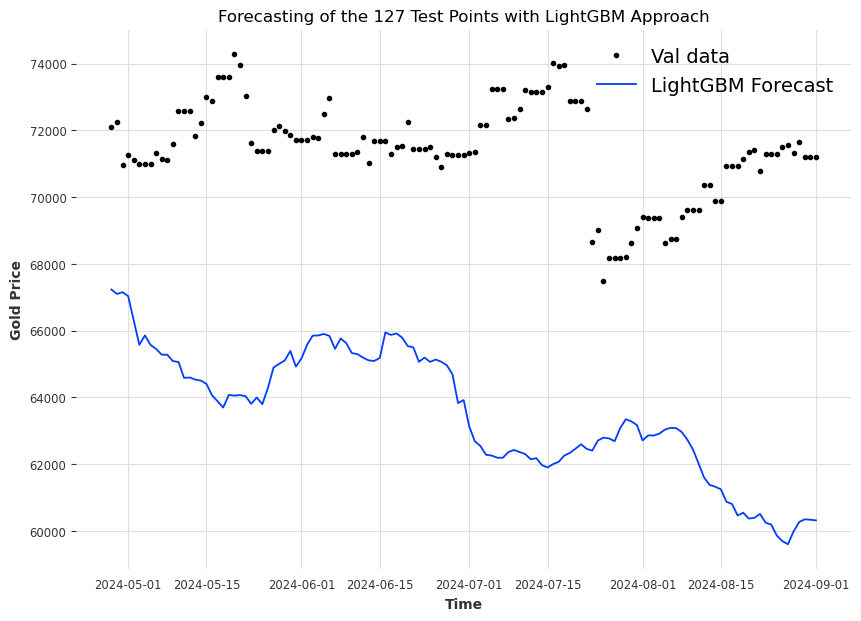

In [122]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=pred_lightgbm_es_reg, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Approach')
plt.show()

In [123]:
lightgbm_metrics_es_reg = evaluate_preds(y_true=y_val,
                                  y_pred=pred_lightgbm_es_reg)
lightgbm_metrics_es_reg

{'mae': np.float32(7887.872),
 'mse': np.float32(67199640.0),
 'rmse': np.float32(8197.539),
 'mape': np.float32(11.015951)}

##### Evaluate Overfitting

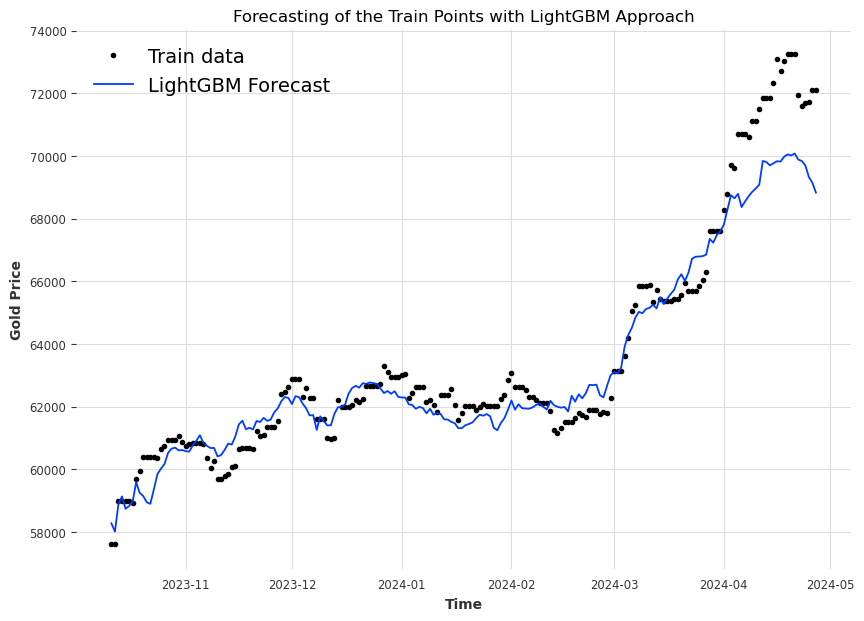

In [124]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=pred_train_lightgbm_es_reg, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Train Points with LightGBM Approach')
plt.show()

In [125]:
lightgbm_metrics_train_es_reg = evaluate_preds(y_true=y_train[-200:],
                                        y_pred=pred_train_lightgbm_es_reg)
lightgbm_metrics_train_es_reg

{'mae': np.float32(719.59796),
 'mse': np.float32(1031785.5),
 'rmse': np.float32(1015.76843),
 'mape': np.float32(1.0922394)}

##### Persist Metrics

In [126]:
df_models_metrics_lightgbm = pd.concat([
    df_models_metrics_lightgbm,
    pd.DataFrame([{
        "Model": model_lightgbm_es_reg.name,  # aquí guardas el objeto completo
        "Train MAPE": lightgbm_metrics_train_es_reg['mape'],
        "Val MAPE": lightgbm_metrics_es_reg['mape'],
        "Train RMSE": lightgbm_metrics_train_es_reg['rmse'],
        "Val RMSE": lightgbm_metrics_es_reg['rmse']
    }])
], ignore_index=True)

#### Final Graphical Comparision

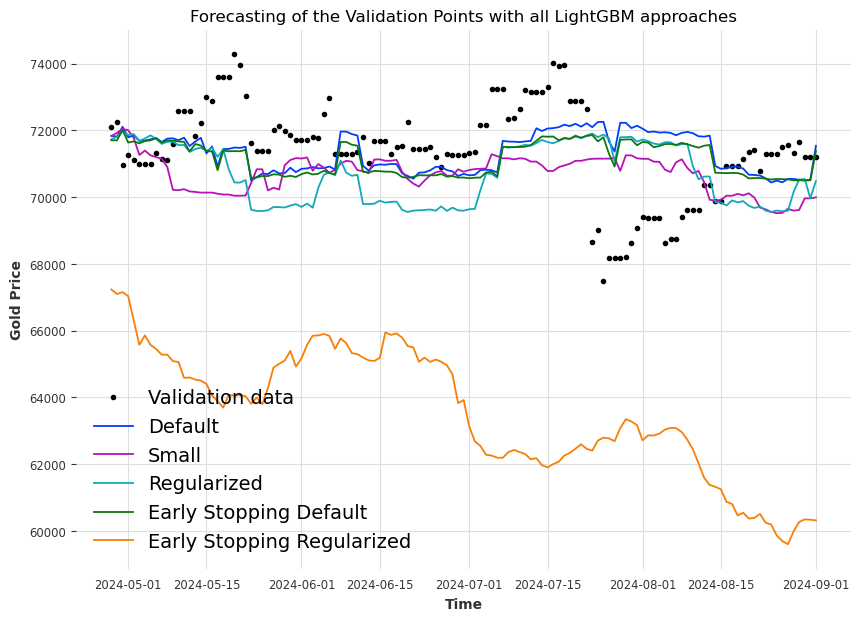

In [471]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Validation data")
plot_time_series(timesteps=X_val, values=pred_lightgbm_default, format='-', label='Default', xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_val, values=pred_lightgbm_small, format='-', label='Small', xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_val, values=pred_lightgbm_regularized, format='-', label='Regularized', xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_val, values=pred_lightgbm_es, format='-', label='Early Stopping Default', xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_val, values=pred_lightgbm_es_reg, format='-', label='Early Stopping Regularized', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the Validation Points with all LightGBM approaches')
plt.show()

#### Final Model and Metrics

In [127]:
df_models_metrics_lightgbm

Model  Train MAPE   Val MAPE  \
0                               Default Model    0.181026   1.810699   
1                                 Small Model    0.323716   2.017591   
2                           Regularized Model    0.176279   2.326790   
3                        Early Stopping Model    0.217631   1.813877   
4  Early Stopping Extremely Regularized Model    1.092239  11.015951   

    Train RMSE     Val RMSE  
0   157.443390  1620.304321  
1   277.714325  1736.172119  
2   156.497482  1868.057739  
3   200.210312  1555.150146  
4  1015.768433  8197.539062

In [128]:
model_lightgbm = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    max_depth=-1,
    min_split_gain=0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=0,
    reg_alpha=0,
    random_state=42,
    verbose=-1
)

evals_result_lightgbm = {}

model_lightgbm.fit(train_val_gold_price_windowed, train_val_labels,
                   eval_set=[(test_gold_price_windowed, test_labels)],
                   eval_metric='rmse',
                   callbacks=[
                       lgb.early_stopping(stopping_rounds=80),
                       lgb.log_evaluation(period=50),
                       lgb.record_evaluation(eval_result=evals_result_lightgbm)
                    ]
                )

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\lightgbm\basic.py:374: UserWarning:

Converting column-vector to 1d array



Training until validation scores don't improve for 80 rounds
[50]	valid_0's rmse: 22649.1	valid_0's l2: 5.1298e+08
[100]	valid_0's rmse: 14851.2	valid_0's l2: 2.20558e+08
[150]	valid_0's rmse: 10298	valid_0's l2: 1.06048e+08
[200]	valid_0's rmse: 7655.82	valid_0's l2: 5.86115e+07
[250]	valid_0's rmse: 6132.98	valid_0's l2: 3.76135e+07
[300]	valid_0's rmse: 5200.65	valid_0's l2: 2.70468e+07
[350]	valid_0's rmse: 4599.39	valid_0's l2: 2.11543e+07
[400]	valid_0's rmse: 4246.51	valid_0's l2: 1.80328e+07
[450]	valid_0's rmse: 4043.96	valid_0's l2: 1.63536e+07
[500]	valid_0's rmse: 3910.33	valid_0's l2: 1.52907e+07
[550]	valid_0's rmse: 3841.63	valid_0's l2: 1.47581e+07
[600]	valid_0's rmse: 3802.86	valid_0's l2: 1.44618e+07
[650]	valid_0's rmse: 3783.24	valid_0's l2: 1.43129e+07
[700]	valid_0's rmse: 3762.81	valid_0's l2: 1.41587e+07
[750]	valid_0's rmse: 3751.15	valid_0's l2: 1.40711e+07
[800]	valid_0's rmse: 3744.54	valid_0's l2: 1.40216e+07
[850]	valid_0's rmse: 3738.3	valid_0's l2: 1.39

LGBMRegressor(colsample_bytree=1, learning_rate=0.01, min_split_gain=0,
              n_estimators=1000, objective='regression', random_state=42,
              reg_alpha=0, reg_lambda=0, subsample=1, verbose=-1)

In [129]:
pred_lightgbm = model_lightgbm.predict(test_gold_price_windowed)

In [130]:
lightgbm_metrics = evaluate_preds(y_true=y_test,
                                  y_pred=pred_lightgbm)
lightgbm_metrics

{'mae': np.float32(3381.434),
 'mse': np.float32(13974850.0),
 'rmse': np.float32(3738.2952),
 'mape': np.float32(4.419694)}

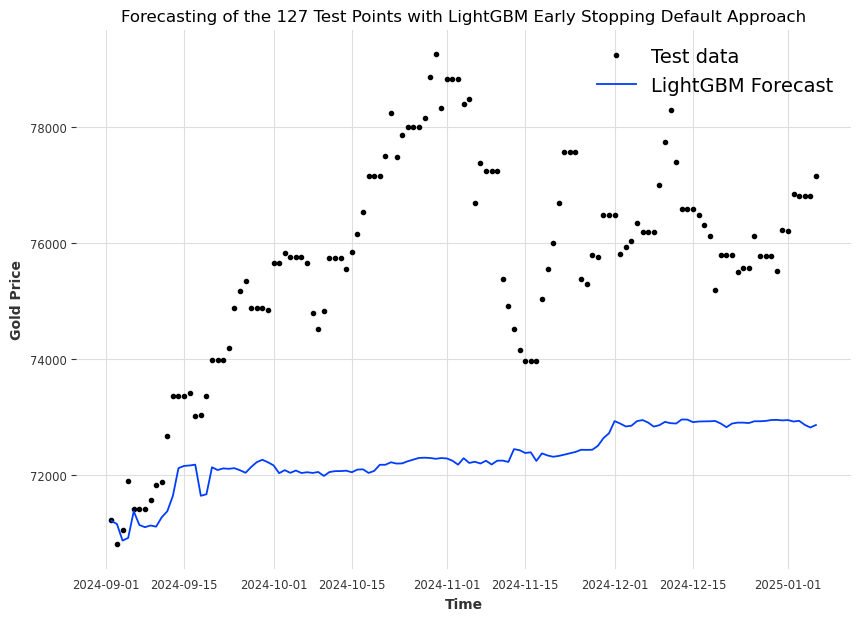

In [472]:
# Plot LigthGBM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=pred_lightgbm, format='-', label='LightGBM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with LightGBM Early Stopping Default Approach')
plt.show()

### N-BEATS

In [132]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

In [133]:
from utils.preds import make_predictions_rolling_one_darts

In [134]:
df_models_metrics_nbeats = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Prepare the data for `darts`

We have to transform our `pd.DataFrame` into a `TimeSeries` object, and scale it.

In [135]:
# Create scalers for both
scaler = Scaler()

# Create TimeSeries objects to work with darts framework
gold_price_darts_train = TimeSeries.from_dataframe(gold_price[:2*split_size], value_cols='Price')
gold_price_darts_val = TimeSeries.from_dataframe(gold_price[2*split_size:split_size], value_cols='Price')
gold_price_darts_test = TimeSeries.from_dataframe(gold_price[split_size:], value_cols='Price')

# Scale the data
gold_price_darts_scaled_train = scaler.fit_transform(gold_price_darts_train)
gold_price_darts_scaled_val = scaler.transform(gold_price_darts_val)
gold_price_darts_scaled_test = scaler.transform(gold_price_darts_test)

In [136]:
from darts import concatenate

gold_price_darts_scaled_train_val = concatenate([gold_price_darts_scaled_train, gold_price_darts_scaled_val])

#### Default Model

##### Create model

In [137]:
model_nbeats_default = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon´
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=10,
    batch_size=32,
    random_state=42
)

model_nbeats_default.name = 'Default Model'

model_nbeats_default.fit(gold_price_darts_scaled_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
------------

Epoch 9: 100%|██████████| 117/117 [00:05<00:00, 19.72it/s, train_loss=7.27e-5] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 117/117 [00:05<00:00, 19.72it/s, train_loss=7.27e-5]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, batch_size=32, random_state=42)

##### Make Predictions

In [138]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [139]:
preds_nbeats_default = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.38it/s]


##### Evaluate Predicts

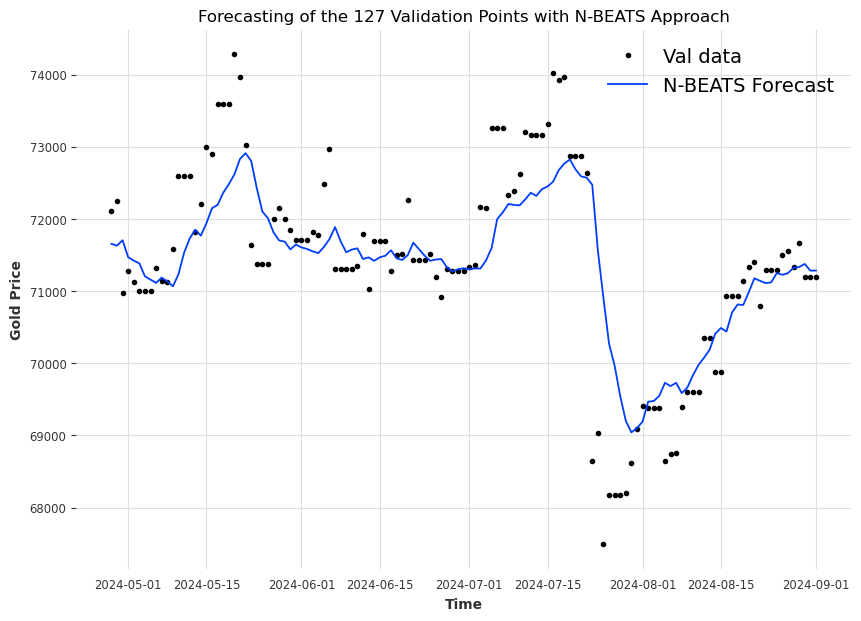

In [140]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats_default, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [141]:
nbeats_metrics_default = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats_default)
nbeats_metrics_default

{'mae': np.float32(559.4595),
 'mse': np.float32(704117.0),
 'rmse': np.float32(839.1168),
 'mape': np.float32(0.7855973)}

##### Evaluate Overfitting

In [142]:
preds_holdout_train_nbeats_default = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


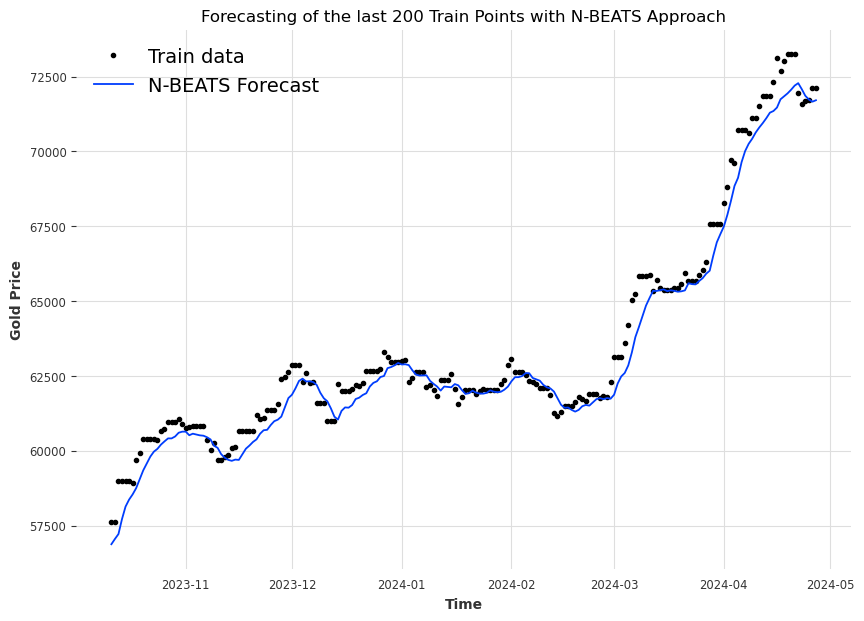

In [143]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats_default, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [144]:
nbeats_train_metrics_default = evaluate_preds(y_pred=preds_holdout_train_nbeats_default,
                                      y_true=y_train[-200:])
nbeats_train_metrics_default

{'mae': np.float32(483.83368),
 'mse': np.float32(395858.88),
 'rmse': np.float32(629.17316),
 'mape': np.float32(0.7540162)}

##### Persist Metrics

In [145]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats_default.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics_default['mape'],
        "Val MAPE": nbeats_train_metrics_default['mape'],
        "Train RMSE": nbeats_train_metrics_default['rmse'],
        "Val RMSE": nbeats_metrics_default['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11352\991512130.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Dropout Model

##### Create Model

In [146]:
model_nbeats_dropout = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon´
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0.2,
    n_epochs=10,
    batch_size=32,
    random_state=42
)

model_nbeats_dropout.name = 'Dropout Model'

model_nbeats_dropout.fit(gold_price_darts_scaled_train)

Epoch 9: 100%|██████████| 117/117 [00:07<00:00, 16.32it/s, train_loss=0.000443]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, batch_size=32, random_state=42)

##### Make Predictions

In [147]:
preds_nbeats_dropout = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats_dropout)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.65it/s]


##### Evaluate Predicts

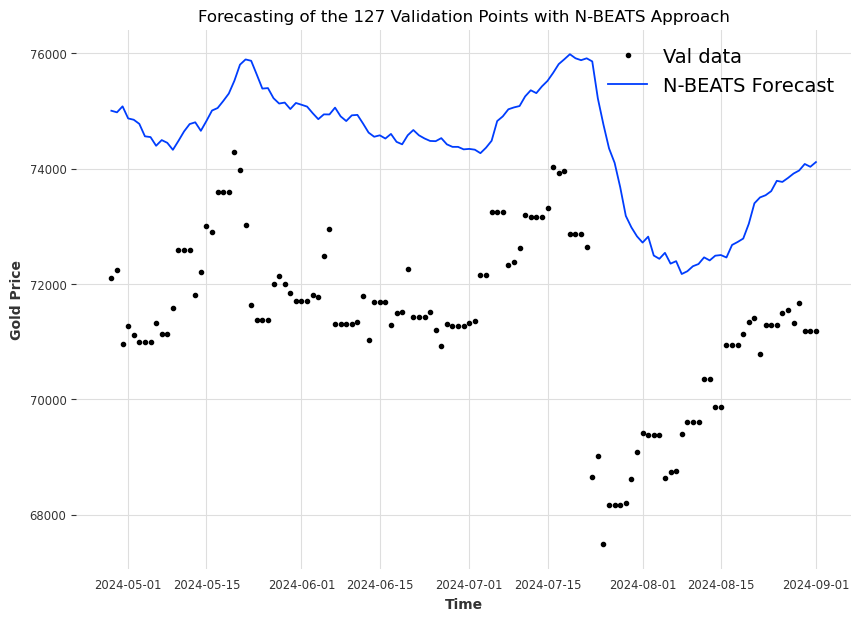

In [148]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats_dropout, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [149]:
nbeats_metrics_dropout = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats_dropout)
nbeats_metrics_dropout

{'mae': np.float32(2978.6768),
 'mse': np.float32(9985142.0),
 'rmse': np.float32(3159.9275),
 'mape': np.float32(4.1932607)}

##### Evaluate Overffiting

In [150]:
preds_holdout_train_nbeats_dropout = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats_dropout)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.86it/s]


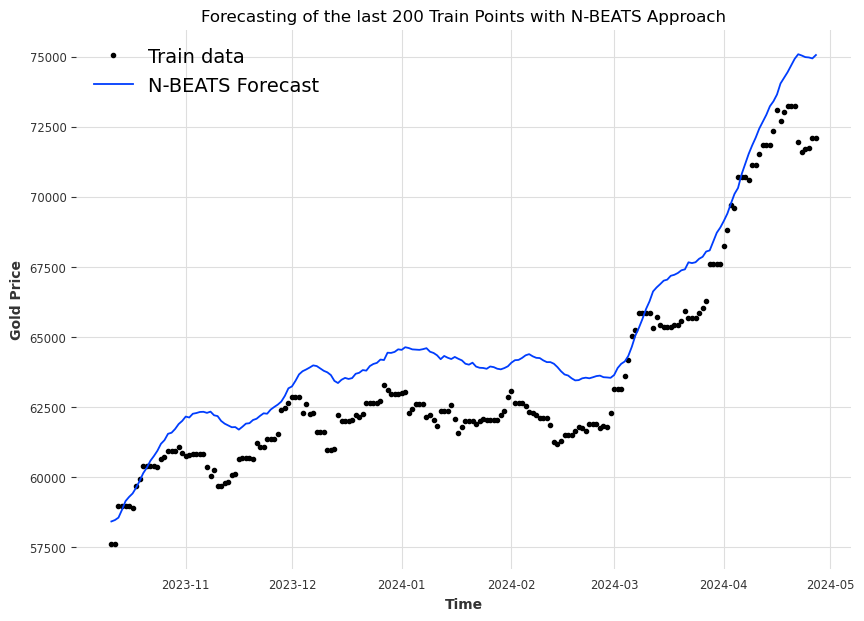

In [151]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats_dropout, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [152]:
nbeats_train_metrics_dropout = evaluate_preds(y_pred=preds_holdout_train_nbeats_dropout,
                                      y_true=y_train[-200:])
nbeats_train_metrics_dropout

{'mae': np.float32(1442.8308),
 'mse': np.float32(2612838.8),
 'rmse': np.float32(1616.4277),
 'mape': np.float32(2.2793756)}

##### Persist Metrics

In [153]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats_dropout.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics_dropout['mape'],
        "Val MAPE": nbeats_train_metrics_dropout['mape'],
        "Train RMSE": nbeats_train_metrics_dropout['rmse'],
        "Val RMSE": nbeats_metrics_dropout['rmse']
    }])
], ignore_index=True)

#### Small Model

Less num_stacks, layer_widths and num_layers.

##### Create Model

In [154]:
model_nbeats_small = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon´
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=6,
    num_blocks=1,
    num_layers=3,
    layer_widths=128,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=10,
    batch_size=32,
    random_state=42
)

model_nbeats_small.name = 'Small Model'

model_nbeats_small.fit(gold_price_darts_scaled_train)

Epoch 9: 100%|██████████| 117/117 [00:01<00:00, 81.08it/s, train_loss=0.000159]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=128, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=10, batch_size=32, random_state=42)

##### Make Predictions

In [155]:
preds_nbeats_small = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.79it/s]


##### Evaluate Predictions

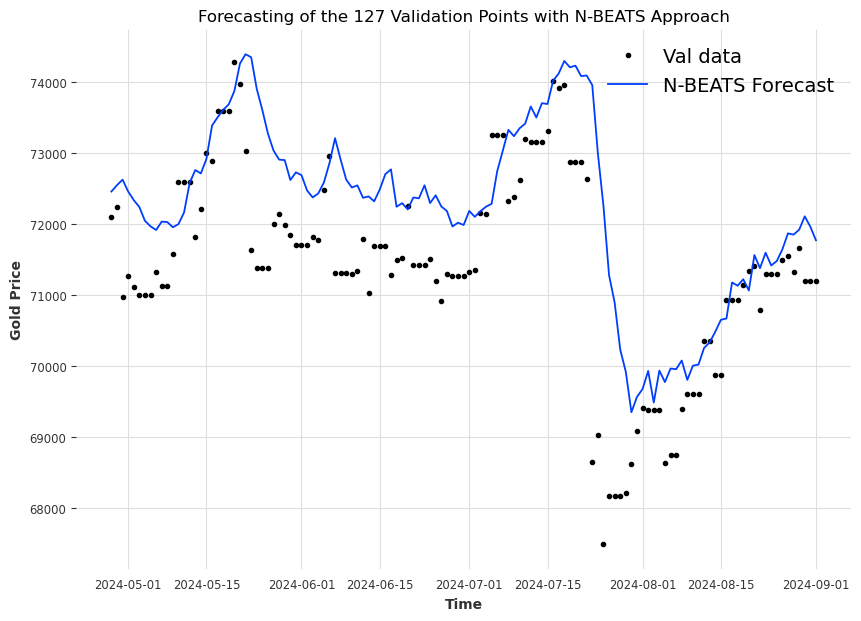

In [156]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats_small, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [157]:
nbeats_metrics_small = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats_small)
nbeats_metrics_small

{'mae': np.float32(867.72595),
 'mse': np.float32(1471268.8),
 'rmse': np.float32(1212.9586),
 'mape': np.float32(1.2268078)}

##### Evaluate Overfitting

In [158]:
preds_holdout_train_nbeats_small = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.90it/s]


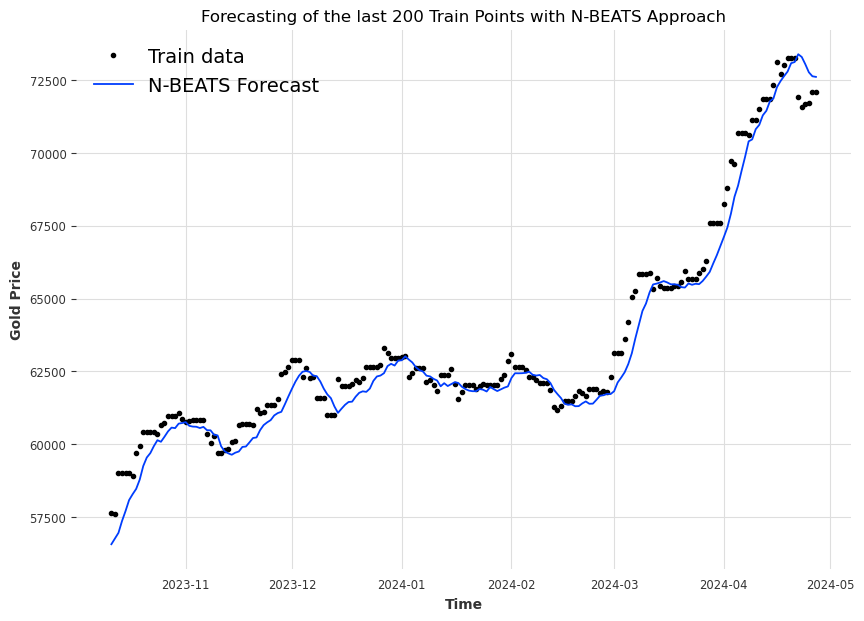

In [159]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats_small, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [160]:
nbeats_train_metrics_small = evaluate_preds(y_pred=preds_holdout_train_nbeats_small,
                                      y_true=y_train[-200:])
nbeats_train_metrics_small

{'mae': np.float32(537.4243),
 'mse': np.float32(486650.9),
 'rmse': np.float32(697.6037),
 'mape': np.float32(0.8417752)}

##### Persist Metrics

In [161]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats_small.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics_small['mape'],
        "Val MAPE": nbeats_train_metrics_small['mape'],
        "Train RMSE": nbeats_train_metrics_small['rmse'],
        "Val RMSE": nbeats_metrics_small['rmse']
    }])
], ignore_index=True)

#### Early Stopping Model

##### Create Model

In [162]:
from pytorch_lightning.callbacks import EarlyStopping

In [163]:
early_stopper = EarlyStopping(monitor="train_loss", patience=5, mode="min")

model_nbeats_es = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=1,
    n_epochs=100,
    batch_size=32,
    dropout=0.2,
    pl_trainer_kwargs={"callbacks": [early_stopper]},
    random_state=42
)

model_nbeats_es.name = 'Early Stopping Model'

model_nbeats_es.fit(gold_price_darts_scaled_train)

Epoch 22: 100%|██████████| 117/117 [00:06<00:00, 17.50it/s, train_loss=0.000197]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002309BD7C0A0>]}, random_state=42)

##### Make Predictions

In [164]:
preds_nbeats_es = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                  ts_test=gold_price_darts_scaled_val,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.00it/s]


##### Evaluate Predictions

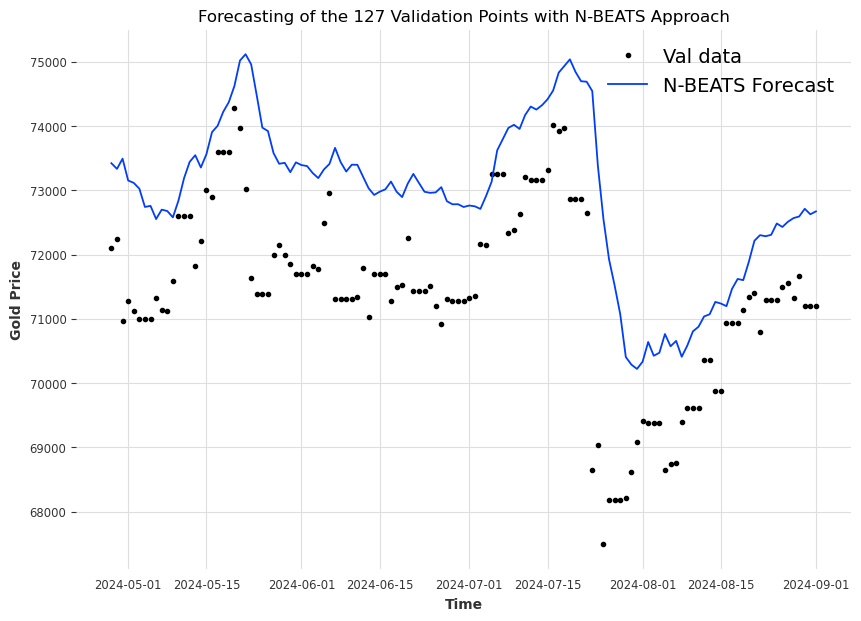

In [165]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeats_es, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Validation Points with N-BEATS Approach')
plt.show()

In [166]:
nbeats_metrics_es = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats_es)
nbeats_metrics_es

{'mae': np.float32(1486.3608),
 'mse': np.float32(2960347.8),
 'rmse': np.float32(1720.5662),
 'mape': np.float32(2.0947604)}

##### Evaluate Overfitting

In [167]:
preds_holdout_train_nbeats_es = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


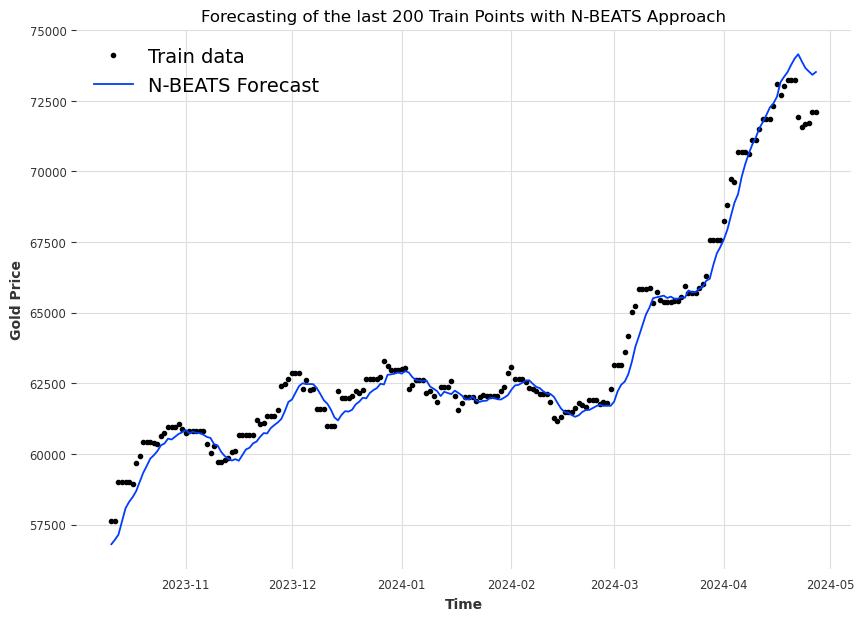

In [168]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeats_es, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATS Approach')
plt.show()

In [169]:
nbeats_train_metrics_es = evaluate_preds(y_pred=preds_holdout_train_nbeats_es,
                                      y_true=y_train[-200:])
nbeats_train_metrics_es

{'mae': np.float32(472.3415),
 'mse': np.float32(424990.25),
 'rmse': np.float32(651.9128),
 'mape': np.float32(0.7373628)}

##### Persist Metrics

In [170]:
df_models_metrics_nbeats = pd.concat([
    df_models_metrics_nbeats,
    pd.DataFrame([{
        "Model": model_nbeats_es.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeats_metrics_es['mape'],
        "Val MAPE": nbeats_train_metrics_es['mape'],
        "Train RMSE": nbeats_train_metrics_es['rmse'],
        "Val RMSE": nbeats_metrics_es['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [171]:
df_models_metrics_nbeats

Model  Train MAPE  Val MAPE   Train RMSE     Val RMSE
0         Default Model    0.785597  0.754016   629.173157   839.116821
1         Dropout Model    4.193261  2.279376  1616.427734  3159.927490
2           Small Model    1.226808  0.841775   697.603699  1212.958618
3  Early Stopping Model    2.094760  0.737363   651.912781  1720.566162

In [172]:
early_stopper = EarlyStopping(monitor="train_loss", patience=5, mode="min")

model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=1,
    n_epochs=100,
    batch_size=32,
    dropout=0.2,
    pl_trainer_kwargs={"callbacks": [early_stopper]},
    random_state=42
)

model_nbeats.fit(gold_price_darts_scaled_train_val)

Epoch 17: 100%|██████████| 121/121 [00:06<00:00, 17.57it/s, train_loss=0.000345]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002309BF1FB50>]}, random_state=42)

In [173]:
preds_nbeats = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train_val,
                                                  ts_test=gold_price_darts_scaled_test,
                                                  ts_exogenus_train=None,
                                                  ts_exogenus_test=None,
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeats)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


In [174]:
nbeats_metrics = evaluate_preds(y_true=y_val,
                                y_pred=preds_nbeats)
nbeats_metrics

{'mae': np.float32(4781.924),
 'mse': np.float32(27972034.0),
 'rmse': np.float32(5288.8594),
 'mape': np.float32(6.7483387)}

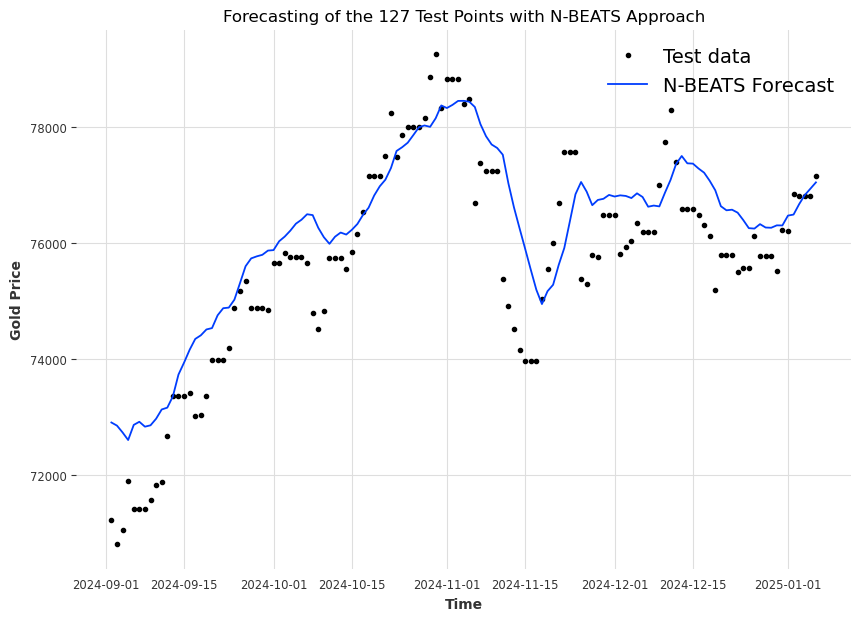

In [175]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_nbeats, format='-', label='N-BEATS Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with N-BEATS Approach')
plt.show()

### LSTM - Long Short Term Memory

In [176]:
from darts.models import RNNModel

In [177]:
df_models_metrics_lstm = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Preparing the data

In [178]:
# Create scaler
scaler_exogenus = Scaler()

gold_price_exogenus_darts_train = TimeSeries.from_dataframe(gold_price[:2*split_size], value_cols=exog_data.columns.values)
gold_price_exogenus_darts_val = TimeSeries.from_dataframe(gold_price[2*split_size:split_size], value_cols=exog_data.columns.values)
gold_price_exogenus_darts_train_val = concatenate([gold_price_exogenus_darts_train, gold_price_exogenus_darts_val])
gold_price_exogenus_darts_test = TimeSeries.from_dataframe(gold_price[split_size:], value_cols=exog_data.columns.values)

gold_price_exogenus_darts_scaled_train = scaler_exogenus.fit_transform(gold_price_exogenus_darts_train)
gold_price_exogenus_darts_scaled_val = scaler_exogenus.transform(gold_price_exogenus_darts_val)
gold_price_exogenus_darts_scaled_train_val = scaler_exogenus.transform(gold_price_exogenus_darts_train_val)
gold_price_exogenus_darts_scaled_test = scaler_exogenus.transform(gold_price_exogenus_darts_test)

#### Default Model

##### Create Model

In [179]:
model_lstm_default = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=25,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_lstm_default.name = 'Default Model'

model_lstm_default.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 128.48it/s, train_loss=5.15e-5] 


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [180]:
preds_lstm_default = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.27it/s]


##### Evaluate Predictions

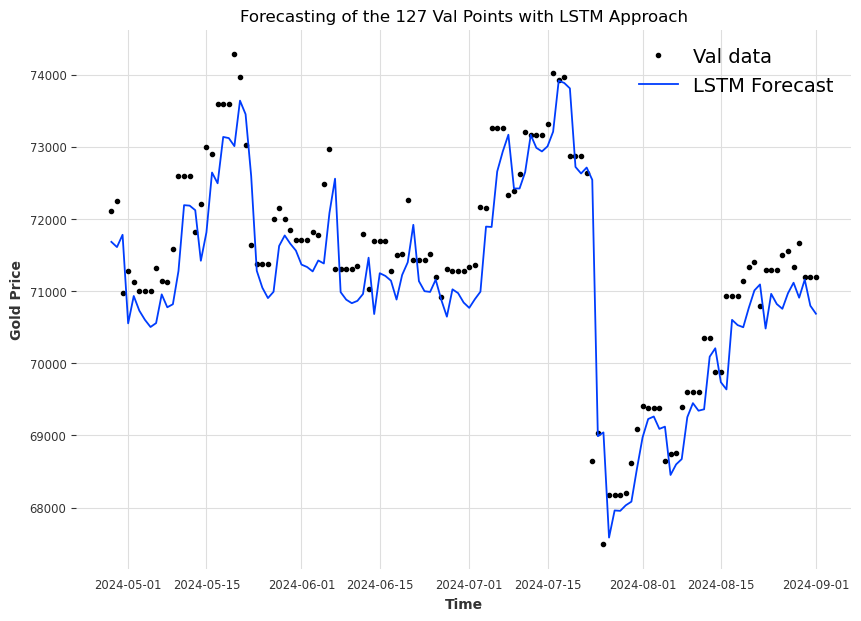

In [181]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm_default, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [182]:
lstm_metrics_default = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm_default)
lstm_metrics_default

{'mae': np.float32(511.40848),
 'mse': np.float32(460193.0),
 'rmse': np.float32(678.37524),
 'mape': np.float32(0.7166395)}

##### Evaluate Overfitting

In [183]:
preds_holdout_train_lstm_default = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.52it/s]


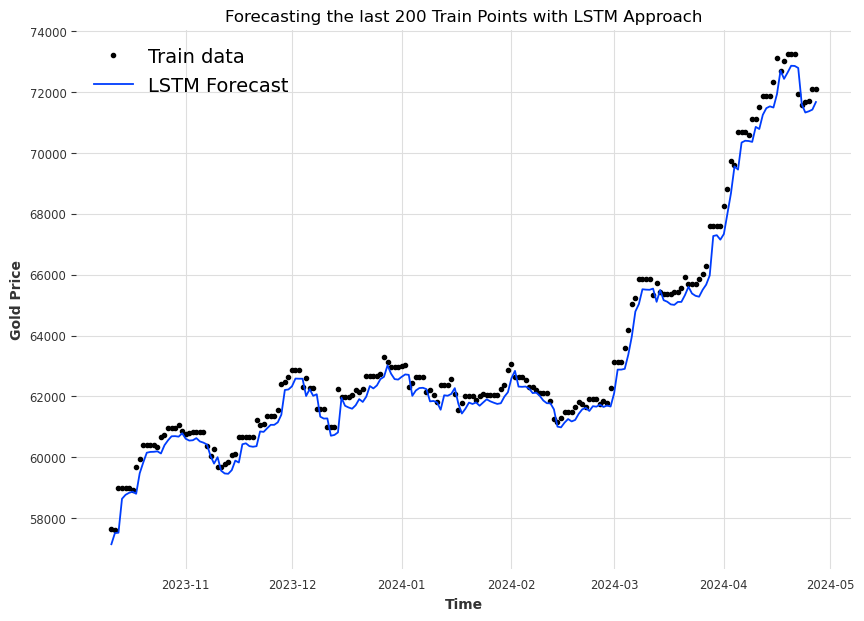

In [184]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm_default, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [185]:
lstm_train_metrics_default = evaluate_preds(y_pred=preds_holdout_train_lstm_default,
                                      y_true=y_train[-200:])
lstm_train_metrics_default

{'mae': np.float32(382.9713),
 'mse': np.float32(218594.48),
 'rmse': np.float32(467.5409),
 'mape': np.float32(0.59840083)}

##### Persist Metrics

In [186]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm_default.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics_default['mape'],
        "Val MAPE": lstm_metrics_default['mape'],
        "Train RMSE": lstm_train_metrics_default['rmse'],
        "Val RMSE": lstm_metrics_default['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11352\3510078410.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [187]:
model_lstm_small = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=10,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_lstm_small.name = 'Small Model'

model_lstm_small.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 132.42it/s, train_loss=2.64e-5] 


RNNModel(model=LSTM, hidden_dim=10, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [188]:
preds_lstm_small = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.38it/s]


##### Evaluate Predictions

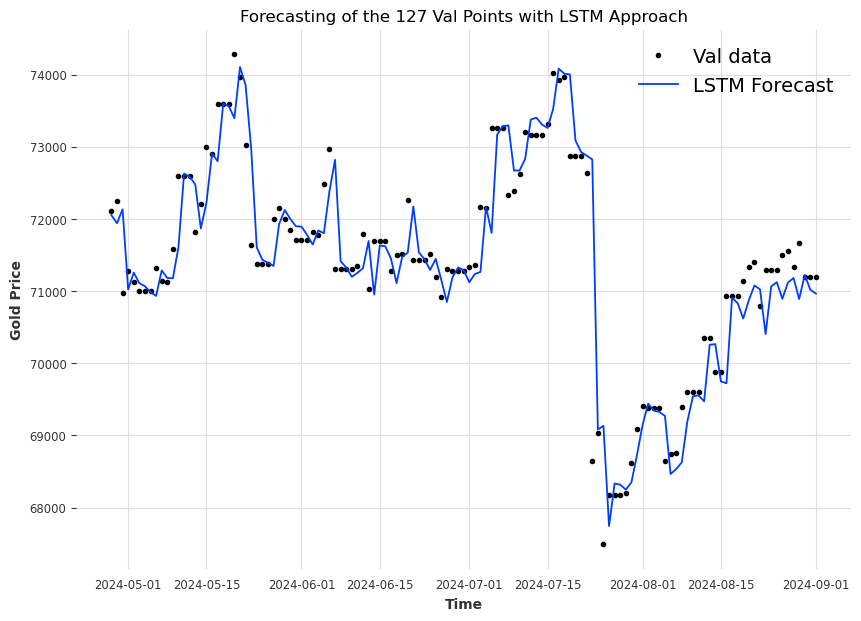

In [189]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm_small, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [190]:
lstm_metrics_small = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm_small)
lstm_metrics_small

{'mae': np.float32(365.1829),
 'mse': np.float32(375774.7),
 'rmse': np.float32(613.00464),
 'mape': np.float32(0.512999)}

##### Evaluate Overfitting

In [191]:
preds_holdout_train_lstm_small = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.37it/s]


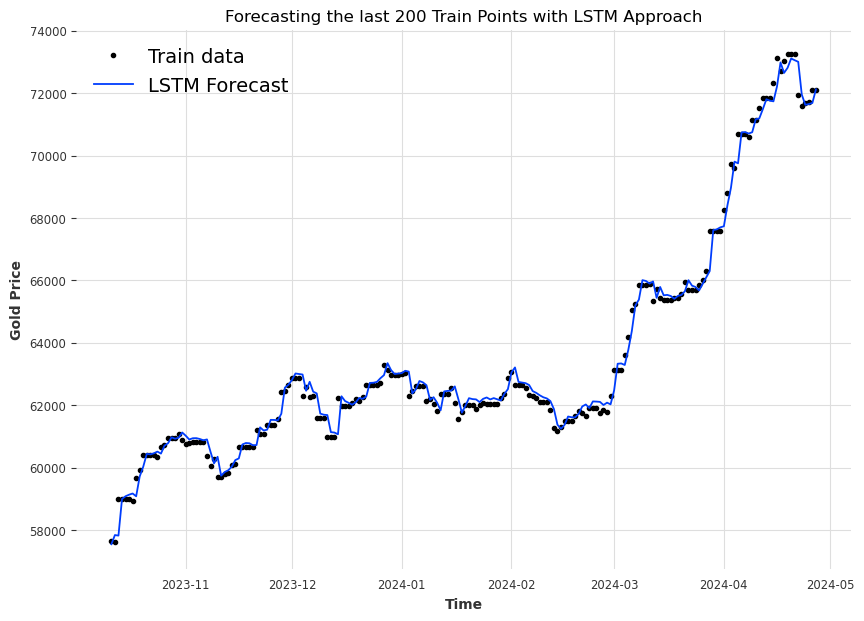

In [192]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm_small, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [193]:
lstm_train_metrics_small = evaluate_preds(y_pred=preds_holdout_train_lstm_small,
                                      y_true=y_train[-200:])
lstm_train_metrics_small

{'mae': np.float32(233.78181),
 'mse': np.float32(110067.33),
 'rmse': np.float32(331.76398),
 'mape': np.float32(0.3659693)}

##### Persist Metrics

In [194]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm_small.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics_small['mape'],
        "Val MAPE": lstm_metrics_small['mape'],
        "Train RMSE": lstm_train_metrics_small['rmse'],
        "Val RMSE": lstm_metrics_small['rmse']
    }])
], ignore_index=True)

#### Complex Model

##### Create Model

In [195]:
model_lstm_complex = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=40,
    n_rnn_layers=3,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_lstm_complex.name = 'Complex Model'

model_lstm_complex.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:01<00:00, 86.93it/s, train_loss=3.22e-5] 


RNNModel(model=LSTM, hidden_dim=40, n_rnn_layers=3, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [196]:
preds_lstm_complex = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.78it/s]


##### Evaluate Predictions

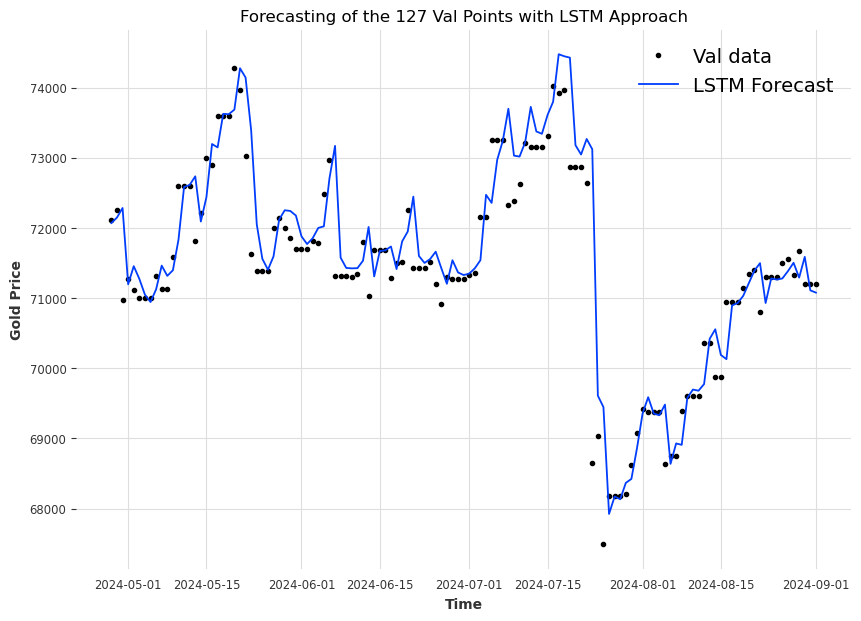

In [197]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm_complex, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [198]:
lstm_metrics_complex = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm_complex)
lstm_metrics_complex

{'mae': np.float32(370.49582),
 'mse': np.float32(418088.9),
 'rmse': np.float32(646.59796),
 'mape': np.float32(0.5204744)}

##### Evaluate Overfitting

In [199]:
preds_holdout_train_lstm_complex = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.76it/s]


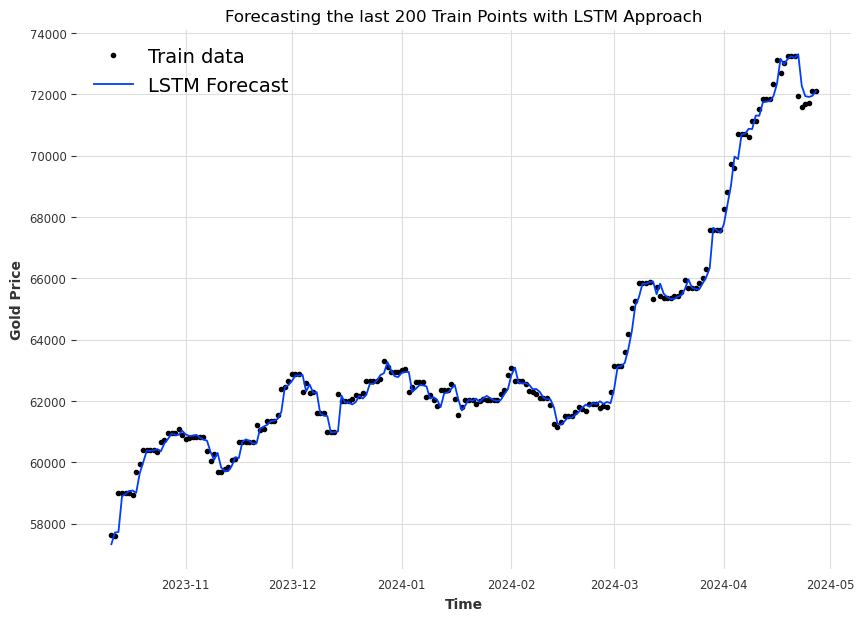

In [200]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm_complex, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [201]:
lstm_train_metrics_complex = evaluate_preds(y_pred=preds_holdout_train_lstm_complex,
                                      y_true=y_train[-200:])
lstm_train_metrics_complex

{'mae': np.float32(208.72307),
 'mse': np.float32(103199.46),
 'rmse': np.float32(321.24673),
 'mape': np.float32(0.32647598)}

##### Persist Metrics

In [202]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm_complex.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics_complex['mape'],
        "Val MAPE": lstm_metrics_complex['mape'],
        "Train RMSE": lstm_train_metrics_complex['rmse'],
        "Val RMSE": lstm_metrics_complex['rmse']
    }])
], ignore_index=True)

#### Regularized Small Model

##### Create Model

In [203]:
model_lstm_reg = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=10,
    n_rnn_layers=1,
    dropout=0.2,
    batch_size=32,
    n_epochs=100
)

model_lstm_reg.name = 'Regularized Small Model'

model_lstm_reg.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 138.79it/s, train_loss=2.87e-5] 


RNNModel(model=LSTM, hidden_dim=10, n_rnn_layers=1, dropout=0.2, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [204]:
preds_lstm_reg = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm_reg)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.18it/s]


##### Evaluate Predictions

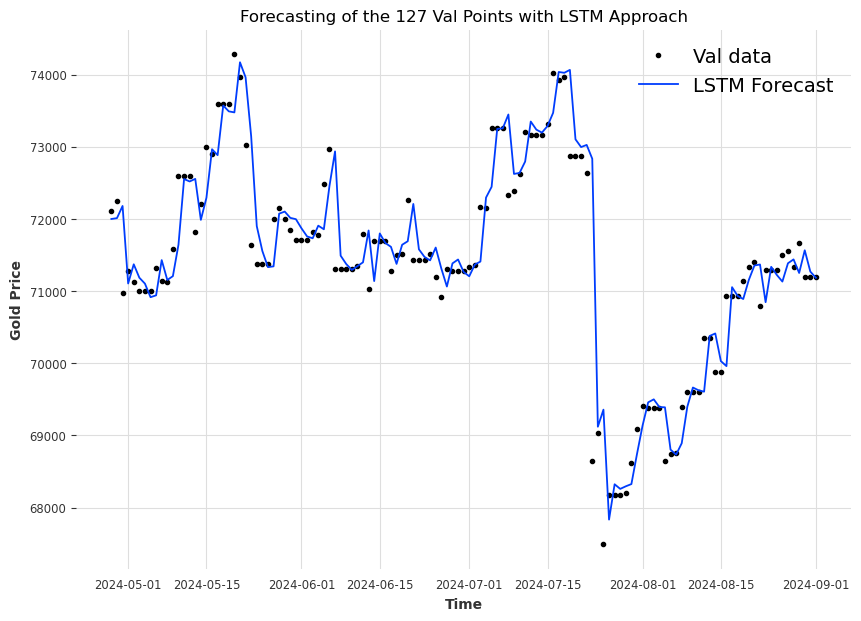

In [205]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm_reg, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [206]:
lstm_metrics_reg = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm_reg)
lstm_metrics_reg

{'mae': np.float32(340.895),
 'mse': np.float32(357312.3),
 'rmse': np.float32(597.75604),
 'mape': np.float32(0.4791832)}

##### Evaluate Overfitting

In [207]:
preds_holdout_train_lstm_reg = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm_reg)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.93it/s]


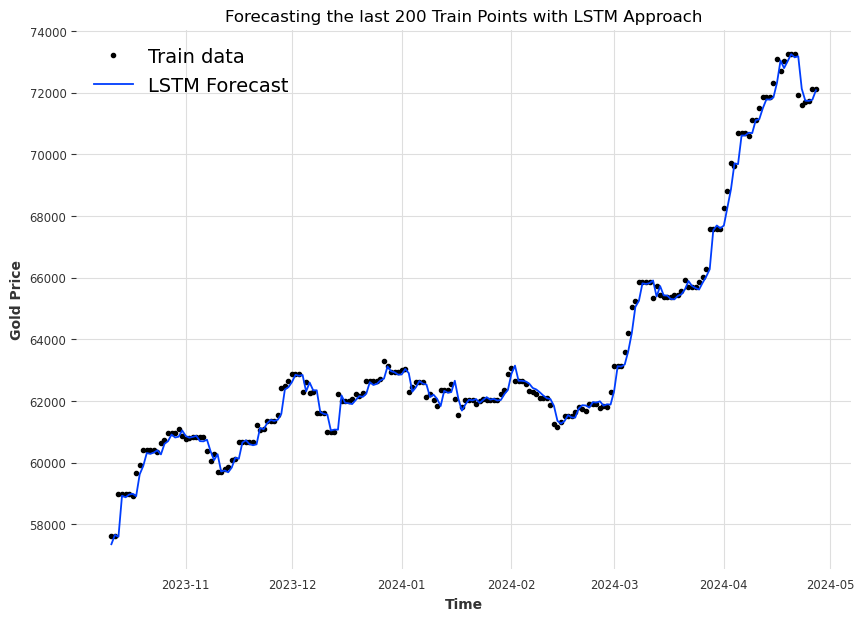

In [208]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm_reg, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [209]:
lstm_train_metrics_reg = evaluate_preds(y_pred=preds_holdout_train_lstm_reg,
                                      y_true=y_train[-200:])
lstm_train_metrics_reg

{'mae': np.float32(220.19322),
 'mse': np.float32(115673.87),
 'rmse': np.float32(340.1086),
 'mape': np.float32(0.34429836)}

##### Persist Metrics

In [210]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm_reg.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics_reg['mape'],
        "Val MAPE": lstm_metrics_reg['mape'],
        "Train RMSE": lstm_train_metrics_reg['rmse'],
        "Val RMSE": lstm_metrics_reg['rmse']
    }])
], ignore_index=True)

#### Early Stopping Model

##### Create Model

In [211]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_lstm_es = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=25,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=1000,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_lstm_es.name = 'Early Stopping Model'

model_lstm_es.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 84: 100%|██████████| 117/117 [00:00<00:00, 141.09it/s, train_loss=4.91e-5] 


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=1000, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000230CEA09630>]})

##### Make Predictions

In [212]:
preds_lstm_es = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


##### Evaluate Predictions

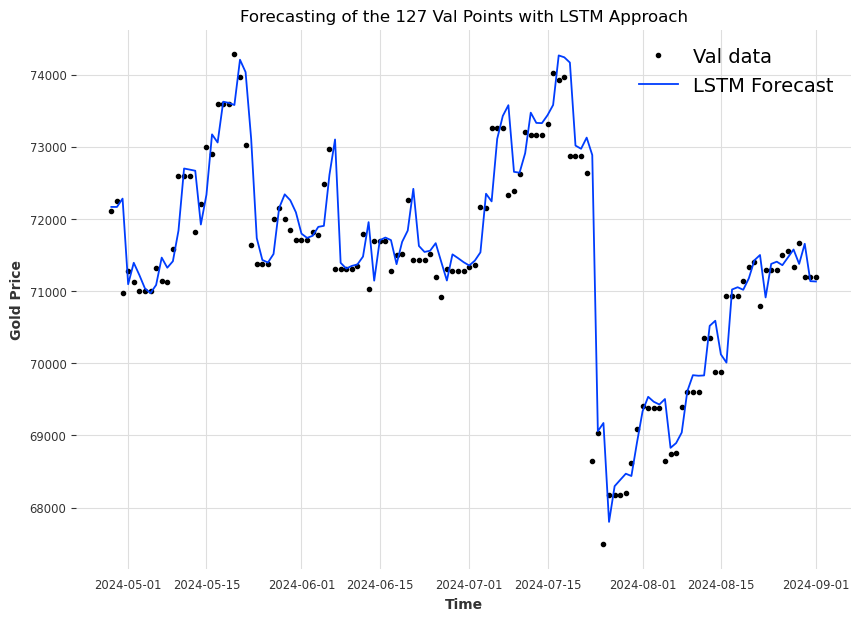

In [213]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_lstm_es, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with LSTM Approach')
plt.show()

In [214]:
lstm_metrics_es = evaluate_preds(y_true=y_val,
                              y_pred=preds_lstm_es)
lstm_metrics_es

{'mae': np.float32(350.7762),
 'mse': np.float32(366765.22),
 'rmse': np.float32(605.61145),
 'mape': np.float32(0.49290234)}

##### Evaluate Overfitting

In [215]:
preds_holdout_train_lstm_es = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_lstm_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.28it/s]


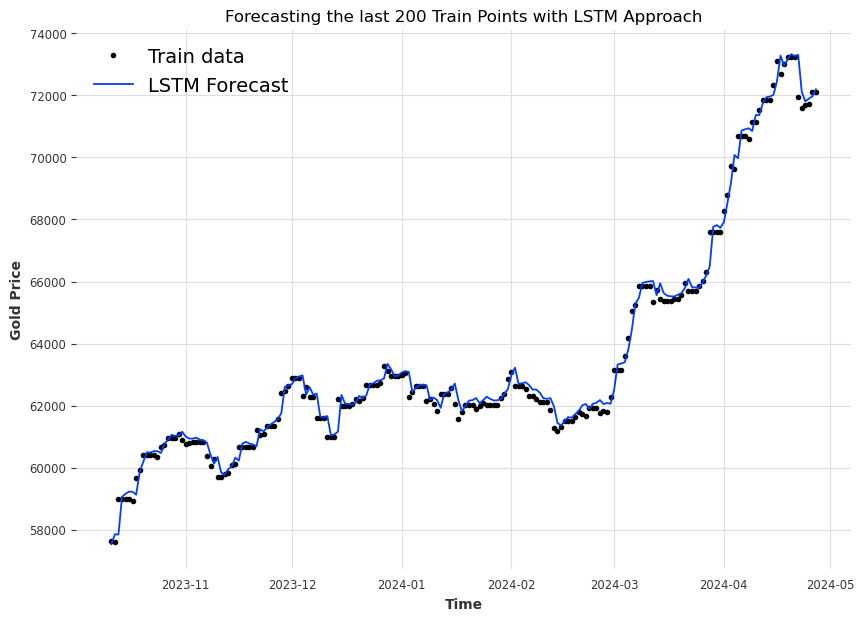

In [216]:
# Plot LSTM forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_lstm_es, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with LSTM Approach')
plt.show()

In [217]:
lstm_train_metrics_es = evaluate_preds(y_pred=preds_holdout_train_lstm_es,
                                      y_true=y_train[-200:])
lstm_train_metrics_es

{'mae': np.float32(225.46054),
 'mse': np.float32(103502.92),
 'rmse': np.float32(321.7187),
 'mape': np.float32(0.35375923)}

##### Persist Metrics

In [218]:
df_models_metrics_lstm = pd.concat([
    df_models_metrics_lstm,
    pd.DataFrame([{
        "Model": model_lstm_es.name,  # aquí guardas el objeto completo
        "Train MAPE": lstm_train_metrics_es['mape'],
        "Val MAPE": lstm_metrics_es['mape'],
        "Train RMSE": lstm_train_metrics_es['rmse'],
        "Val RMSE": lstm_metrics_es['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [219]:
df_models_metrics_lstm

Model  Train MAPE  Val MAPE  Train RMSE    Val RMSE
0            Default Model    0.598401  0.716640  467.540894  678.375244
1              Small Model    0.365969  0.512999  331.763977  613.004639
2            Complex Model    0.326476  0.520474  321.246735  646.597961
3  Regularized Small Model    0.344298  0.479183  340.108612  597.756042
4     Early Stopping Model    0.353759  0.492902  321.718689  605.611450

In [220]:
model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=10,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_lstm.fit(gold_price_darts_scaled_train_val, future_covariates=gold_price_exogenus_darts_scaled_train_val)

Epoch 99: 100%|██████████| 121/121 [00:00<00:00, 137.41it/s, train_loss=2.86e-5] 


RNNModel(model=LSTM, hidden_dim=10, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

In [221]:
preds_lstm = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_lstm)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.02it/s]


In [222]:
nbeats_metrics = evaluate_preds(y_true=y_test,
                                y_pred=preds_lstm)
nbeats_metrics

{'mae': np.float32(541.69135),
 'mse': np.float32(434142.5),
 'rmse': np.float32(658.8949),
 'mape': np.float32(0.7128992)}

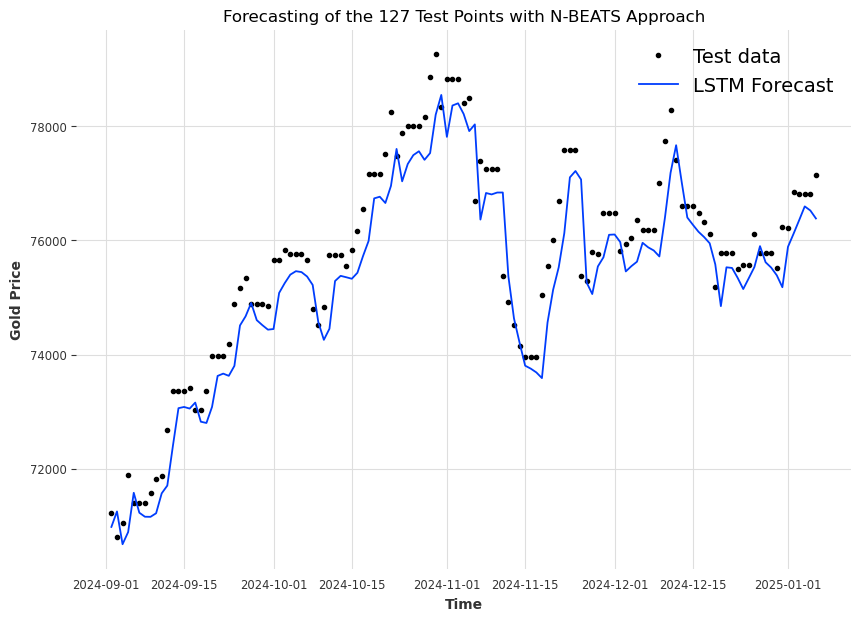

In [223]:
# Plot N-BEATS forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_lstm, format='-', label='LSTM Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with N-BEATS Approach')
plt.show()

### GRU - Gated Recurrent Unit Neural Network

In [224]:
df_models_metrics_gru = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [225]:
model_gru_default = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=25,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_gru_default.name = 'Default Model'

model_gru_default.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 140.10it/s, train_loss=3.11e-5] 


RNNModel(model=GRU, hidden_dim=25, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [226]:
preds_gru_default = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]


##### Evaluate Predictions

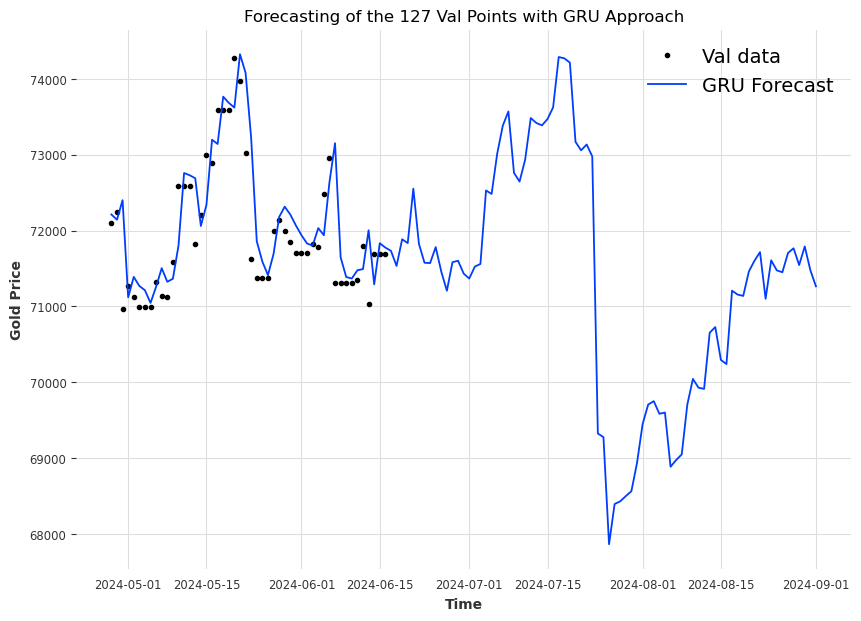

In [227]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru_default, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [228]:
gru_metrics_default = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru_default)
gru_metrics_default

{'mae': np.float32(397.91998),
 'mse': np.float32(403338.53),
 'rmse': np.float32(635.0894),
 'mape': np.float32(0.5594981)}

##### Evaluate Overfitting

In [229]:
preds_holdout_train_gru_default = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.31it/s]


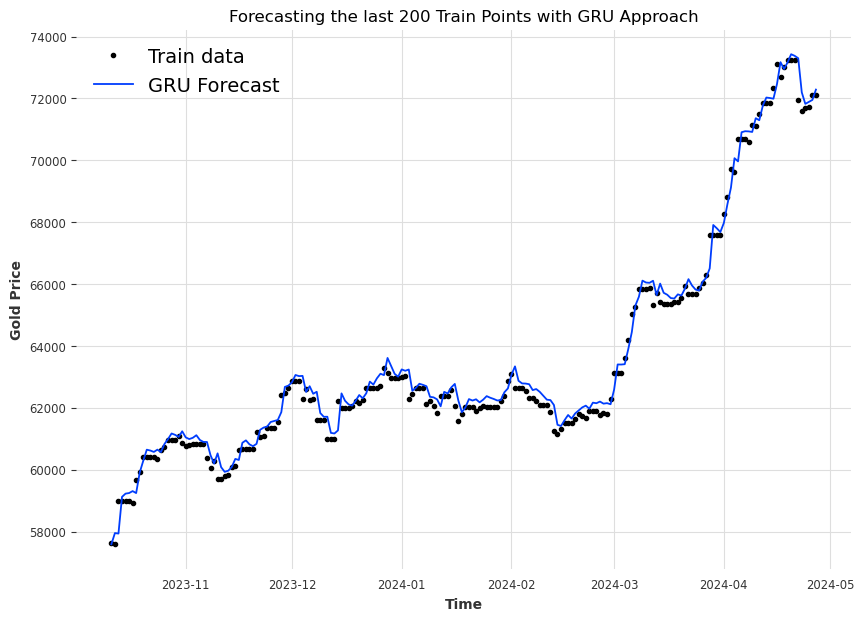

In [230]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru_default, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [231]:
gru_train_metrics_default = evaluate_preds(y_pred=preds_holdout_train_gru_default,
                                      y_true=y_train[-200:])
gru_train_metrics_default

{'mae': np.float32(272.8216),
 'mse': np.float32(123925.16),
 'rmse': np.float32(352.03006),
 'mape': np.float32(0.42964524)}

##### Persist Metrics

In [232]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru_default.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics_default['mape'],
        "Val MAPE": gru_metrics_default['mape'],
        "Train RMSE": gru_train_metrics_default['rmse'],
        "Val RMSE": gru_metrics_default['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11352\3334006219.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [233]:
model_gru_small = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=12,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_gru_small.name = 'Small Model'

model_gru_small.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 129.39it/s, train_loss=3.01e-5] 


RNNModel(model=GRU, hidden_dim=12, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [234]:
preds_gru_small = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.09it/s]


##### Evaluate Predictions

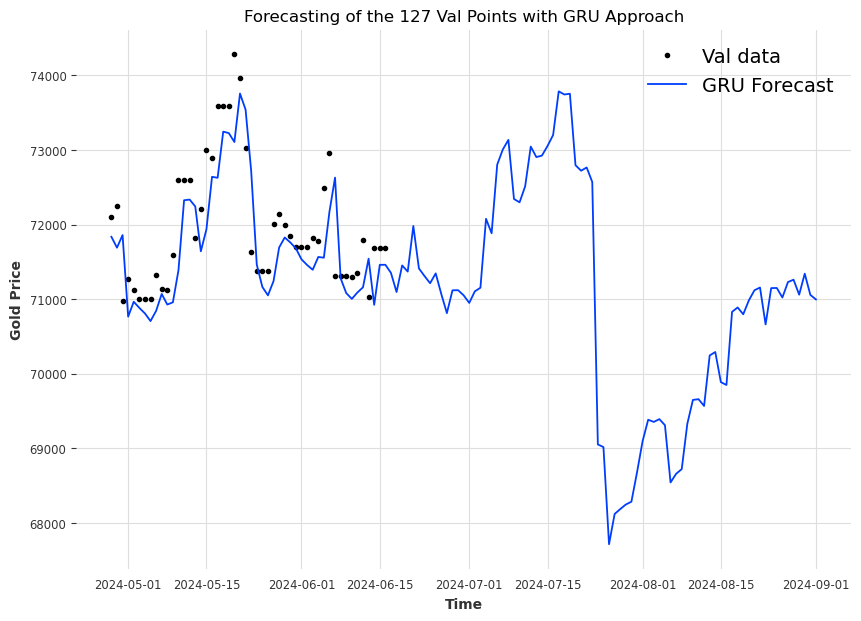

In [235]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru_small, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [236]:
gru_metrics_small = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru_small)
gru_metrics_small

{'mae': np.float32(402.21997),
 'mse': np.float32(369110.97),
 'rmse': np.float32(607.54504),
 'mape': np.float32(0.56315464)}

##### Evaluate Overfitting

In [237]:
preds_holdout_train_gru_small = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


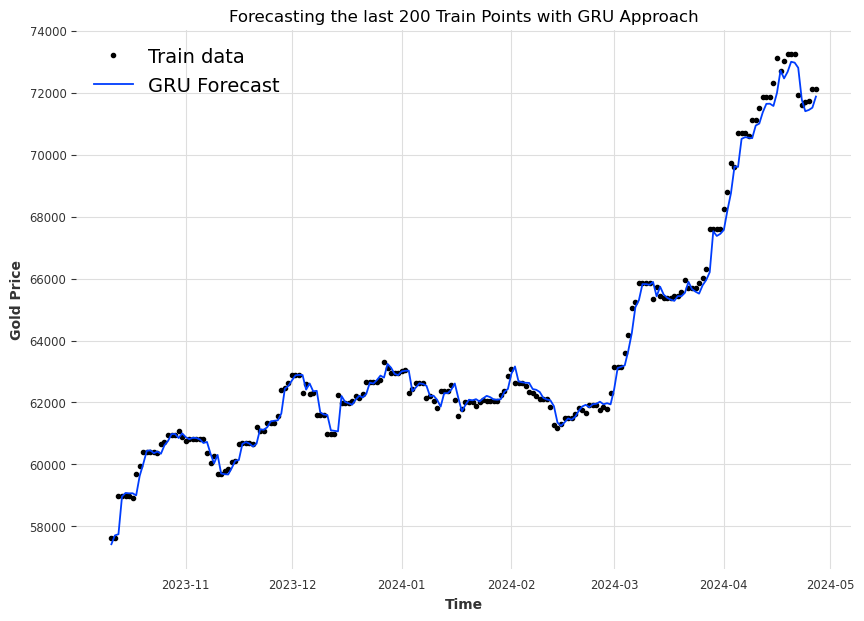

In [238]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru_small, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [239]:
gru_train_metrics_small = evaluate_preds(y_pred=preds_holdout_train_gru_small,
                                      y_true=y_train[-200:])
gru_train_metrics_small

{'mae': np.float32(230.72334),
 'mse': np.float32(121449.53),
 'rmse': np.float32(348.4961),
 'mape': np.float32(0.3576787)}

##### Persist Metrics

In [240]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru_small.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics_small['mape'],
        "Val MAPE": gru_metrics_small['mape'],
        "Train RMSE": gru_train_metrics_small['rmse'],
        "Val RMSE": gru_metrics_small['rmse']
    }])
], ignore_index=True)

#### Complex Model

##### Create Model

In [241]:
model_gru_complex = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=35,
    n_rnn_layers=3,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_gru_complex.name = 'Complex Model'

model_gru_complex.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:01<00:00, 88.72it/s, train_loss=3.64e-5] 


RNNModel(model=GRU, hidden_dim=35, n_rnn_layers=3, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [242]:
preds_gru_complex = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.32it/s]


##### Evaluate Predictions

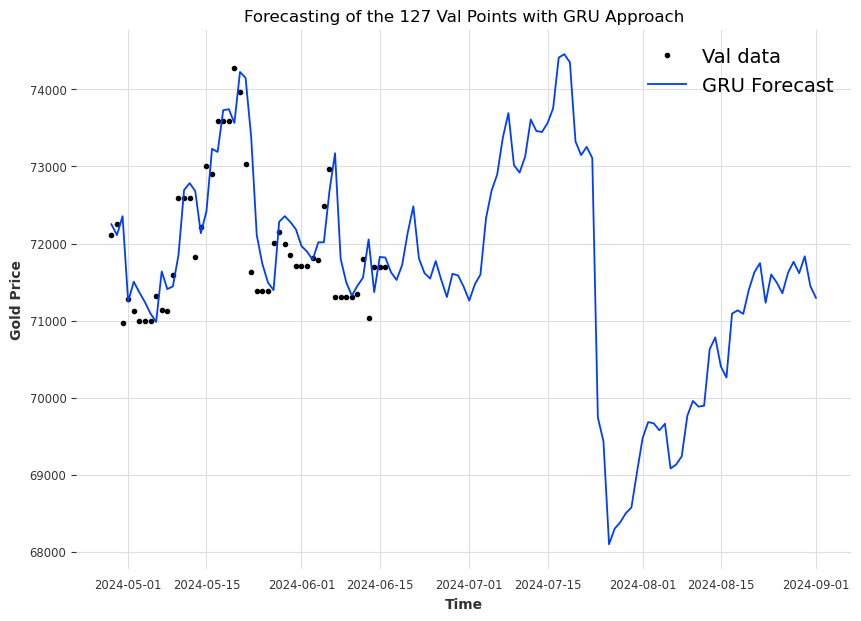

In [243]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru_complex, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [244]:
gru_metrics_complex = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru_complex)
gru_metrics_complex

{'mae': np.float32(416.27866),
 'mse': np.float32(440685.25),
 'rmse': np.float32(663.8413),
 'mape': np.float32(0.58520555)}

##### Evaluate Overfitting

In [245]:
preds_holdout_train_gru_complex = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.71it/s] 


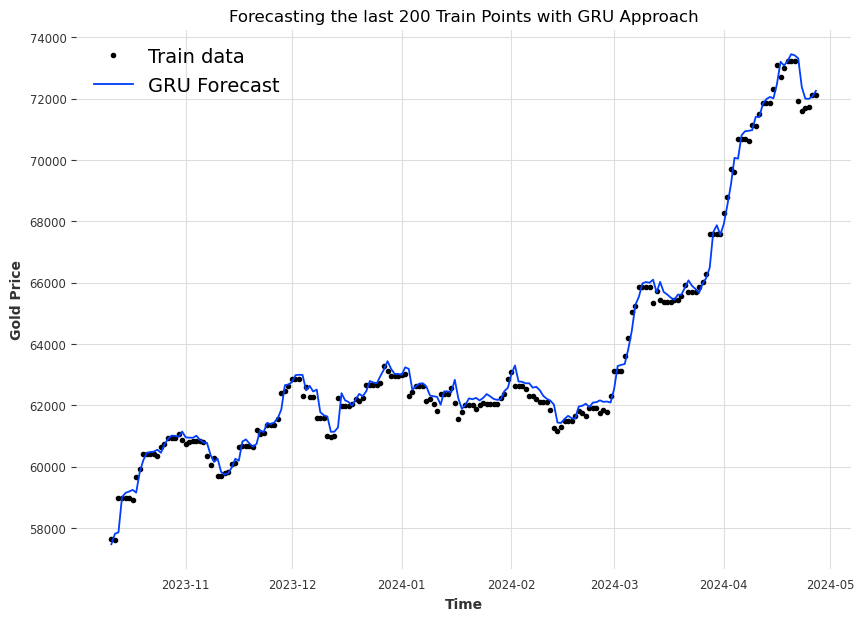

In [246]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru_complex, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [247]:
gru_train_metrics_complex = evaluate_preds(y_pred=preds_holdout_train_gru_complex,
                                      y_true=y_train[-200:])
gru_train_metrics_complex

{'mae': np.float32(238.88379),
 'mse': np.float32(109273.82),
 'rmse': np.float32(330.56592),
 'mape': np.float32(0.37474495)}

##### Persist Metrics

In [248]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru_complex.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics_complex['mape'],
        "Val MAPE": gru_metrics_complex['mape'],
        "Train RMSE": gru_train_metrics_complex['rmse'],
        "Val RMSE": gru_metrics_complex['rmse']
    }])
], ignore_index=True)

#### Regularized Small Model

##### Create Model

In [249]:
model_gru_reg_small = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=12,
    n_rnn_layers=1,
    dropout=0.2,
    batch_size=32,
    n_epochs=100
)

model_gru_reg_small.name = 'Regularized Small Model'

model_gru_reg_small.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 135.92it/s, train_loss=3.22e-5] 


RNNModel(model=GRU, hidden_dim=12, n_rnn_layers=1, dropout=0.2, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

##### Make Predictions

In [250]:
preds_gru_reg_small = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru_reg_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.21it/s]


##### Evaluate Predictions

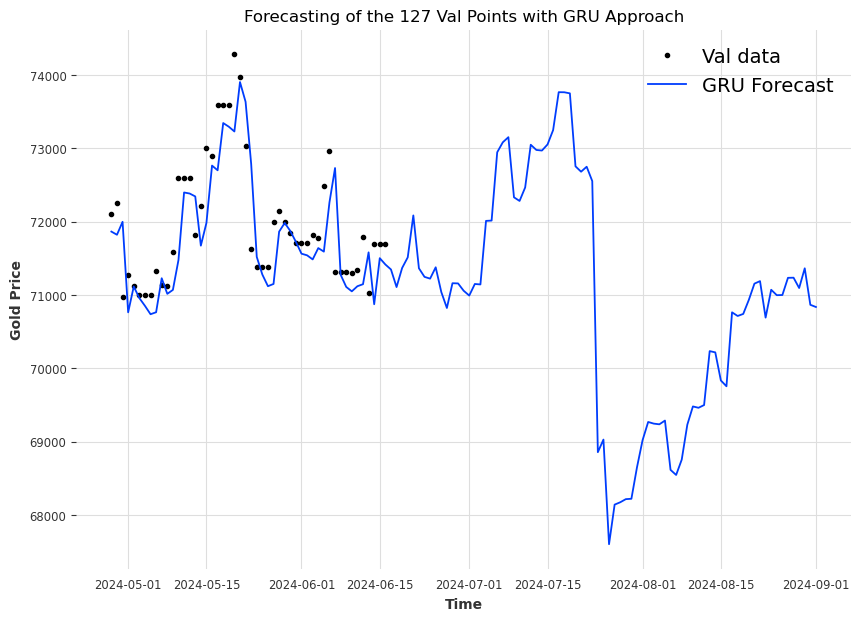

In [251]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru_reg_small, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [252]:
gru_metrics_reg_small = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru_reg_small)
gru_metrics_reg_small

{'mae': np.float32(400.6904),
 'mse': np.float32(365425.72),
 'rmse': np.float32(604.5045),
 'mape': np.float32(0.5618292)}

##### Evaluate Overfitting

In [253]:
preds_holdout_train_gru_reg_small = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru_reg_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.02it/s] 


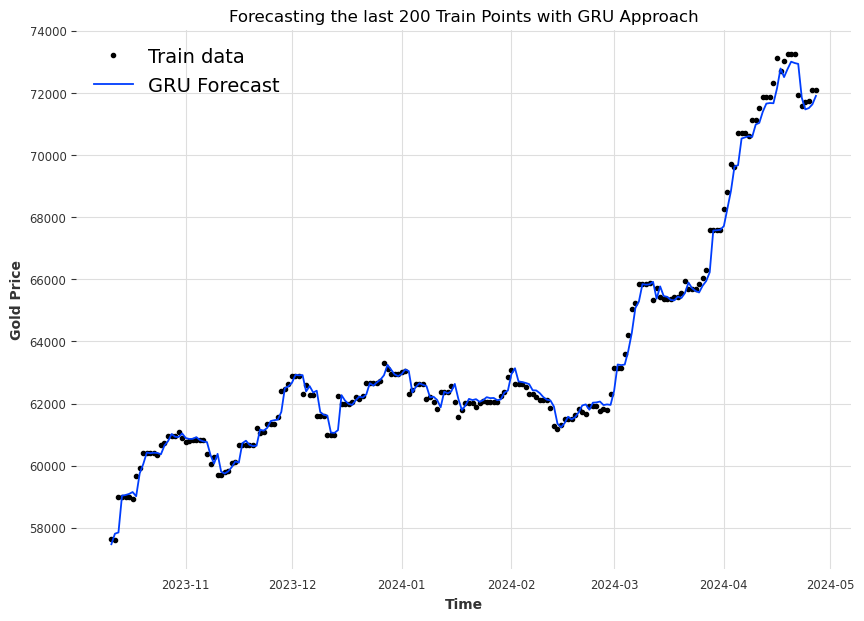

In [254]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru_reg_small, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [255]:
gru_train_metrics_reg_small = evaluate_preds(y_pred=preds_holdout_train_gru_reg_small,
                                      y_true=y_train[-200:])
gru_train_metrics_reg_small

{'mae': np.float32(225.49986),
 'mse': np.float32(113213.46),
 'rmse': np.float32(336.47208),
 'mape': np.float32(0.35057822)}

##### Persist Metrics

In [256]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru_reg_small.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics_reg_small['mape'],
        "Val MAPE": gru_metrics_reg_small['mape'],
        "Train RMSE": gru_train_metrics_reg_small['rmse'],
        "Val RMSE": gru_metrics_reg_small['rmse']
    }])
], ignore_index=True)

#### Regularized Big Complex Model

##### Create Model

In [257]:
model_gru_reg_complex = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=50,
    n_rnn_layers=5,
    dropout=0.2,
    batch_size=32,
    n_epochs=200
)

model_gru_reg_complex.name = 'Regularized Big Complex Model'

model_gru_reg_complex.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 199: 100%|██████████| 117/117 [00:01<00:00, 66.80it/s, train_loss=7.91e-5] 


RNNModel(model=GRU, hidden_dim=50, n_rnn_layers=5, dropout=0.2, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=200)

##### Make Predictions

In [258]:
preds_gru_reg_complex = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru_reg_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.83it/s] 


##### Evaluate Predictions

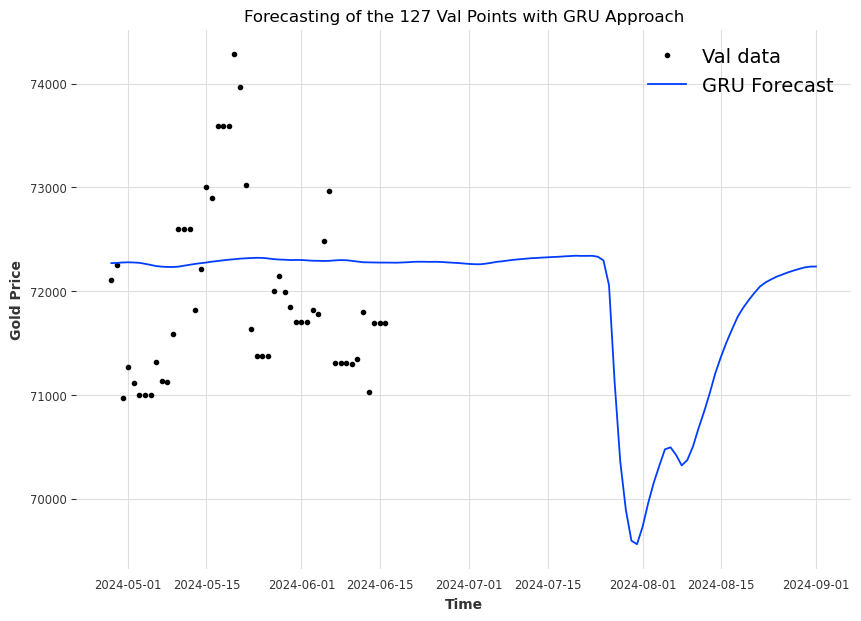

In [259]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru_reg_complex, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [260]:
gru_metrics_reg_complex = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru_reg_complex)
gru_metrics_reg_complex

{'mae': np.float32(952.22595),
 'mse': np.float32(1414974.8),
 'rmse': np.float32(1189.5271),
 'mape': np.float32(1.3435907)}

##### Evaluate Overfitting

In [261]:
preds_holdout_train_gru_reg_complex = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru_reg_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.11it/s]


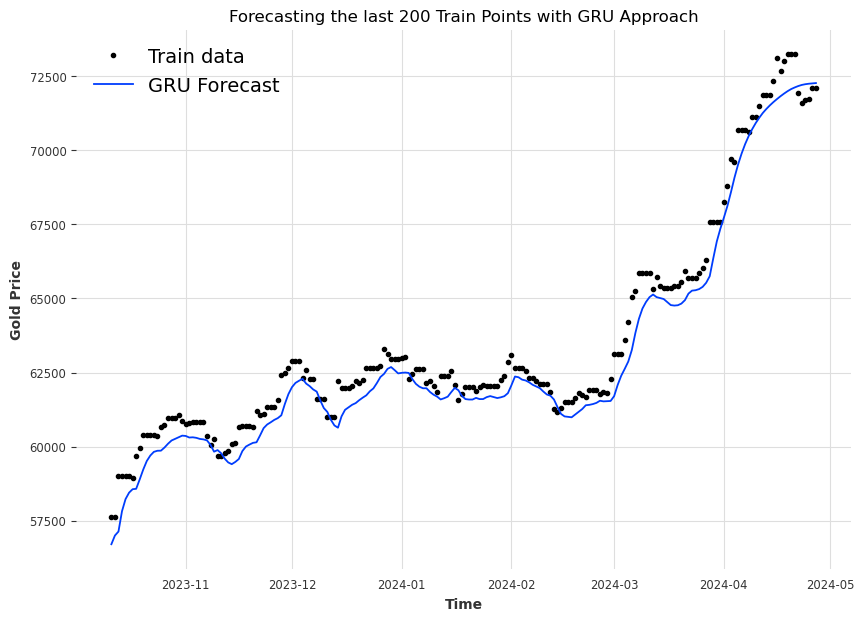

In [262]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru_reg_complex, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [263]:
gru_train_metrics_reg_complex = evaluate_preds(y_pred=preds_holdout_train_gru_reg_complex,
                                      y_true=y_train[-200:])
gru_train_metrics_reg_complex

{'mae': np.float32(600.65607),
 'mse': np.float32(488844.4),
 'rmse': np.float32(699.1741),
 'mape': np.float32(0.943895)}

##### Persist Metrics

In [264]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru_reg_complex.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics_reg_complex['mape'],
        "Val MAPE": gru_metrics_reg_complex['mape'],
        "Train RMSE": gru_train_metrics_reg_complex['rmse'],
        "Val RMSE": gru_metrics_reg_complex['rmse']
    }])
], ignore_index=True)

#### Early Stopping Regularized Big Complex Model

##### Create Model

In [265]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_gru_es = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=50,
    n_rnn_layers=5,
    dropout=0.2,
    batch_size=32,
    n_epochs=1000,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_gru_es.name = 'Early Stopping Regularized Big Complex Model'

model_gru_es.fit(gold_price_darts_scaled_train, future_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 178: 100%|██████████| 117/117 [00:01<00:00, 63.29it/s, train_loss=0.000104]


RNNModel(model=GRU, hidden_dim=50, n_rnn_layers=5, dropout=0.2, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=1000, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002309BE4BA00>]})

##### Make Predictions

In [266]:
preds_gru_es = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.44it/s] 


##### Evaluate Predictions

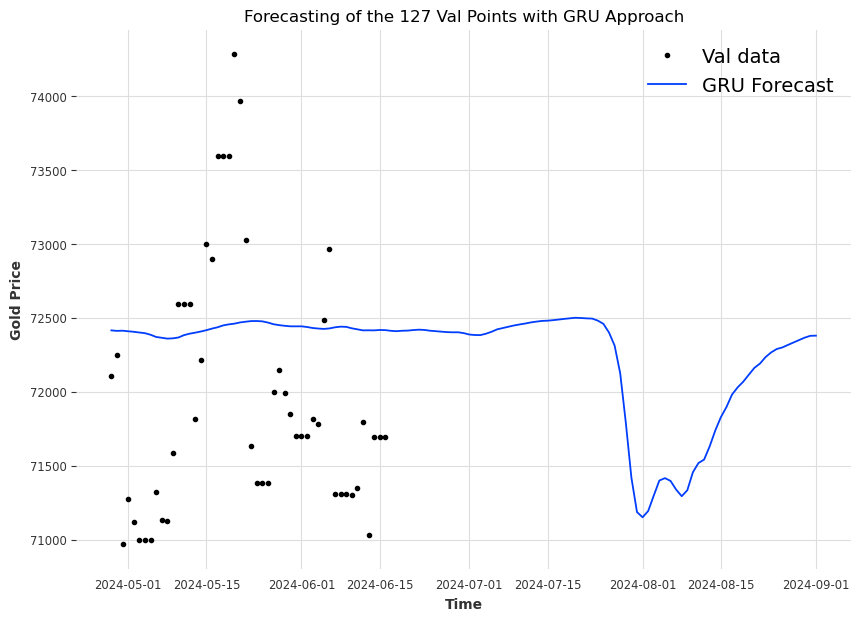

In [267]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=50)
plot_time_series(timesteps=X_val, values=preds_gru_es, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with GRU Approach')
plt.show()

In [268]:
gru_metrics_es = evaluate_preds(y_true=y_val,
                            y_pred=preds_gru_es)
gru_metrics_es

{'mae': np.float32(1182.2776),
 'mse': np.float32(2186364.5),
 'rmse': np.float32(1478.636),
 'mape': np.float32(1.675565)}

##### Evaluate Overfitting

In [269]:
preds_holdout_train_gru_es = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_gru_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.13it/s] 


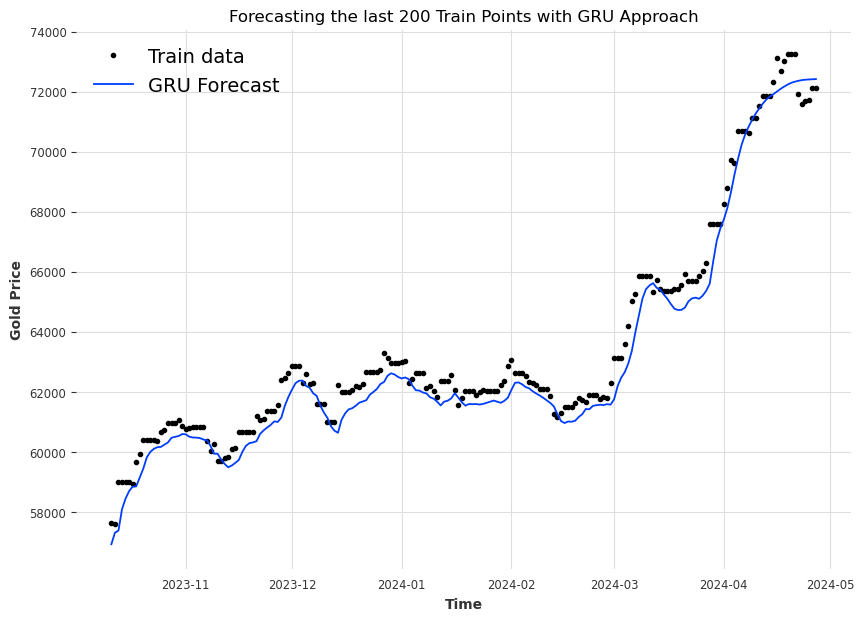

In [270]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_gru_es, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting the last 200 Train Points with GRU Approach')
plt.show()

In [271]:
gru_train_metrics_es = evaluate_preds(y_pred=preds_holdout_train_gru_es,
                                      y_true=y_train[-200:])
gru_train_metrics_es

{'mae': np.float32(523.54767),
 'mse': np.float32(386893.6),
 'rmse': np.float32(622.0077),
 'mape': np.float32(0.8223767)}

##### Persist Metrics

In [272]:
df_models_metrics_gru = pd.concat([
    df_models_metrics_gru,
    pd.DataFrame([{
        "Model": model_gru_es.name,  # aquí guardas el objeto completo
        "Train MAPE": gru_train_metrics_es['mape'],
        "Val MAPE": gru_metrics_es['mape'],
        "Train RMSE": gru_train_metrics_es['rmse'],
        "Val RMSE": gru_metrics_es['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [273]:
df_models_metrics_gru

Model  Train MAPE  Val MAPE  \
0                                 Default Model    0.429645  0.559498   
1                                   Small Model    0.357679  0.563155   
2                                 Complex Model    0.374745  0.585206   
3                       Regularized Small Model    0.350578  0.561829   
4                 Regularized Big Complex Model    0.943895  1.343591   
5  Early Stopping Regularized Big Complex Model    0.822377  1.675565   

   Train RMSE     Val RMSE  
0  352.030060   635.089417  
1  348.496094   607.545044  
2  330.565918   663.841309  
3  336.472076   604.504517  
4  699.174072  1189.527100  
5  622.007690  1478.635986

In [274]:
model_gru = RNNModel(
    model='GRU',
    input_chunk_length=30,
    training_length=30,
    hidden_dim=25,
    n_rnn_layers=1,
    dropout=0,
    batch_size=32,
    n_epochs=100
)

model_gru.fit(gold_price_darts_scaled_train_val, future_covariates=gold_price_exogenus_darts_scaled_train_val)

Epoch 99: 100%|██████████| 121/121 [00:00<00:00, 132.87it/s, train_loss=4.4e-5]  


RNNModel(model=GRU, hidden_dim=25, n_rnn_layers=1, dropout=0, training_length=30, input_chunk_length=30, batch_size=32, n_epochs=100)

In [275]:
preds_gru = make_predictions_rolling_one_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_gru)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.06it/s]


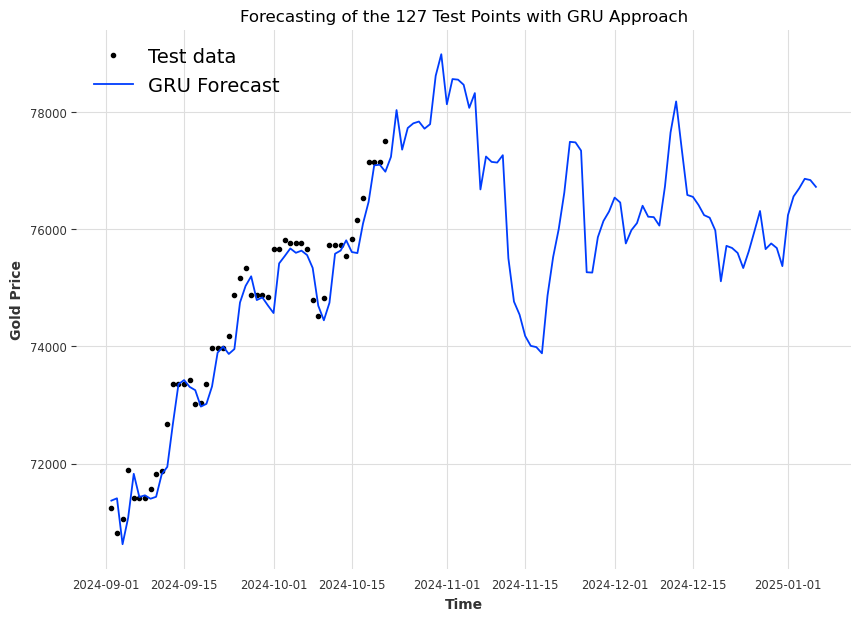

In [276]:
# Plot GRU forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=preds_gru, format='-', label='GRU Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with GRU Approach')
plt.show()

In [277]:
gru_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_gru)
gru_metrics

{'mae': np.float32(370.12402),
 'mse': np.float32(277915.03),
 'rmse': np.float32(527.17645),
 'mape': np.float32(0.4877746)}

### N-BEATSx

In [278]:
df_models_metrics_nbeatsx = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [279]:
model_nbeatsx_default = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx_default.name = 'Default Model'

model_nbeatsx_default.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:06<00:00, 17.73it/s, train_loss=9.1e-5]  


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [280]:
from utils.preds import make_predictions_rolling_one_past_covariates_darts

In [281]:
preds_nbeatsx_default = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.02it/s]


##### Evaluate Predictions

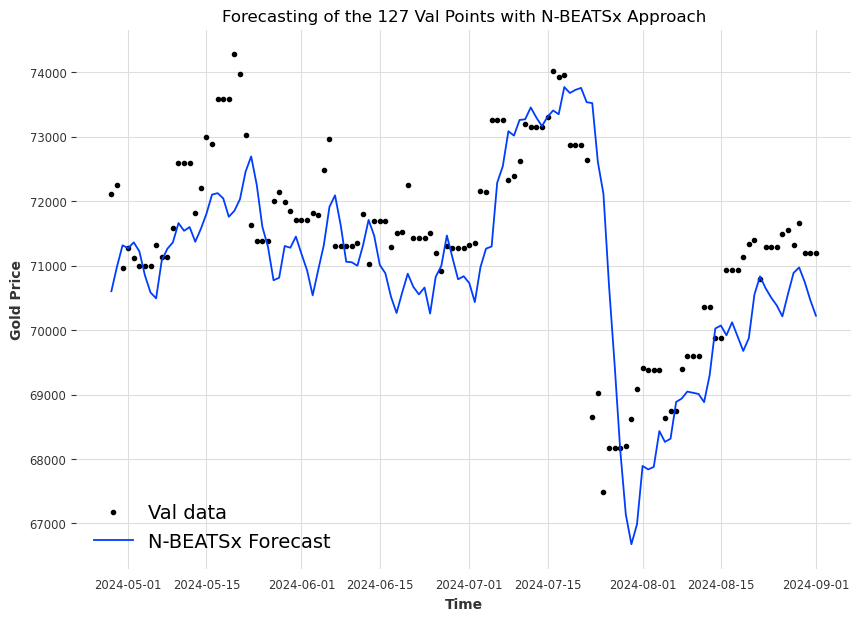

In [282]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx_default, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [283]:
nbeatsx_metrics_default = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx_default)
nbeatsx_metrics_default

{'mae': np.float32(869.12036),
 'mse': np.float32(1328349.4),
 'rmse': np.float32(1152.5404),
 'mape': np.float32(1.2224306)}

##### Evaluate Overfitting

In [284]:
preds_holdout_train_nbeatsx_default = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.15it/s]


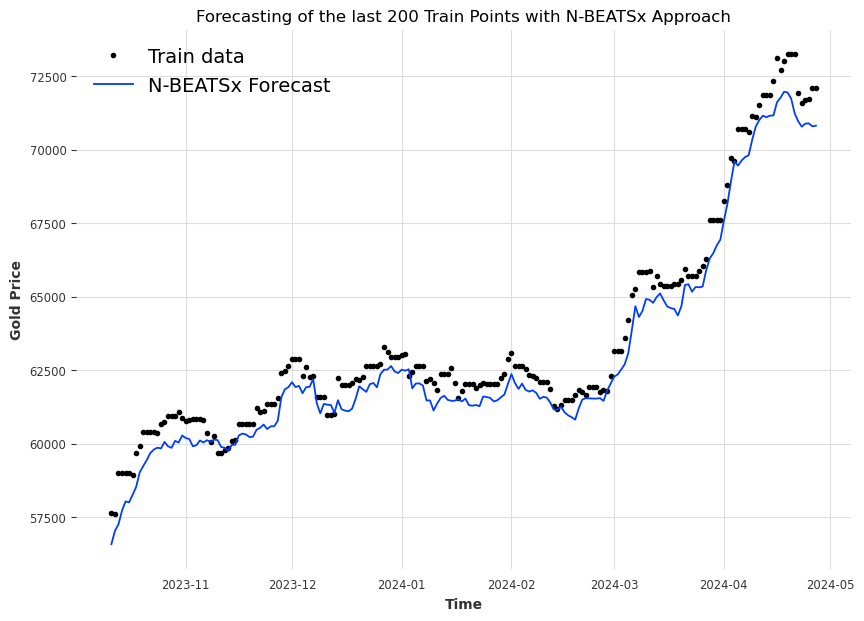

In [285]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx_default, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [286]:
nbeatsx_train_metrics_default = evaluate_preds(y_pred=preds_holdout_train_nbeatsx_default,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics_default

{'mae': np.float32(667.46375),
 'mse': np.float32(558330.2),
 'rmse': np.float32(747.21497),
 'mape': np.float32(1.0434085)}

##### Persist Metrics

In [287]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx_default.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics_default['mape'],
        "Val MAPE": nbeatsx_metrics_default['mape'],
        "Train RMSE": nbeatsx_train_metrics_default['rmse'],
        "Val RMSE": nbeatsx_metrics_default['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11352\886966941.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [288]:
model_nbeatsx_small = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=15,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx_small.name = 'Small Model'

model_nbeatsx_small.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:02<00:00, 42.33it/s, train_loss=7.8e-5]  


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=2, layer_widths=64, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [289]:
preds_nbeatsx_small = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.85it/s] 


##### Evaluate Predictions

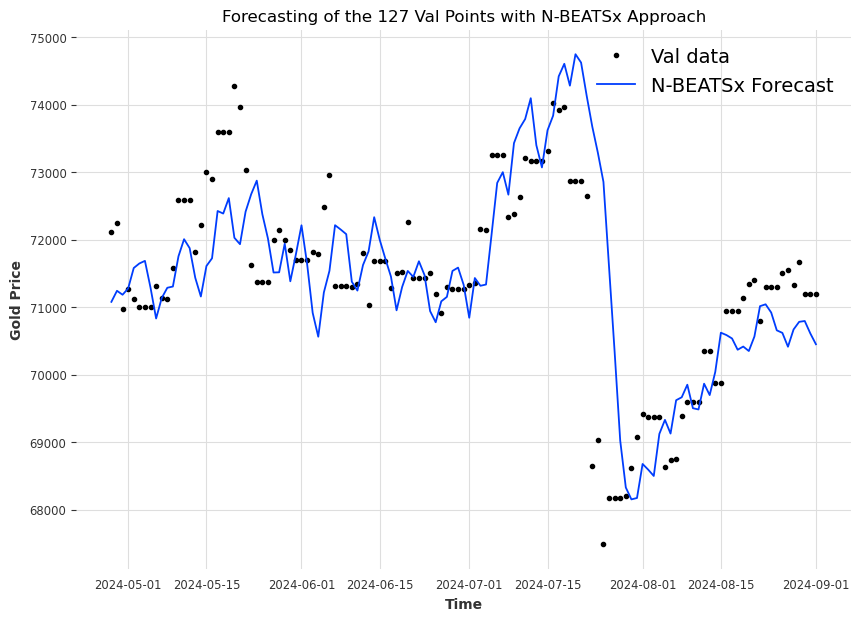

In [290]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx_small, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [291]:
nbeatsx_metrics_small = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx_small)
nbeatsx_metrics_small

{'mae': np.float32(760.47656),
 'mse': np.float32(1269803.8),
 'rmse': np.float32(1126.8557),
 'mape': np.float32(1.0700454)}

##### Evaluate Overfitting

In [292]:
preds_holdout_train_nbeatsx_small = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.90it/s]


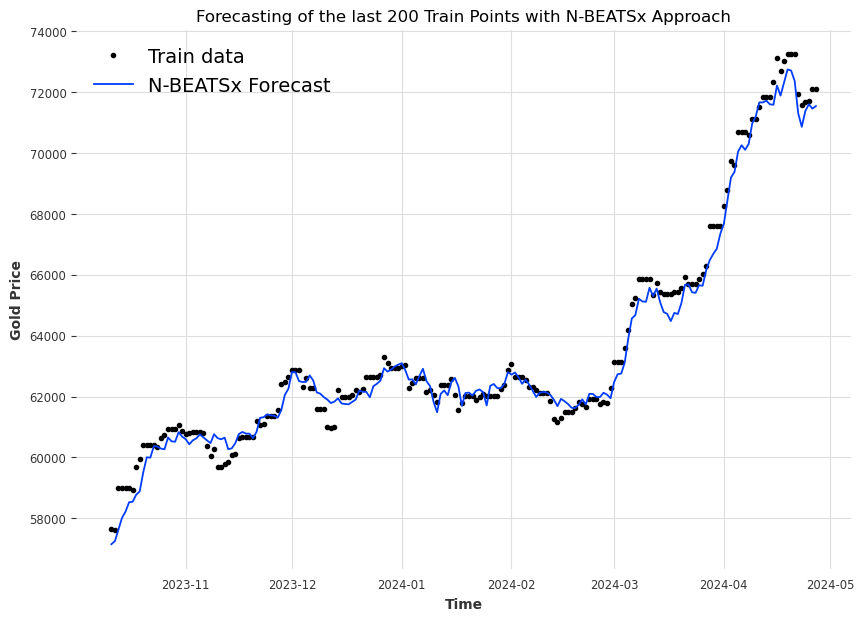

In [293]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx_small, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [294]:
nbeatsx_train_metrics_small = evaluate_preds(y_pred=preds_holdout_train_nbeatsx_small,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics_small

{'mae': np.float32(351.82617),
 'mse': np.float32(195038.16),
 'rmse': np.float32(441.63126),
 'mape': np.float32(0.55213386)}

##### Persist Metrics

In [295]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx_small.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics_small['mape'],
        "Val MAPE": nbeatsx_metrics_small['mape'],
        "Train RMSE": nbeatsx_train_metrics_small['rmse'],
        "Val RMSE": nbeatsx_metrics_small['rmse']
    }])
], ignore_index=True)

#### Smaller Model

##### Create Model

In [296]:
model_nbeatsx_smaller = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=9,
    num_blocks=1,
    num_layers=2,
    layer_widths=32,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx_smaller.name = 'Smaller Model'

model_nbeatsx_smaller.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:01<00:00, 69.82it/s, train_loss=0.000135]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=9, num_blocks=1, num_layers=2, layer_widths=32, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [297]:
preds_nbeatsx_smaller = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx_smaller)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]


##### Evaluate Predictions

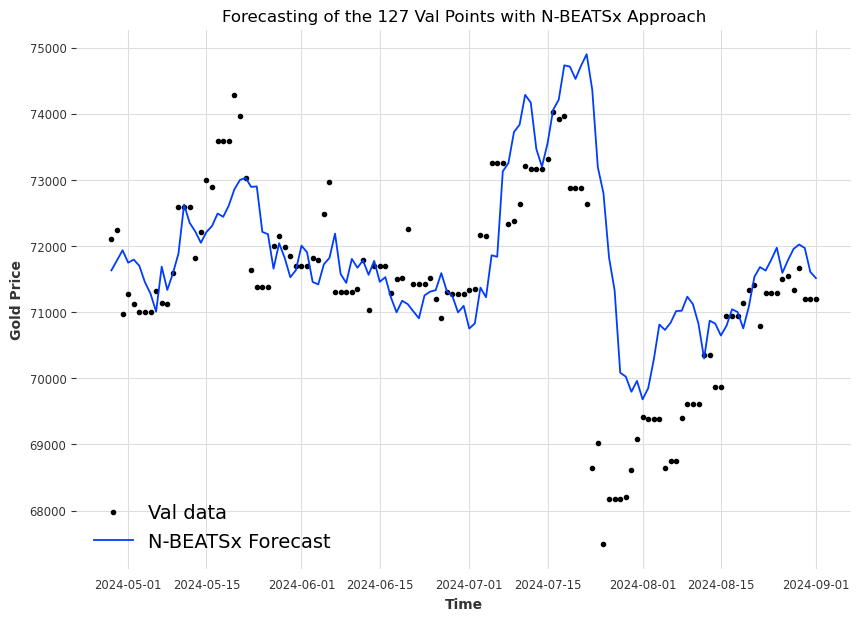

In [298]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx_smaller, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [299]:
nbeatsx_metrics_smaller = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx_smaller)
nbeatsx_metrics_smaller

{'mae': np.float32(811.11127),
 'mse': np.float32(1522426.6),
 'rmse': np.float32(1233.8666),
 'mape': np.float32(1.1486162)}

##### Evaluate Overfitting

In [300]:
preds_holdout_train_nbeatsx_smaller = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx_smaller)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.10it/s]


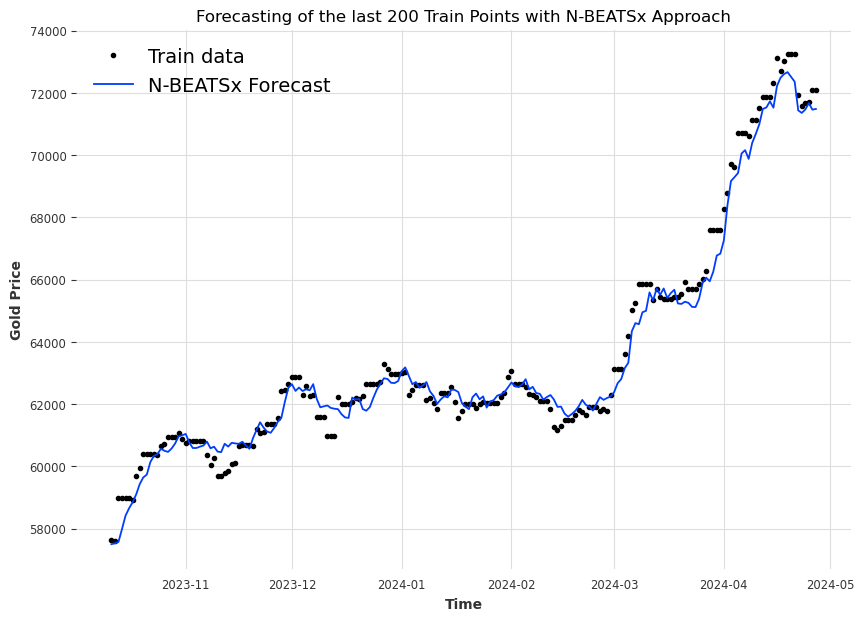

In [301]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx_smaller, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [302]:
nbeatsx_train_metrics_smaller = evaluate_preds(y_pred=preds_holdout_train_nbeatsx_smaller,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics_smaller

{'mae': np.float32(377.01553),
 'mse': np.float32(235917.23),
 'rmse': np.float32(485.7131),
 'mape': np.float32(0.5891323)}

##### Persist Metrics

In [303]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx_smaller.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics_smaller['mape'],
        "Val MAPE": nbeatsx_metrics_smaller['mape'],
        "Train RMSE": nbeatsx_train_metrics_smaller['rmse'],
        "Val RMSE": nbeatsx_metrics_smaller['rmse']
    }])
], ignore_index=True)

#### Regularized Small Model

##### Create Model

In [304]:
model_nbeatsx_reg = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=15,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0.2,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx_reg.name = 'Regularized Small Model'

model_nbeatsx_reg.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:02<00:00, 44.02it/s, train_loss=0.000203]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=2, layer_widths=64, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [305]:
preds_nbeatsx_reg = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx_reg)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.75it/s]


##### Evaluate Predictions

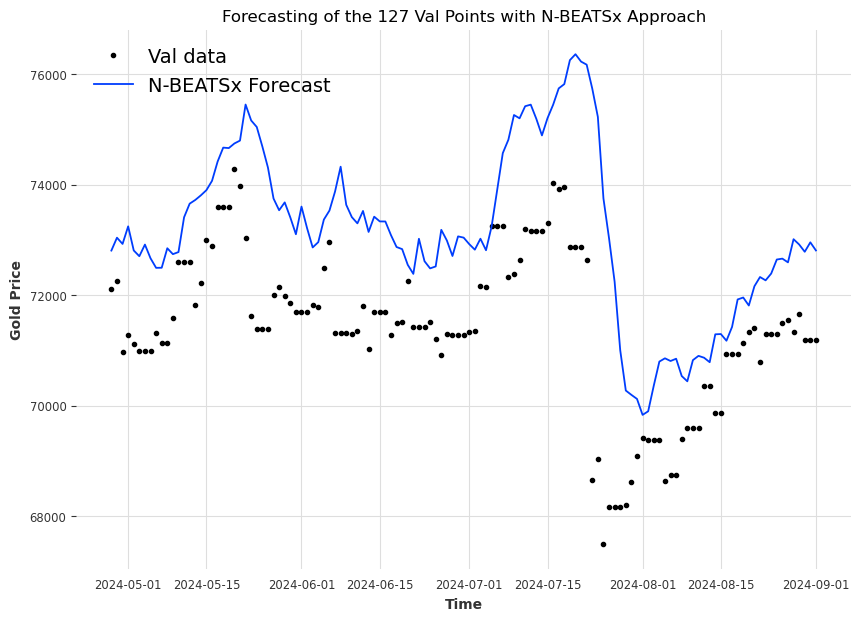

In [306]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx_reg, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [307]:
nbeatsx_metrics_reg = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx_reg)
nbeatsx_metrics_reg

{'mae': np.float32(1712.468),
 'mse': np.float32(4197473.5),
 'rmse': np.float32(2048.7737),
 'mape': np.float32(2.409114)}

##### Evaluate Overfitting

In [308]:
preds_holdout_train_nbeatsx_reg = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx_reg)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.39it/s]


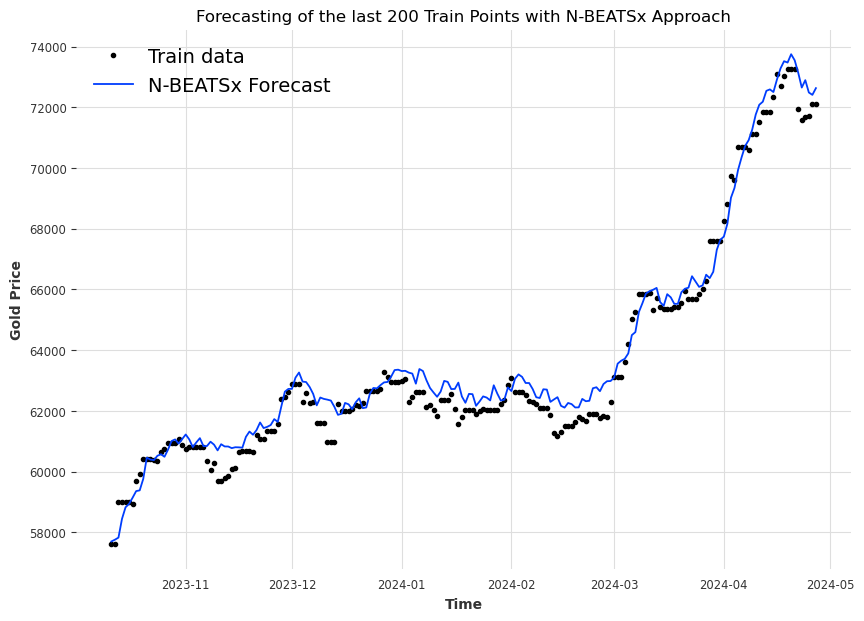

In [309]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx_reg, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [310]:
nbeatsx_train_metrics_reg = evaluate_preds(y_pred=preds_holdout_train_nbeatsx_reg,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics_reg

{'mae': np.float32(453.48804),
 'mse': np.float32(311649.03),
 'rmse': np.float32(558.2554),
 'mape': np.float32(0.7159172)}

##### Persist Metrics

In [311]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx_reg.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics_reg['mape'],
        "Val MAPE": nbeatsx_metrics_reg['mape'],
        "Train RMSE": nbeatsx_train_metrics_reg['rmse'],
        "Val RMSE": nbeatsx_metrics_reg['rmse']
    }])
], ignore_index=True)

#### Early Stopping Small Model

##### Create Model

In [312]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_nbeatsx_es_small = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=15,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_nbeatsx_es_small.name = 'Early Stopping Small Model'

model_nbeatsx_es_small.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 43: 100%|██████████| 117/117 [00:02<00:00, 42.31it/s, train_loss=0.0004]  


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=2, layer_widths=64, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000230CEA63490>]})

##### Make Predictions

In [313]:
preds_nbeatsx_es_small = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx_es_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.90it/s]


##### Evaluate Predictions

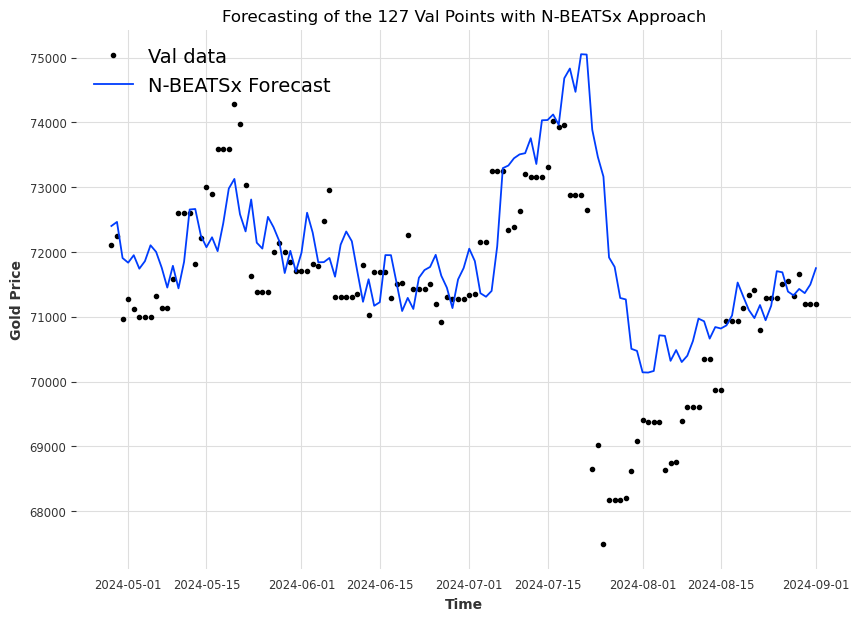

In [314]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx_es_small, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [315]:
nbeatsx_metrics_es_small = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx_es_small)
nbeatsx_metrics_es_small

{'mae': np.float32(873.16327),
 'mse': np.float32(1673787.5),
 'rmse': np.float32(1293.7494),
 'mape': np.float32(1.2366154)}

##### Evaluate Overfitting

In [316]:
preds_holdout_train_nbeatsx_es_small = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx_es_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.00it/s]


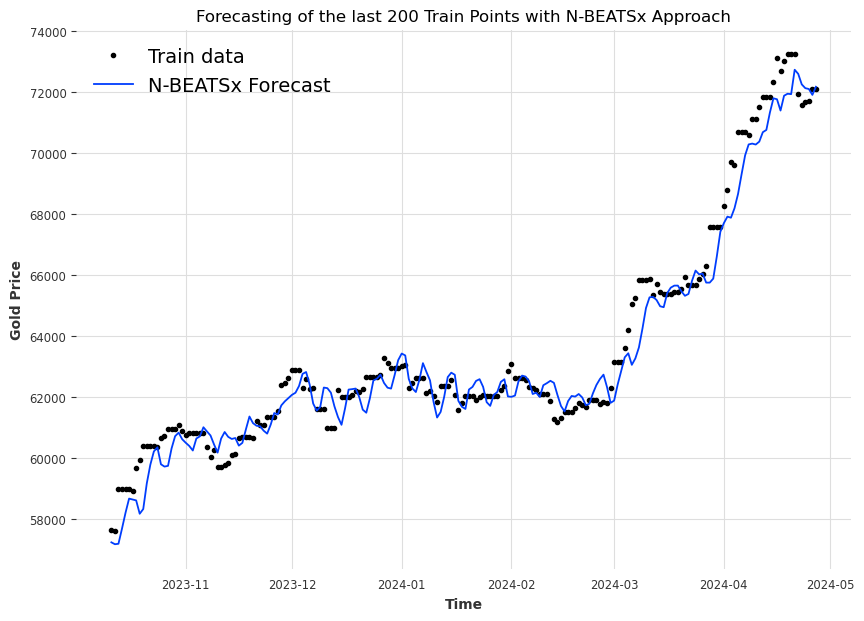

In [317]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx_es_small, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [318]:
nbeatsx_train_metrics_es_small = evaluate_preds(y_pred=preds_holdout_train_nbeatsx_es_small,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics_es_small

{'mae': np.float32(574.48846),
 'mse': np.float32(554147.25),
 'rmse': np.float32(744.41064),
 'mape': np.float32(0.89684373)}

##### Persist Metrics

In [319]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx_es_small.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics_es_small['mape'],
        "Val MAPE": nbeatsx_metrics_es_small['mape'],
        "Train RMSE": nbeatsx_train_metrics_es_small['rmse'],
        "Val RMSE": nbeatsx_metrics_es_small['rmse']
    }])
], ignore_index=True)

#### Early Stopping Default Model

##### Create Model

In [320]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_nbeatsx_es = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    expansion_coefficient_dim=5,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_nbeatsx_es.name = 'Early Stopping Default Model'

model_nbeatsx_es.fit(series=gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 63: 100%|██████████| 117/117 [00:06<00:00, 18.00it/s, train_loss=0.000218]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002309BE24C10>]})

##### Make Predictions

In [321]:
preds_nbeatsx_es = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.40it/s]


##### Evaluate Predictions

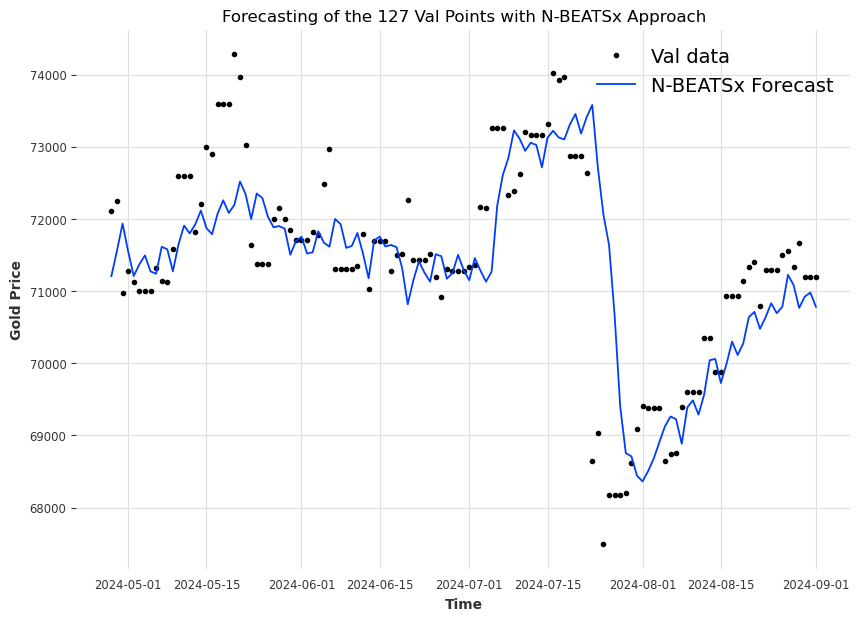

In [322]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_nbeatsx_es, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with N-BEATSx Approach')
plt.show()

In [323]:
nbeatsx_metrics_es = evaluate_preds(y_true=y_val,
                            y_pred=preds_nbeatsx_es)
nbeatsx_metrics_es

{'mae': np.float32(665.768),
 'mse': np.float32(1048020.4),
 'rmse': np.float32(1023.72864),
 'mape': np.float32(0.93777364)}

##### Evaluate Overfitting

In [324]:
preds_holdout_train_nbeatsx_es = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_nbeatsx_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.73it/s]


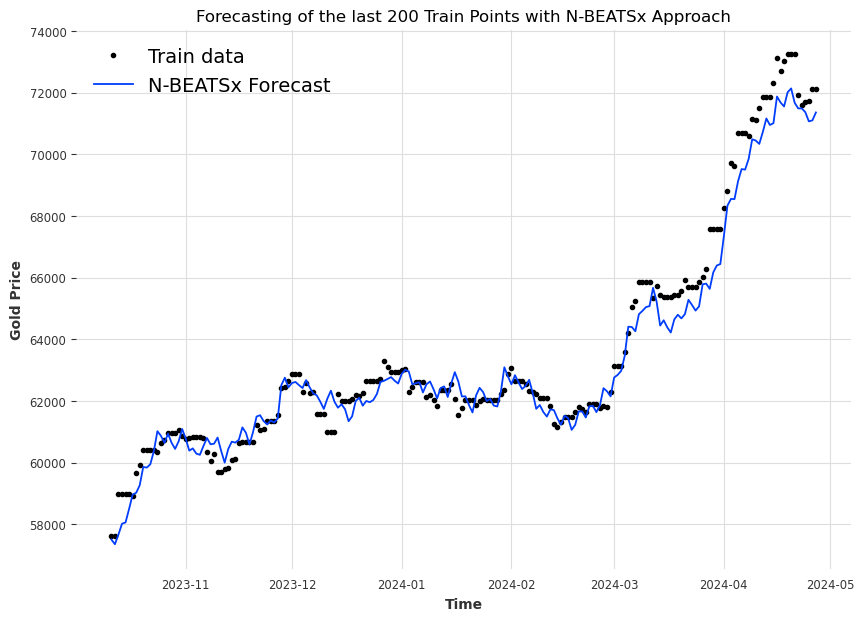

In [325]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_nbeatsx_es, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with N-BEATSx Approach')
plt.show()

In [326]:
nbeatsx_train_metrics_es = evaluate_preds(y_pred=preds_holdout_train_nbeatsx_es,
                                      y_true=y_train[-200:])
nbeatsx_train_metrics_es

{'mae': np.float32(487.76794),
 'mse': np.float32(391733.38),
 'rmse': np.float32(625.88605),
 'mape': np.float32(0.75227284)}

##### Persist Metrics

In [327]:
df_models_metrics_nbeatsx = pd.concat([
    df_models_metrics_nbeatsx,
    pd.DataFrame([{
        "Model": model_nbeatsx_es.name,  # aquí guardas el objeto completo
        "Train MAPE": nbeatsx_train_metrics_es['mape'],
        "Val MAPE": nbeatsx_metrics_es['mape'],
        "Train RMSE": nbeatsx_train_metrics_es['rmse'],
        "Val RMSE": nbeatsx_metrics_es['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [328]:
df_models_metrics_nbeatsx

Model  Train MAPE  Val MAPE  Train RMSE     Val RMSE
0                 Default Model    1.043409  1.222431  747.214966  1152.540405
1                   Small Model    0.552134  1.070045  441.631256  1126.855713
2                 Smaller Model    0.589132  1.148616  485.713104  1233.866577
3       Regularized Small Model    0.715917  2.409114  558.255371  2048.773682
4    Early Stopping Small Model    0.896844  1.236615  744.410645  1293.749390
5  Early Stopping Default Model    0.752273  0.937774  625.886047  1023.728638

In [329]:
model_nbeatsx = NBEATSModel(
    input_chunk_length=30, # window_size
    output_chunk_length=1, # horizon
    output_chunk_shift=0,
    generic_architecture=True,
    num_stacks=15,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    expansion_coefficient_dim=3,
    trend_polynomial_degree=2,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_nbeatsx.fit(series=gold_price_darts_scaled_train_val, past_covariates=gold_price_exogenus_darts_scaled_train_val)

Epoch 99: 100%|██████████| 121/121 [00:02<00:00, 45.74it/s, train_loss=8.85e-5] 


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=15, num_blocks=1, num_layers=2, layer_widths=64, expansion_coefficient_dim=3, trend_polynomial_degree=2, dropout=0, activation=ReLU, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

In [330]:
preds_nbeatsx = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_nbeatsx)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.19it/s]


In [331]:
nbeatsx_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_nbeatsx)
nbeatsx_metrics

{'mae': np.float32(2087.6758),
 'mse': np.float32(5711837.0),
 'rmse': np.float32(2389.945),
 'mape': np.float32(2.7285392)}

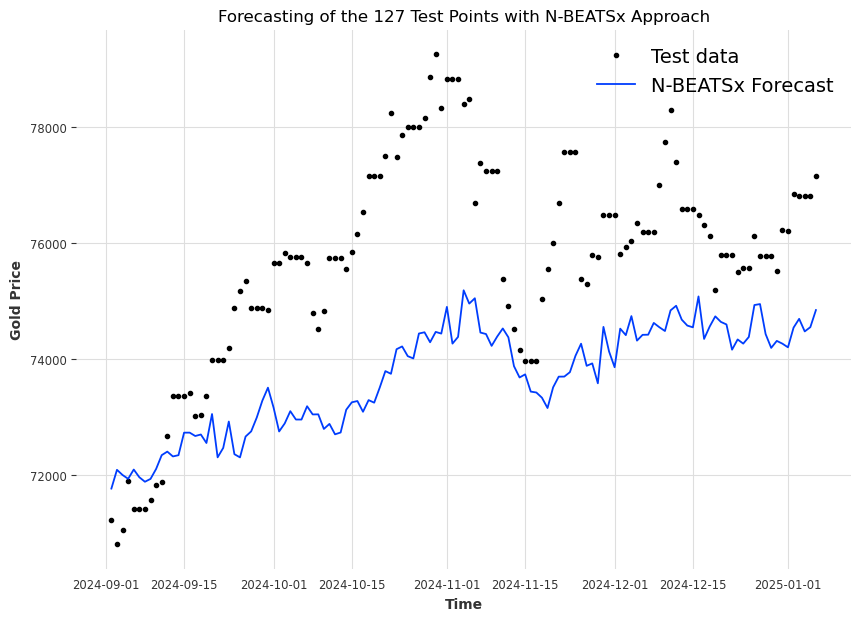

In [332]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_nbeatsx, format='-', label='N-BEATSx Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with N-BEATSx Approach')
plt.show()

### TCN (Temporal Convolutional Networks)

In [333]:
from darts.models import TCNModel

In [334]:
df_models_metrics_tcn = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [335]:
model_tcn_default = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=3,
    num_filters=3,
    num_layers=None,
    dilation_base=2,
    weight_norm=False,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn_default.name = 'Default Model'

model_tcn_default.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 136.98it/s, train_loss=3.71e-5] 


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [336]:
preds_tcn_default = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]


##### Evaluate Predictions

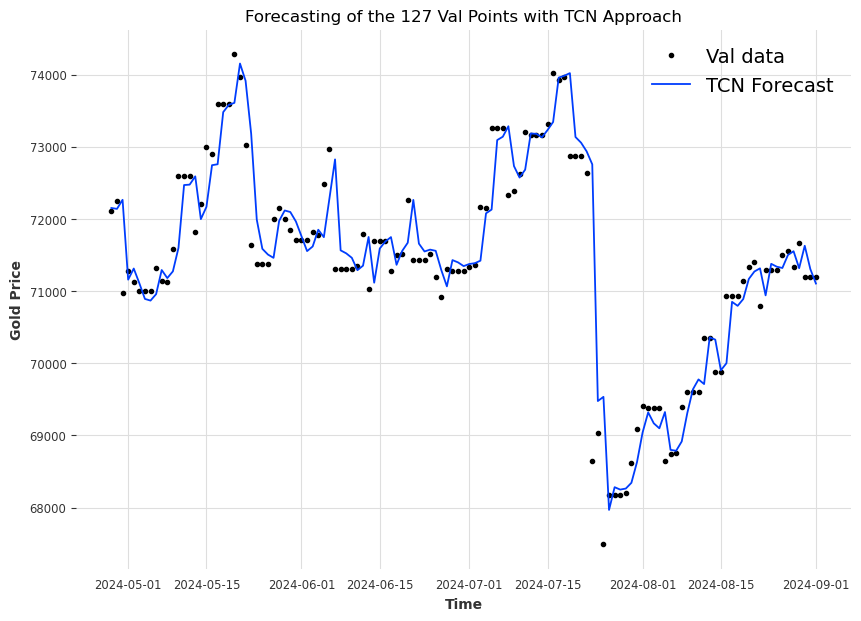

In [337]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn_default, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [338]:
tcn_metrics_default = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn_default)
tcn_metrics_default

{'mae': np.float32(355.6104),
 'mse': np.float32(364402.62),
 'rmse': np.float32(603.6577),
 'mape': np.float32(0.4998045)}

##### Evaluate Overfitting

In [339]:
preds_holdout_train_tcn_default = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.01it/s]


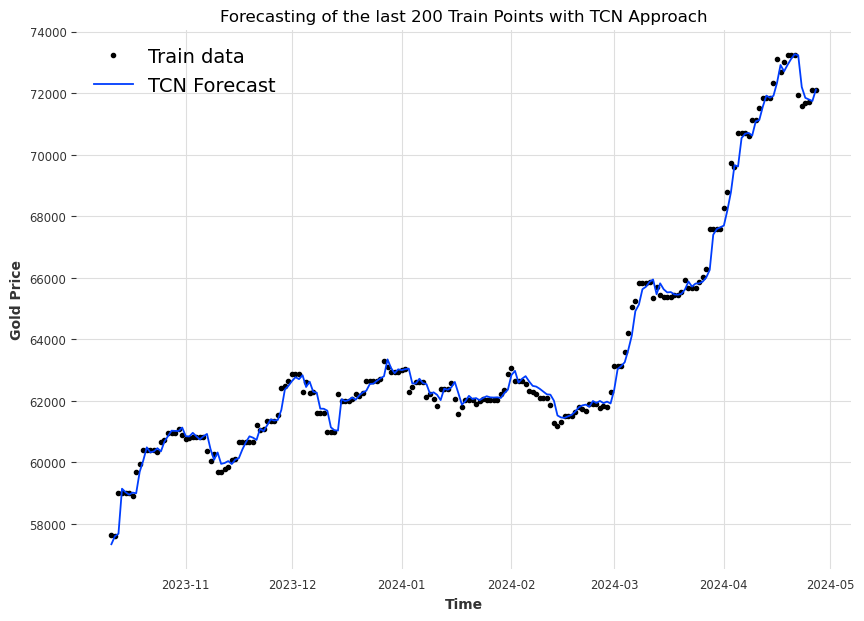

In [340]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn_default, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [341]:
tcn_train_metrics_default = evaluate_preds(y_pred=preds_holdout_train_tcn_default,
                                      y_true=y_train[-200:])
tcn_train_metrics_default

{'mae': np.float32(231.06383),
 'mse': np.float32(121163.06),
 'rmse': np.float32(348.08484),
 'mape': np.float32(0.36120623)}

##### Persist Metrics

In [342]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn_default.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics_default['mape'],
        "Val MAPE": tcn_metrics_default['mape'],
        "Train RMSE": tcn_train_metrics_default['rmse'],
        "Val RMSE": tcn_metrics_default['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11352\133349336.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Small Model

##### Create Model

In [343]:
model_tcn_small = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=2,
    num_filters=2,
    num_layers=None,
    dilation_base=1,
    weight_norm=False,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn_small.name = 'Small Model'

model_tcn_small.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:01<00:00, 77.82it/s, train_loss=4.47e-5] 


TCNModel(output_chunk_shift=0, kernel_size=2, num_filters=2, num_layers=None, dilation_base=1, weight_norm=False, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [344]:
preds_tcn_small = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.94it/s]


##### Evaluate Predictions

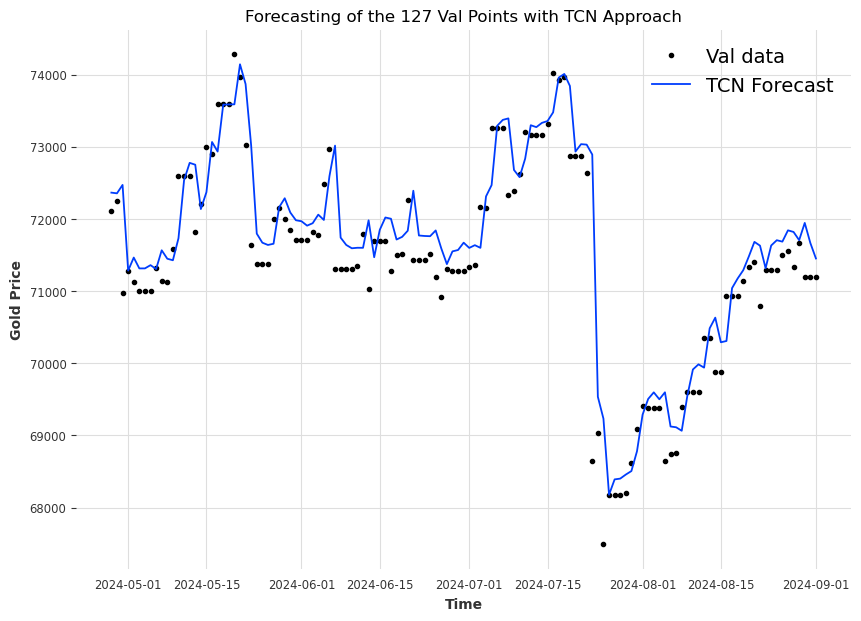

In [345]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn_small, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [346]:
tcn_metrics_small = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn_small)
tcn_metrics_small

{'mae': np.float32(396.46997),
 'mse': np.float32(382344.03),
 'rmse': np.float32(618.3397),
 'mape': np.float32(0.5580929)}

##### Evaluate Overfitting

In [347]:
preds_holdout_train_tcn_small = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.79it/s] 


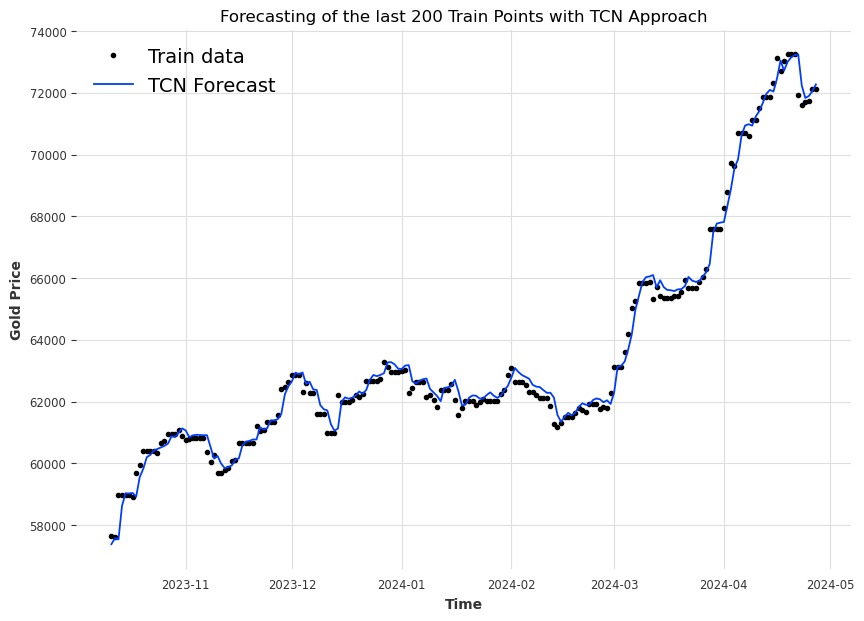

In [348]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn_small, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [349]:
tcn_train_metrics_small = evaluate_preds(y_pred=preds_holdout_train_tcn_small,
                                      y_true=y_train[-200:])
tcn_train_metrics_small

{'mae': np.float32(252.95828),
 'mse': np.float32(127838.7),
 'rmse': np.float32(357.54538),
 'mape': np.float32(0.39738816)}

##### Persist Metrics

In [350]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn_small.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics_small['mape'],
        "Val MAPE": tcn_metrics_small['mape'],
        "Train RMSE": tcn_train_metrics_small['rmse'],
        "Val RMSE": tcn_metrics_small['rmse']
    }])
], ignore_index=True)

#### Complex Model

##### Create Model

In [351]:
model_tcn_complex = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=4,
    num_filters=4,
    num_layers=4,
    dilation_base=3,
    weight_norm=True,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn_complex.name = 'Complex Model'

model_tcn_complex.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 122.99it/s, train_loss=3.91e-5]


TCNModel(output_chunk_shift=0, kernel_size=4, num_filters=4, num_layers=4, dilation_base=3, weight_norm=True, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [352]:
preds_tcn_complex = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.75it/s]


##### Evaluate Predictions

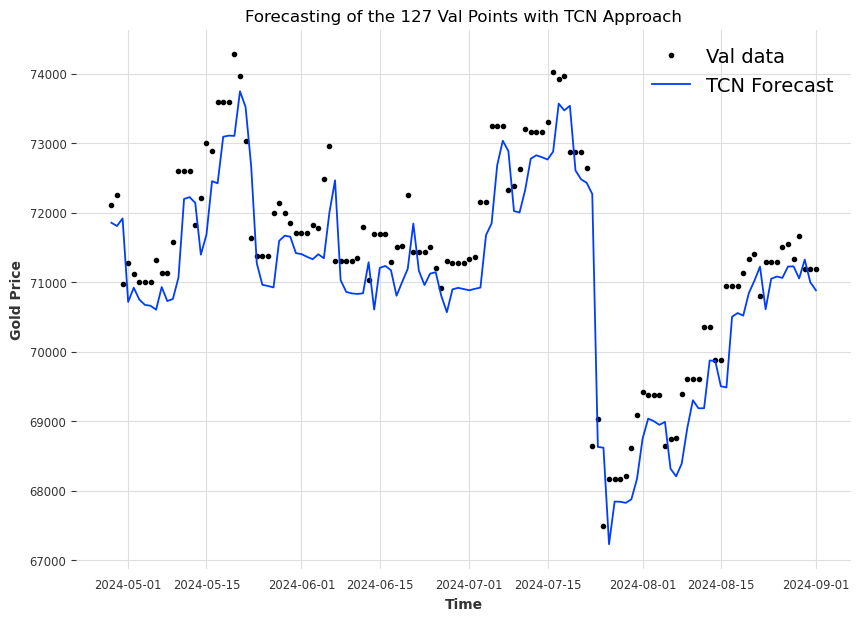

In [353]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn_complex, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [354]:
tcn_metrics_complex = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn_complex)
tcn_metrics_complex

{'mae': np.float32(559.28406),
 'mse': np.float32(491450.1),
 'rmse': np.float32(701.03503),
 'mape': np.float32(0.7838551)}

##### Evaluate Overfitting

In [355]:
preds_holdout_train_tcn_complex = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]


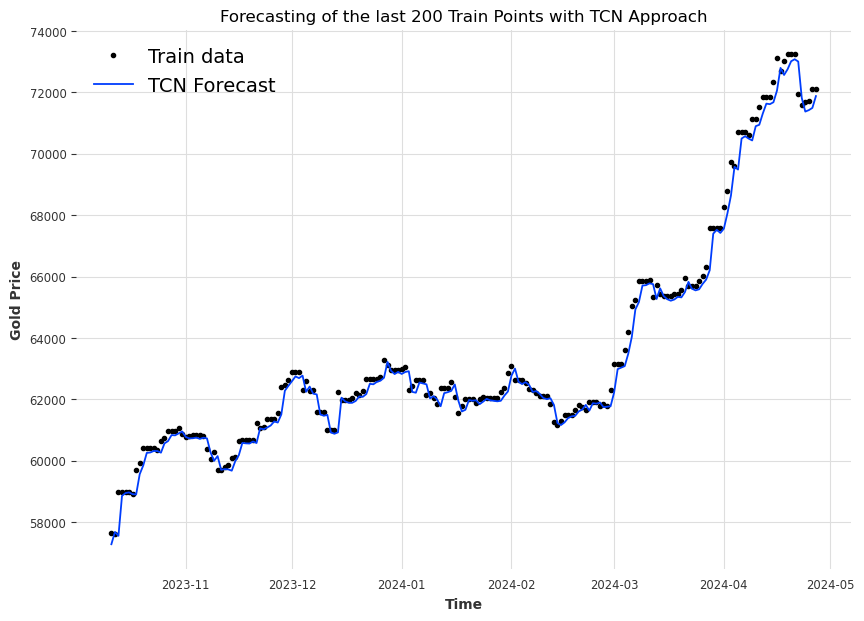

In [356]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn_complex, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [357]:
tcn_train_metrics_complex = evaluate_preds(y_pred=preds_holdout_train_tcn_complex,
                                      y_true=y_train[-200:])
tcn_train_metrics_complex

{'mae': np.float32(267.422),
 'mse': np.float32(144122.31),
 'rmse': np.float32(379.63446),
 'mape': np.float32(0.41576317)}

##### Persist Metrics

In [358]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn_complex.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics_complex['mape'],
        "Val MAPE": tcn_metrics_complex['mape'],
        "Train RMSE": tcn_train_metrics_complex['rmse'],
        "Val RMSE": tcn_metrics_complex['rmse']
    }])
], ignore_index=True)

#### Less Complex but still Complex

##### Create Model

In [359]:
model_tcn_less_complex = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=4,
    num_filters=4,
    num_layers=None,
    dilation_base=3,
    weight_norm=False,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn_less_complex.name = 'Less Complex Model'

model_tcn_less_complex.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 144.80it/s, train_loss=4.05e-5] 


TCNModel(output_chunk_shift=0, kernel_size=4, num_filters=4, num_layers=None, dilation_base=3, weight_norm=False, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [360]:
preds_tcn_less_complex = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn_less_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]


##### Evaluate Predictions

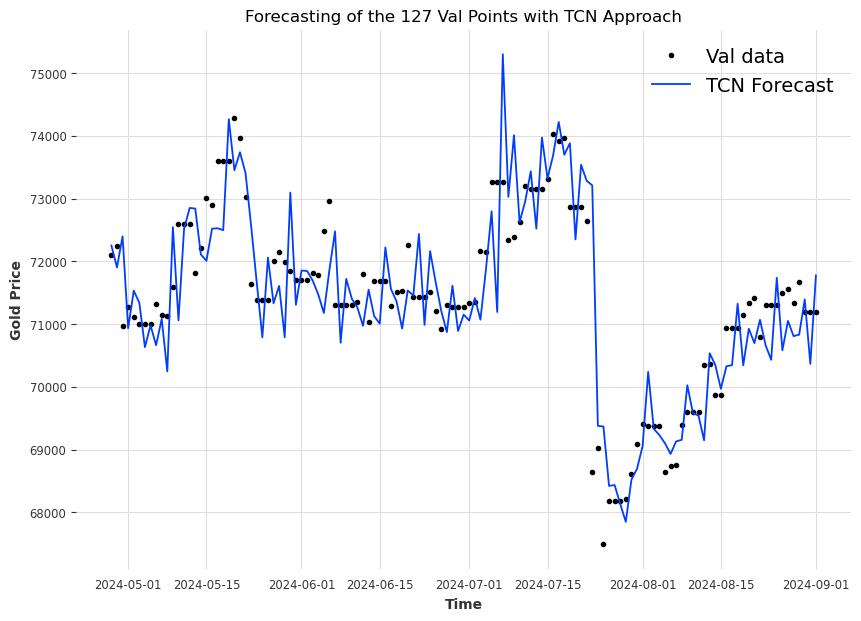

In [361]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn_less_complex, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [362]:
tcn_metrics_less_complex = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn_less_complex)
tcn_metrics_less_complex

{'mae': np.float32(577.7305),
 'mse': np.float32(635586.1),
 'rmse': np.float32(797.2366),
 'mape': np.float32(0.8084824)}

##### Evaluate Overfitting

In [363]:
preds_holdout_train_tcn_less_complex = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn_less_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.74it/s]


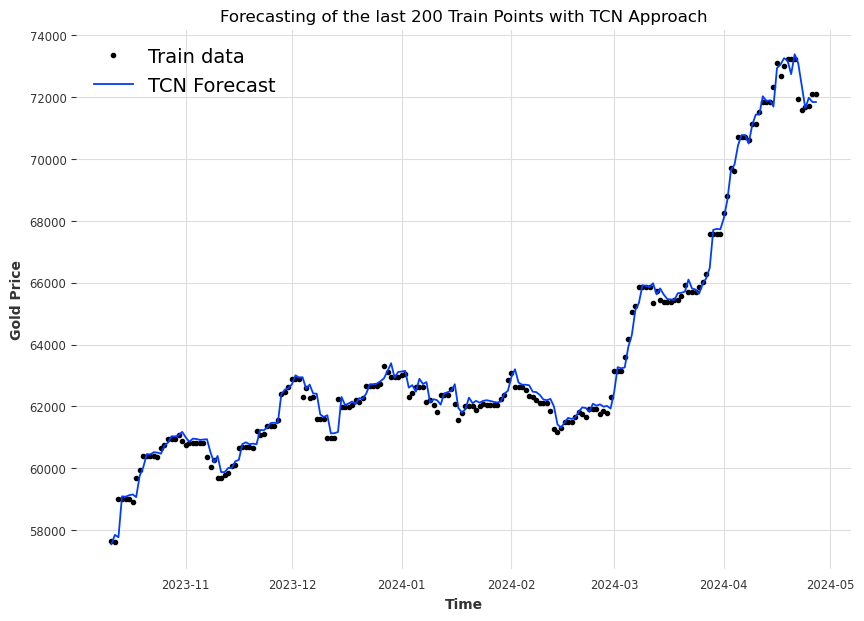

In [364]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn_less_complex, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [365]:
tcn_train_metrics_less_complex = evaluate_preds(y_pred=preds_holdout_train_tcn_less_complex,
                                      y_true=y_train[-200:])
tcn_train_metrics_less_complex

{'mae': np.float32(215.74506),
 'mse': np.float32(94643.32),
 'rmse': np.float32(307.64154),
 'mape': np.float32(0.33956358)}

##### Persist Metrics

In [366]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn_less_complex.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics_less_complex['mape'],
        "Val MAPE": tcn_metrics_less_complex['mape'],
        "Train RMSE": tcn_train_metrics_less_complex['rmse'],
        "Val RMSE": tcn_metrics_less_complex['rmse']
    }])
], ignore_index=True)

#### Regularized Default

##### Create Model

In [367]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_tcn_reg = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=3,
    num_filters=3,
    num_layers=None,
    dilation_base=2,
    weight_norm=False,
    dropout=0.2,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn_reg.name = 'Regularized Default Model'

model_tcn_reg.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 123.12it/s, train_loss=3.19e-5] 


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [368]:
preds_tcn_reg = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn_reg)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 283.28it/s]


##### Evaluate Predictions

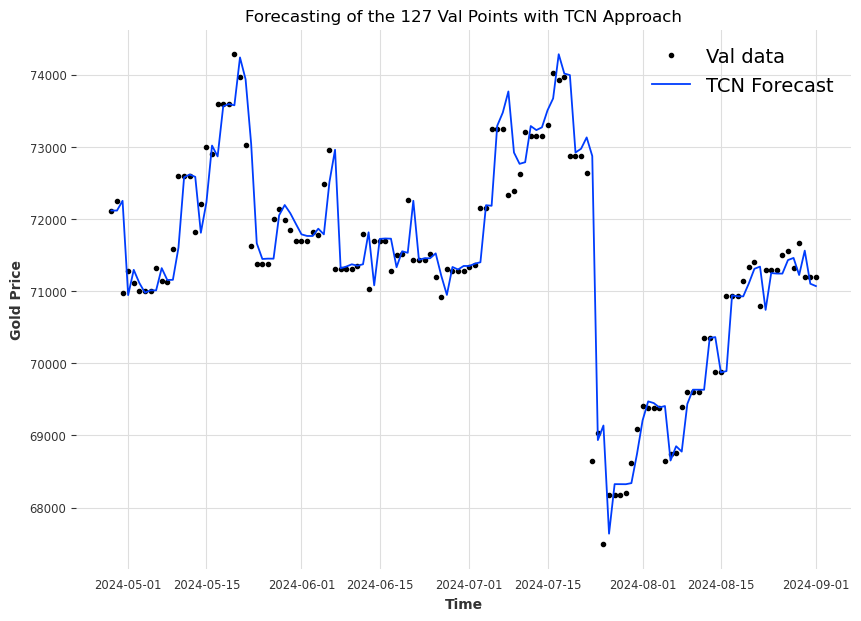

In [369]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn_reg, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [370]:
tcn_metrics_reg = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn_reg)
tcn_metrics_reg

{'mae': np.float32(342.01715),
 'mse': np.float32(367835.03),
 'rmse': np.float32(606.494),
 'mape': np.float32(0.48047927)}

##### Evaluate Overfitting

In [371]:
preds_holdout_train_tcn_reg = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn_reg)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]


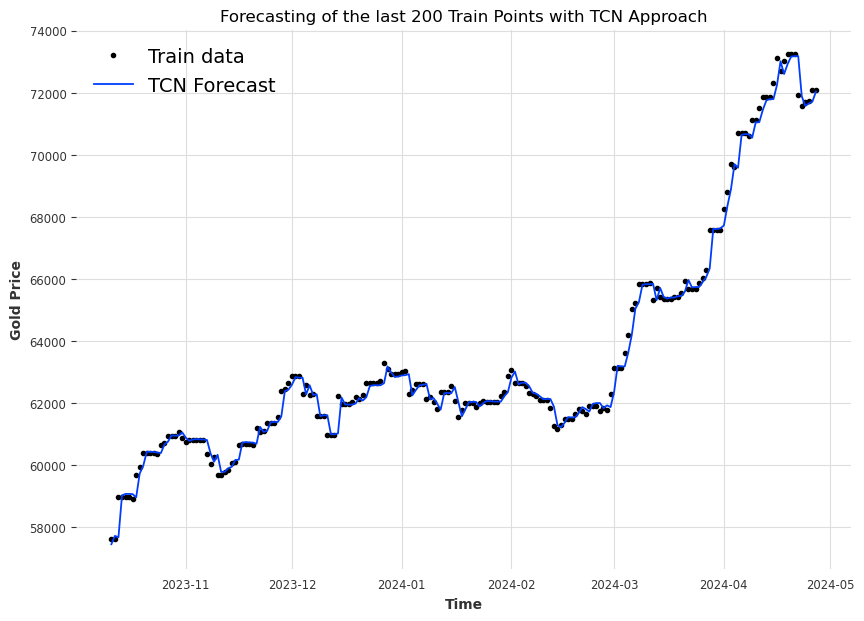

In [372]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn_reg, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [373]:
tcn_train_metrics_reg = evaluate_preds(y_pred=preds_holdout_train_tcn_reg,
                                      y_true=y_train[-200:])
tcn_train_metrics_reg

{'mae': np.float32(216.76588),
 'mse': np.float32(113372.44),
 'rmse': np.float32(336.70825),
 'mape': np.float32(0.33806747)}

##### Persist Metrics

In [374]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn_reg.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics_reg['mape'],
        "Val MAPE": tcn_metrics_reg['mape'],
        "Train RMSE": tcn_train_metrics_reg['rmse'],
        "Val RMSE": tcn_metrics_reg['rmse']
    }])
], ignore_index=True)

#### Early Stopping Regularized Default Model

##### Create Model 

In [375]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_tcn_es = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=3,
    num_filters=3,
    num_layers=None,
    dilation_base=2,
    weight_norm=False,
    dropout=0.2,
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_tcn_es.name = 'Early Stopping Regularized Default Model'

model_tcn_es.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

Epoch 99: 100%|██████████| 117/117 [00:00<00:00, 126.24it/s, train_loss=3.19e-5] 


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000230CD5FBF40>]})

##### Make Predictions

In [376]:
preds_tcn_es = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.08it/s]


##### Evaluate Predictions

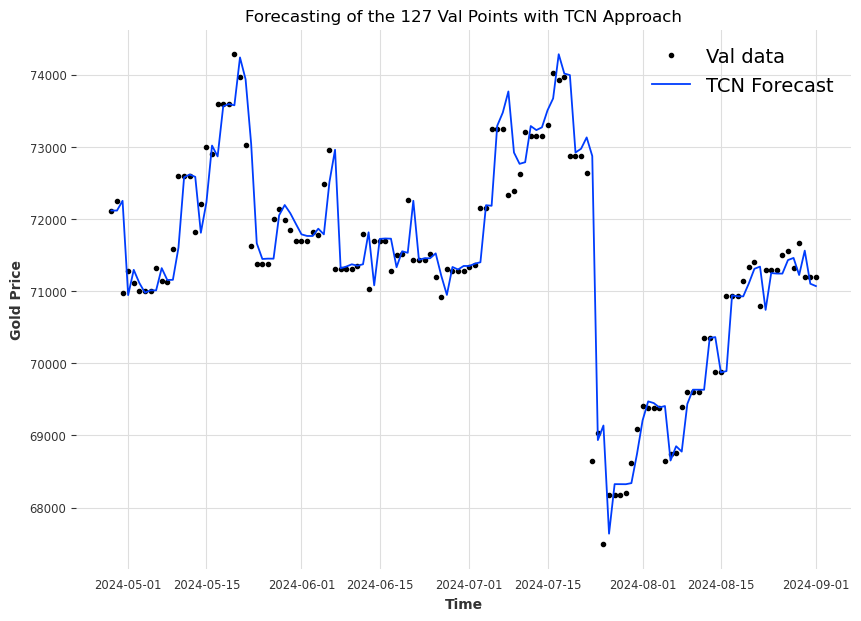

In [377]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tcn_es, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with TCN Approach')
plt.show()

In [378]:
tcn_metrics_es = evaluate_preds(y_true=y_val,
                            y_pred=preds_tcn_es)
tcn_metrics_es

{'mae': np.float32(342.01715),
 'mse': np.float32(367835.03),
 'rmse': np.float32(606.494),
 'mape': np.float32(0.48047927)}

##### Evaluate Overfitting

In [379]:
preds_holdout_train_tcn_es = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_tcn_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.25it/s]


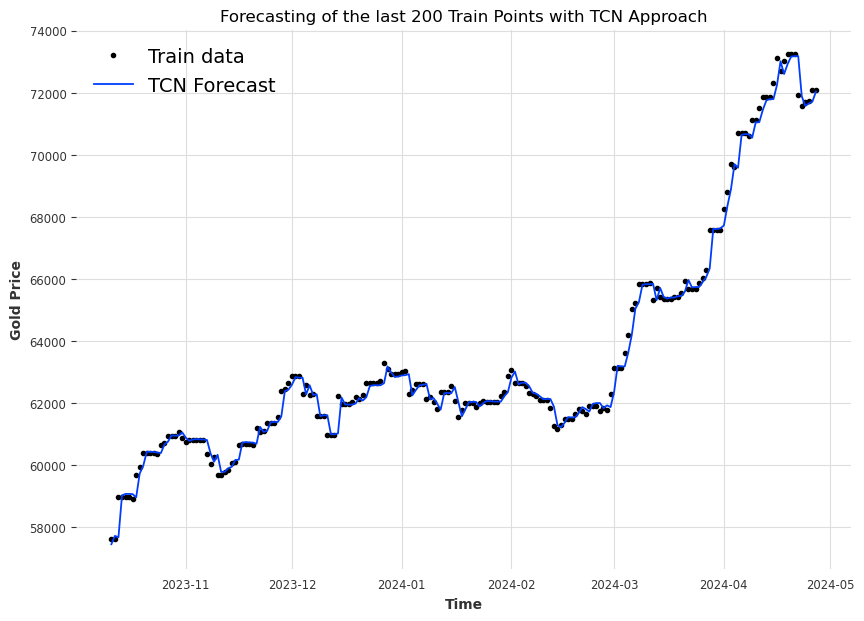

In [380]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tcn_es, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with TCN Approach')
plt.show()

In [381]:
tcn_train_metrics_es = evaluate_preds(y_pred=preds_holdout_train_tcn_es,
                                      y_true=y_train[-200:])
tcn_train_metrics_es

{'mae': np.float32(216.76588),
 'mse': np.float32(113372.44),
 'rmse': np.float32(336.70825),
 'mape': np.float32(0.33806747)}

##### Persist Metrics

In [382]:
df_models_metrics_tcn = pd.concat([
    df_models_metrics_tcn,
    pd.DataFrame([{
        "Model": model_tcn_es.name,  # aquí guardas el objeto completo
        "Train MAPE": tcn_train_metrics_es['mape'],
        "Val MAPE": tcn_metrics_es['mape'],
        "Train RMSE": tcn_train_metrics_es['rmse'],
        "Val RMSE": tcn_metrics_es['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [383]:
df_models_metrics_tcn

Model  Train MAPE  Val MAPE  Train RMSE  \
0                             Default Model    0.361206  0.499804  348.084839   
1                               Small Model    0.397388  0.558093  357.545380   
2                             Complex Model    0.415763  0.783855  379.634460   
3                        Less Complex Model    0.339564  0.808482  307.641541   
4                 Regularized Default Model    0.338067  0.480479  336.708252   
5  Early Stopping Regularized Default Model    0.338067  0.480479  336.708252   

     Val RMSE  
0  603.657715  
1  618.339722  
2  701.035034  
3  797.236572  
4  606.494019  
5  606.494019

In [384]:
model_tcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    kernel_size=3,
    num_filters=3,
    num_layers=None,
    dilation_base=2,
    weight_norm=False,
    dropout=0,
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_tcn.fit(gold_price_darts_scaled_train_val, past_covariates=gold_price_exogenus_darts_scaled_train_val)

Epoch 99: 100%|██████████| 121/121 [00:00<00:00, 123.26it/s, train_loss=3.05e-5] 


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

In [385]:
preds_tcn = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_tcn)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


In [386]:
tcn_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_tcn)
tcn_metrics

{'mae': np.float32(432.22122),
 'mse': np.float32(324178.53),
 'rmse': np.float32(569.36676),
 'mape': np.float32(0.5702152)}

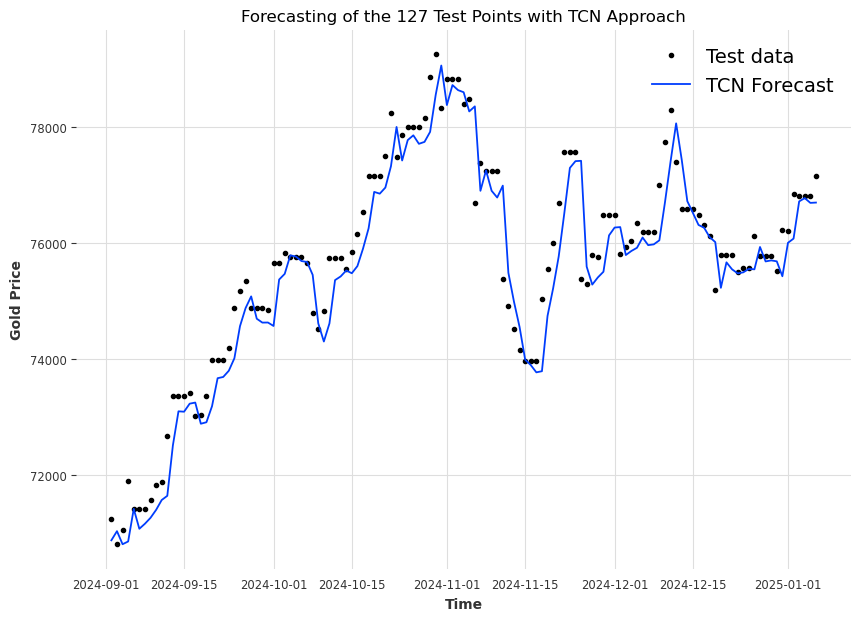

In [387]:
# Plot N-BEATSx forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_tcn, format='-', label='TCN Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with TCN Approach')
plt.show()

### vTRF (Vanilla Transformer)

In [388]:
from darts.models import TransformerModel

In [389]:
df_models_metrics_vtrf = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Default Model

##### Create Model

In [390]:
model_vtrf_default = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=64,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    dropout=0.1,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf_default.name = 'Default Model'

model_vtrf_default.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 99: 100%|██████████| 117/117 [00:02<00:00, 39.08it/s, train_loss=0.000308]


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [391]:
preds_vtrf_default = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.01it/s]


##### Evaluate Predictions

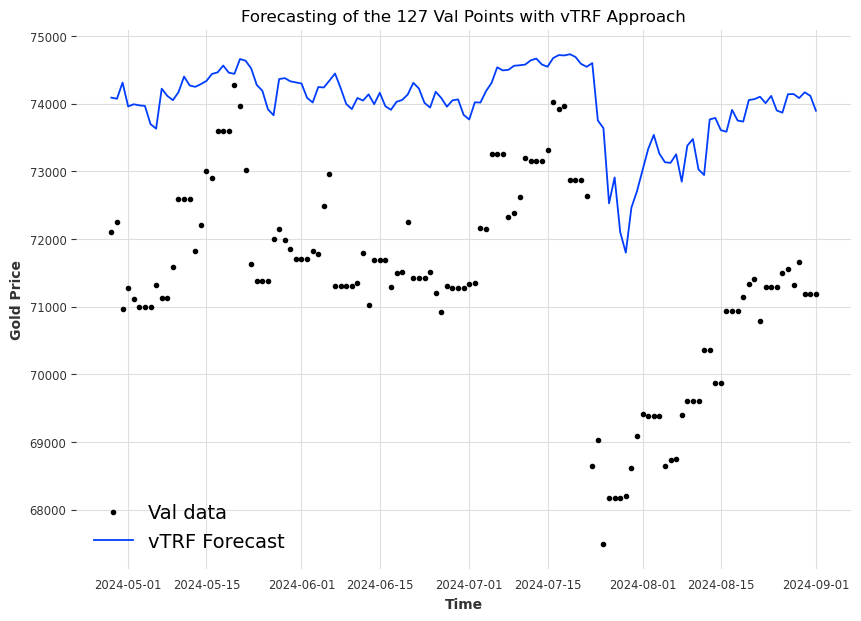

In [392]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf_default, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [393]:
vtrf_metrics_default = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf_default)
vtrf_metrics_default

{'mae': np.float32(2590.8062),
 'mse': np.float32(7724422.0),
 'rmse': np.float32(2779.2844),
 'mape': np.float32(3.6560786)}

##### Evaluate Overfitting

In [394]:
preds_holdout_train_vtrf_default = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.82it/s] 


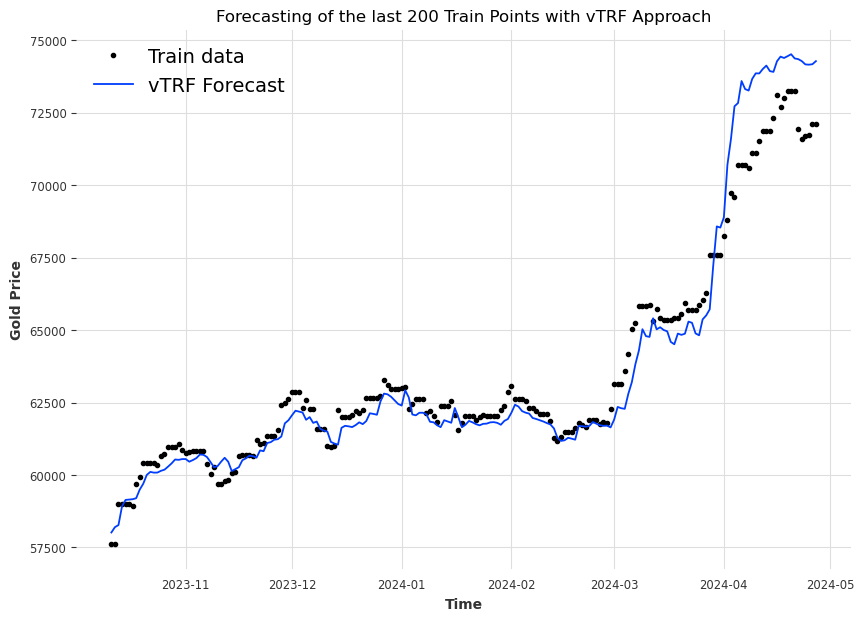

In [395]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf_default, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [396]:
vtrf_train_metrics_default = evaluate_preds(y_pred=preds_holdout_train_vtrf_default,
                                      y_true=y_train[-200:])
vtrf_train_metrics_default

{'mae': np.float32(669.59955),
 'mse': np.float32(906202.75),
 'rmse': np.float32(951.94684),
 'mape': np.float32(1.0114858)}

##### Persist Metrics

In [397]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf_default.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics_default['mape'],
        "Val MAPE": vtrf_metrics_default['mape'],
        "Train RMSE": vtrf_train_metrics_default['rmse'],
        "Val RMSE": vtrf_metrics_default['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11352\307829180.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Complex Model

##### Create Model

In [398]:
model_vtrf_complex = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=128,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=1024,
    dropout=0.2,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf_complex.name = 'Complex Model'

model_vtrf_complex.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 99: 100%|██████████| 117/117 [00:11<00:00,  9.91it/s, train_loss=0.0637]


TransformerModel(output_chunk_shift=0, d_model=128, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=1024, dropout=0.2, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [399]:
preds_vtrf_complex = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


##### Evaluate Predictions

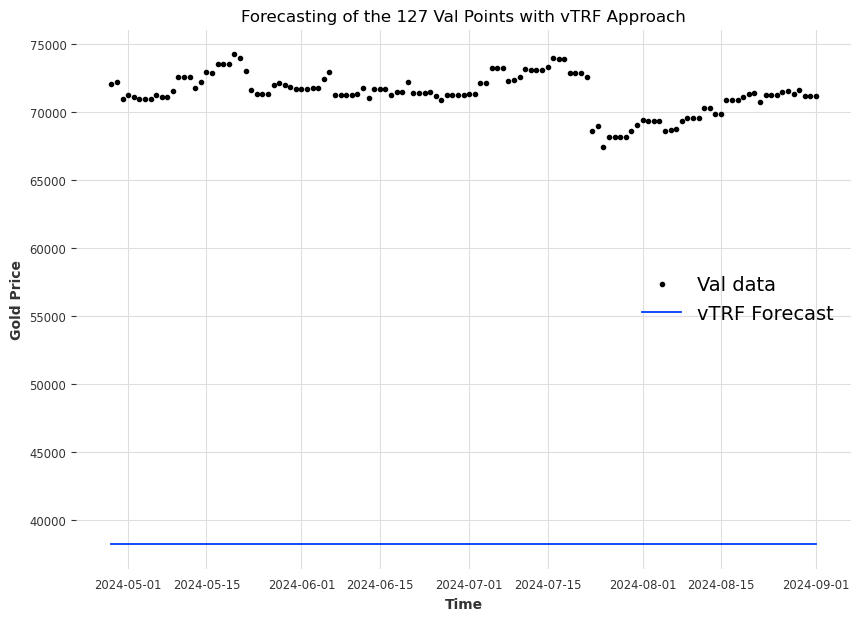

In [400]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf_complex, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [401]:
vtrf_metrics_complex = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf_complex)
vtrf_metrics_complex

{'mae': np.float32(33163.23),
 'mse': np.float32(1101793800.0),
 'rmse': np.float32(33193.28),
 'mape': np.float32(46.415215)}

##### Evaluate Overfitting

In [402]:
preds_holdout_train_vtrf_complex = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s]


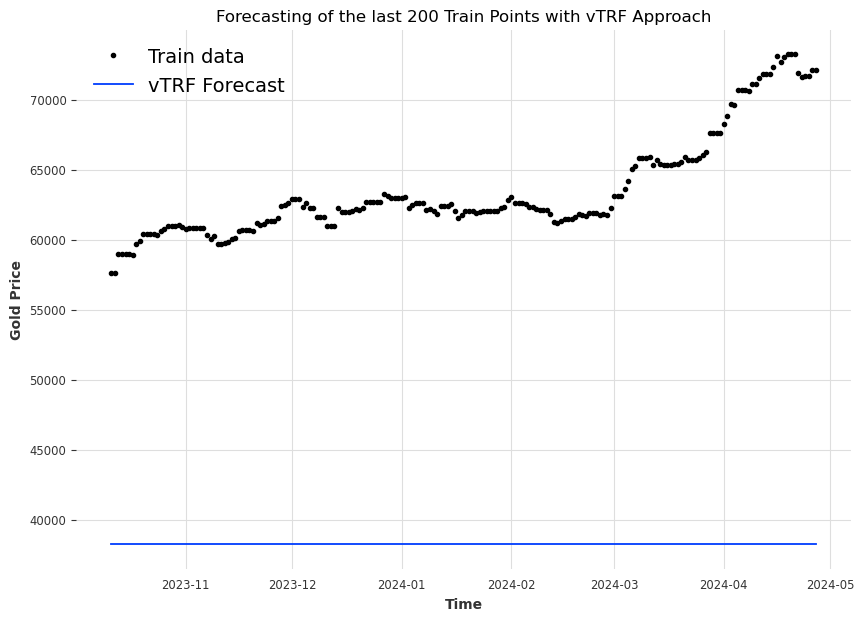

In [403]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf_complex, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [404]:
vtrf_train_metrics_complex = evaluate_preds(y_pred=preds_holdout_train_vtrf_complex,
                                      y_true=y_train[-200:])
vtrf_train_metrics_complex

{'mae': np.float32(25259.44),
 'mse': np.float32(651302500.0),
 'rmse': np.float32(25520.629),
 'mape': np.float32(39.585716)}

##### Persist Metrics

In [405]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf_complex.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics_complex['mape'],
        "Val MAPE": vtrf_metrics_complex['mape'],
        "Train RMSE": vtrf_train_metrics_complex['rmse'],
        "Val RMSE": vtrf_metrics_complex['rmse']
    }])
], ignore_index=True)

#### Small Model

##### Create Model

In [406]:
model_vtrf_small = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=32,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf_small.name = 'Small Model'

model_vtrf_small.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 99: 100%|██████████| 117/117 [00:02<00:00, 54.70it/s, train_loss=0.000159]


TransformerModel(output_chunk_shift=0, d_model=32, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [407]:
preds_vtrf_small = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]


##### Evaluate Predictions

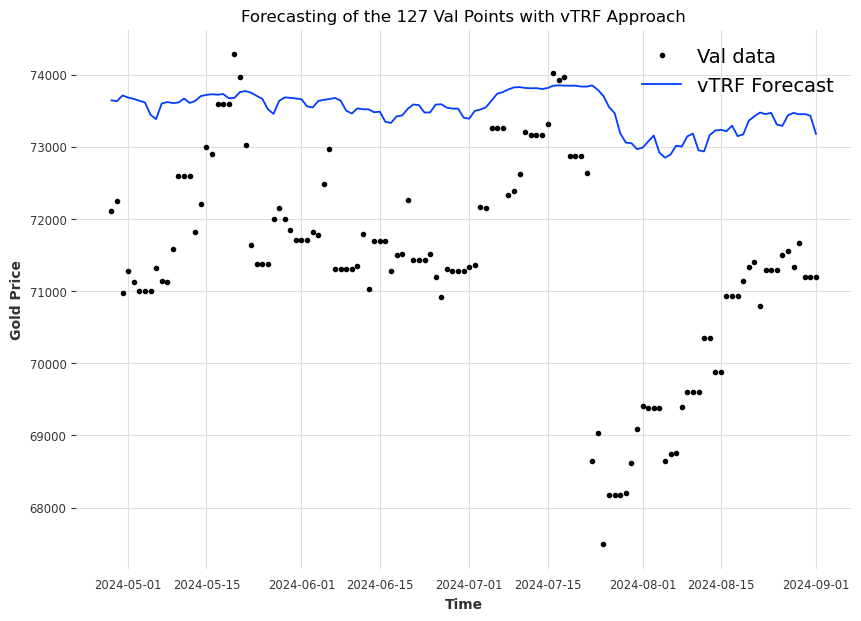

In [408]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf_small, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [409]:
vtrf_metrics_small = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf_small)
vtrf_metrics_small

{'mae': np.float32(2112.232),
 'mse': np.float32(5948564.0),
 'rmse': np.float32(2438.9678),
 'mape': np.float32(2.9925334)}

##### Evaluate Overfitting

In [410]:
preds_holdout_train_vtrf_small = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf_small)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.85it/s]


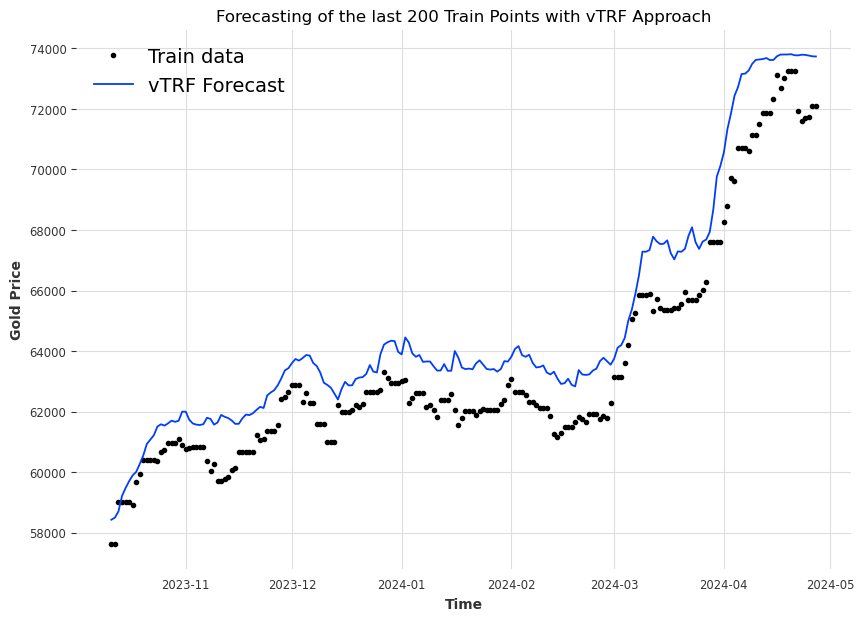

In [411]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf_small, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [412]:
vtrf_train_metrics_small = evaluate_preds(y_pred=preds_holdout_train_vtrf_small,
                                      y_true=y_train[-200:])
vtrf_train_metrics_small

{'mae': np.float32(1328.0288),
 'mse': np.float32(2070187.5),
 'rmse': np.float32(1438.8146),
 'mape': np.float32(2.0801501)}

##### Persist Metrics

In [413]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf_small.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics_small['mape'],
        "Val MAPE": vtrf_metrics_small['mape'],
        "Train RMSE": vtrf_train_metrics_small['rmse'],
        "Val RMSE": vtrf_metrics_small['rmse']
    }])
], ignore_index=True)

#### Smaller Model

##### Create Model

In [414]:
model_vtrf_smaller = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=16,
    nhead=2,
    num_encoder_layers=1,
    num_decoder_layers=1,
    dim_feedforward=128,
    dropout=0.1,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf_smaller.name = 'Smaller Model'

model_vtrf_smaller.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 99: 100%|██████████| 117/117 [00:01<00:00, 80.95it/s, train_loss=0.000281]


TransformerModel(output_chunk_shift=0, d_model=16, nhead=2, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [415]:
preds_vtrf_smaller = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf_smaller)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]


##### Evaluate Predictions

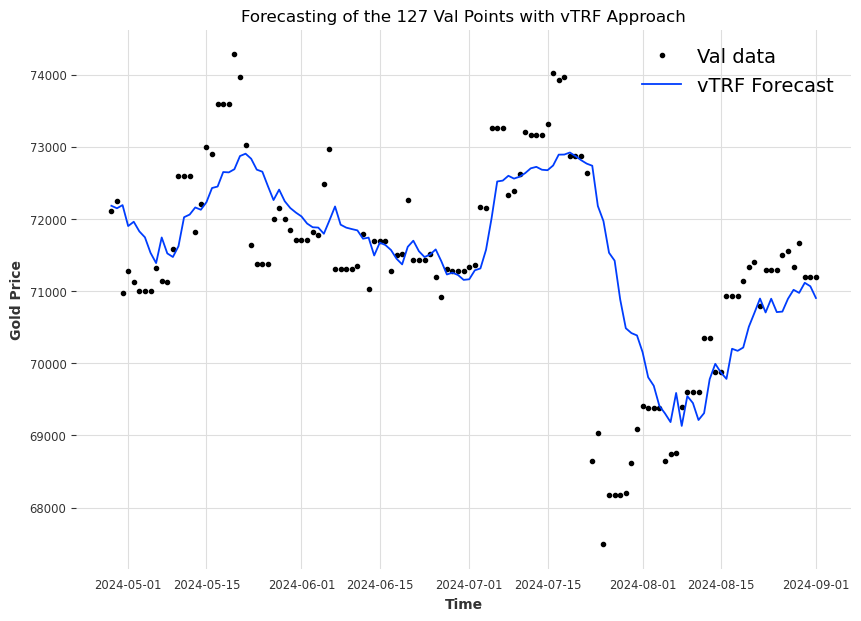

In [416]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf_smaller, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [417]:
vtrf_metrics_smaller = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf_smaller)
vtrf_metrics_smaller

{'mae': np.float32(666.12),
 'mse': np.float32(1036262.3),
 'rmse': np.float32(1017.9697),
 'mape': np.float32(0.9421441)}

##### Evaluate Overfitting

In [418]:
preds_holdout_train_vtrf_smaller = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf_smaller)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


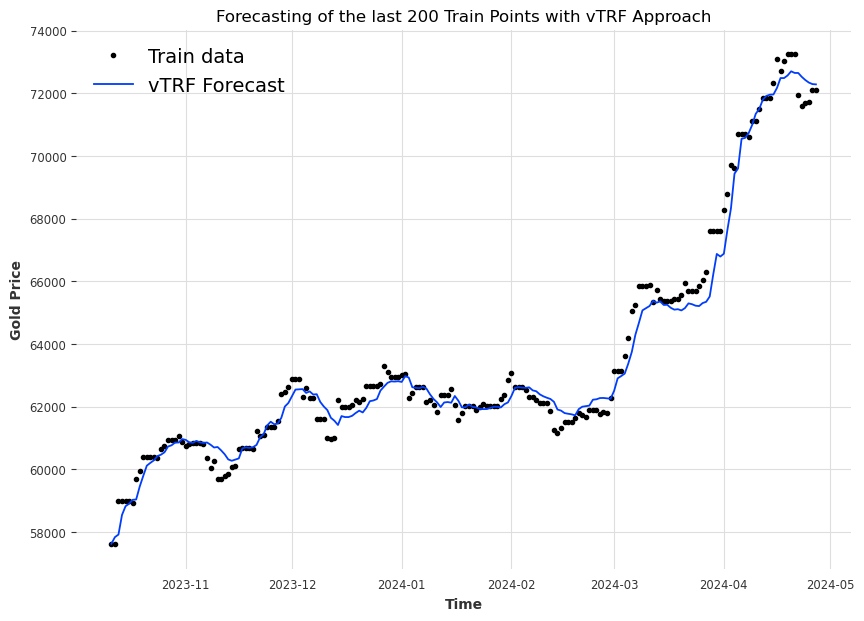

In [419]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf_smaller, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [420]:
vtrf_train_metrics_smaller = evaluate_preds(y_pred=preds_holdout_train_vtrf_smaller,
                                      y_true=y_train[-200:])
vtrf_train_metrics_smaller

{'mae': np.float32(376.513),
 'mse': np.float32(252441.42),
 'rmse': np.float32(502.4355),
 'mape': np.float32(0.5871655)}

##### Persist Metrics

In [421]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf_smaller.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics_smaller['mape'],
        "Val MAPE": vtrf_metrics_smaller['mape'],
        "Train RMSE": vtrf_train_metrics_smaller['rmse'],
        "Val RMSE": vtrf_metrics_smaller['rmse']
    }])
], ignore_index=True)

#### Mix Model

##### Create Model

In [422]:
model_vtrf_mix = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=64,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=512,
    dropout=0.2,
    activation='relu',
    n_epochs=100,
    batch_size=32,
    random_state=42
)

model_vtrf_mix.name = 'Mix Model'

model_vtrf_mix.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 99: 100%|██████████| 117/117 [00:02<00:00, 53.18it/s, train_loss=0.00045] 


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=512, dropout=0.2, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=100, batch_size=32, random_state=42)

##### Make Predictions

In [423]:
preds_vtrf_mix = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf_mix)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.36it/s]


##### Evaluate Predictions

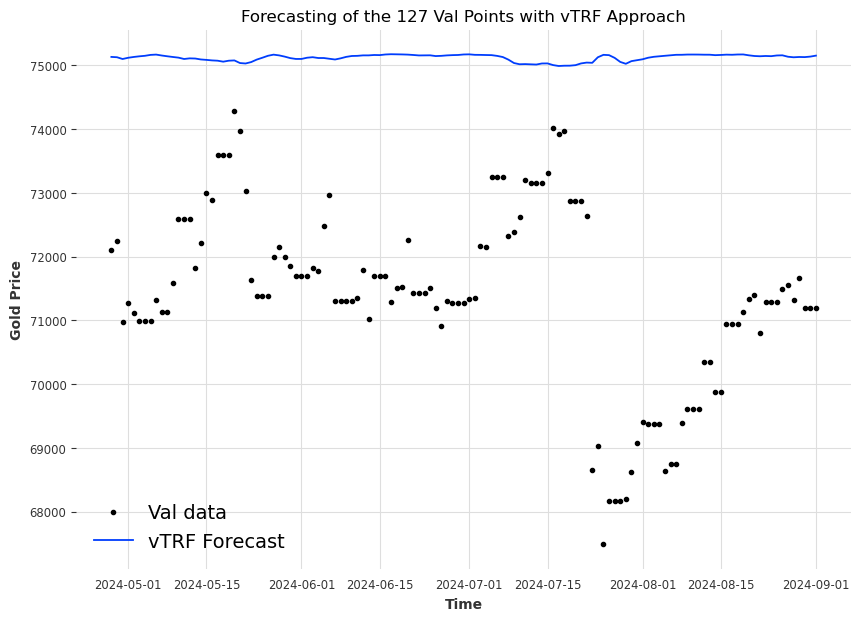

In [424]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf_mix, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [425]:
vtrf_metrics_mix = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf_mix)
vtrf_metrics_mix

{'mae': np.float32(3704.1306),
 'mse': np.float32(15776334.0),
 'rmse': np.float32(3971.9434),
 'mape': np.float32(5.2288237)}

##### Evaluate Overfitting

In [426]:
preds_holdout_train_vtrf_mix = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf_mix)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.02it/s]


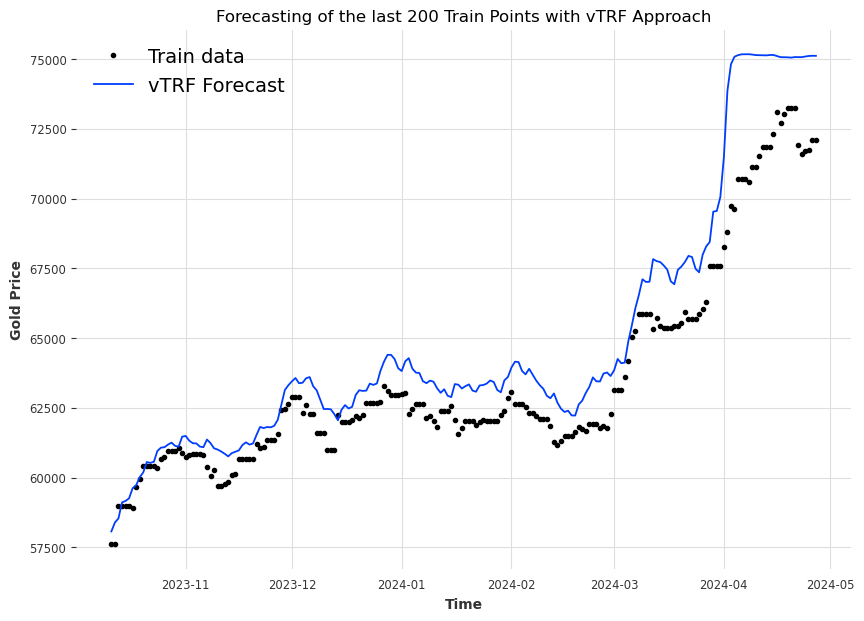

In [427]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf_mix, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [428]:
vtrf_train_metrics_mix = evaluate_preds(y_pred=preds_holdout_train_vtrf_mix,
                                      y_true=y_train[-200:])
vtrf_train_metrics_mix

{'mae': np.float32(1339.1935),
 'mse': np.float32(2882736.8),
 'rmse': np.float32(1697.8624),
 'mape': np.float32(2.0459924)}

##### Persist Metrics

In [429]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf_mix.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics_mix['mape'],
        "Val MAPE": vtrf_metrics_mix['mape'],
        "Train RMSE": vtrf_train_metrics_mix['rmse'],
        "Val RMSE": vtrf_metrics_mix['rmse']
    }])
], ignore_index=True)

#### Early Stopping Small Model

##### Create Model

In [430]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_vtrf_es = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=32,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    activation='relu',
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_vtrf_es.name = 'Early Stopping Small Model'

model_vtrf_es.fit(gold_price_darts_scaled_train, past_covariates=gold_price_exogenus_darts_scaled_train)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 57: 100%|██████████| 117/117 [00:02<00:00, 53.91it/s, train_loss=0.000636]


TransformerModel(output_chunk_shift=0, d_model=32, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000230A3B61AE0>]})

##### Make Predictions

In [431]:
preds_vtrf_es = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train,
                                                ts_test=gold_price_darts_scaled_val,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_val,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.56it/s]


##### Evaluate Predictions

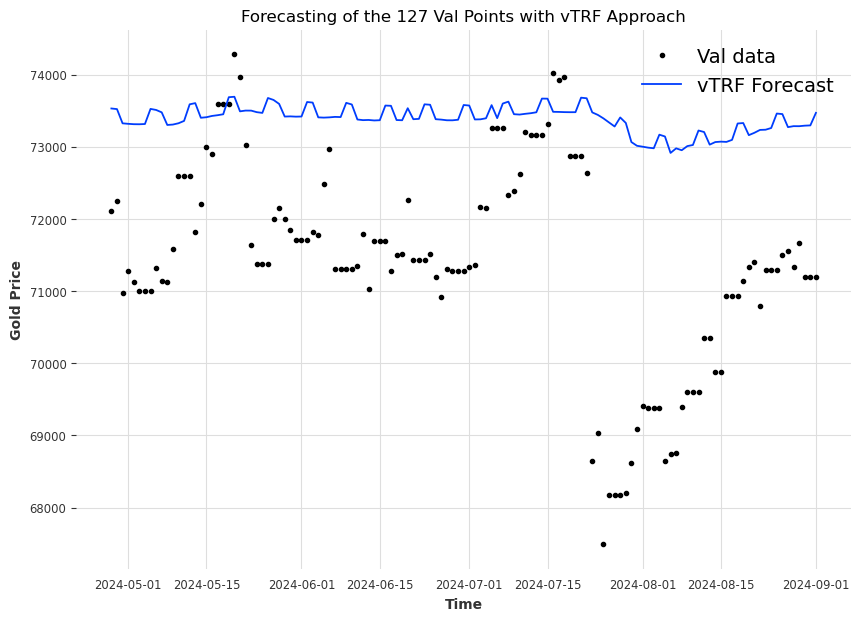

In [432]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_vtrf_es, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with vTRF Approach')
plt.show()

In [433]:
vtrf_metrics_es = evaluate_preds(y_true=y_val,
                            y_pred=preds_vtrf_es)
vtrf_metrics_es

{'mae': np.float32(2012.8237),
 'mse': np.float32(5581602.5),
 'rmse': np.float32(2362.5415),
 'mape': np.float32(2.853732)}

##### Evaluate Overfitting

In [434]:
preds_holdout_train_vtrf_es = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train[:-200],
                                                  ts_test=gold_price_darts_scaled_train[-200:],
                                                  ts_exogenus_train=gold_price_exogenus_darts_scaled_train[:-200],
                                                  ts_exogenus_test=gold_price_exogenus_darts_scaled_train[-200:],
                                                  scaled=True,
                                                  scaler=scaler,
                                                  model=model_vtrf_es)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.84it/s] 


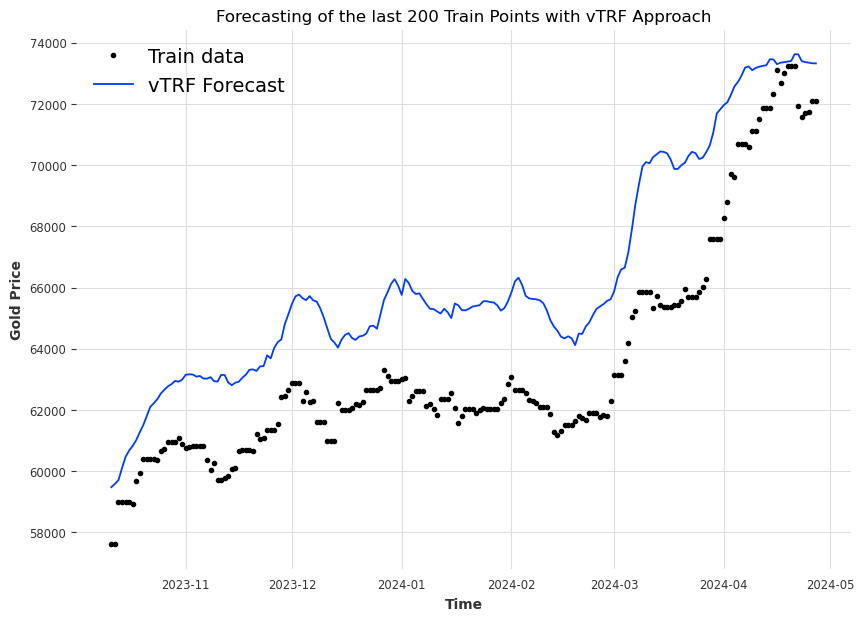

In [435]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_vtrf_es, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with vTRF Approach')
plt.show()

In [436]:
vtrf_train_metrics_es = evaluate_preds(y_pred=preds_holdout_train_vtrf_es,
                                      y_true=y_train[-200:])
vtrf_train_metrics_es

{'mae': np.float32(2807.3),
 'mse': np.float32(8827062.0),
 'rmse': np.float32(2971.037),
 'mape': np.float32(4.445491)}

##### Persist Metrics

In [437]:
df_models_metrics_vtrf = pd.concat([
    df_models_metrics_vtrf,
    pd.DataFrame([{
        "Model": model_vtrf_es.name,  # aquí guardas el objeto completo
        "Train MAPE": vtrf_train_metrics_es['mape'],
        "Val MAPE": vtrf_metrics_es['mape'],
        "Train RMSE": vtrf_train_metrics_es['rmse'],
        "Val RMSE": vtrf_metrics_es['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [438]:
df_models_metrics_vtrf

Model  Train MAPE   Val MAPE    Train RMSE  \
0               Default Model    1.011486   3.656079    951.946838   
1               Complex Model   39.585716  46.415215  25520.628906   
2                 Small Model    2.080150   2.992533   1438.814575   
3               Smaller Model    0.587165   0.942144    502.435486   
4                   Mix Model    2.045992   5.228824   1697.862427   
5  Early Stopping Small Model    4.445491   2.853732   2971.037109   

       Val RMSE  
0   2779.284424  
1  33193.281250  
2   2438.967773  
3   1017.969727  
4   3971.943359  
5   2362.541504

In [439]:
early_stopper = EarlyStopping(
    monitor="train_loss",
    patience=20,
    mode="min"
)

model_vtrf = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    output_chunk_shift=0,
    d_model=32,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    activation='relu',
    n_epochs=1000,
    batch_size=32,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [early_stopper]}
)

model_vtrf.fit(gold_price_darts_scaled_train_val, past_covariates=gold_price_exogenus_darts_scaled_train_val)

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



Epoch 196: 100%|██████████| 121/121 [00:07<00:00, 16.89it/s, train_loss=7.19e-5] 


TransformerModel(output_chunk_shift=0, d_model=32, nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, n_epochs=1000, batch_size=32, random_state=42, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000002309D9D8460>]})

In [440]:
preds_vtrf = make_predictions_rolling_one_past_covariates_darts(ts_train=gold_price_darts_scaled_train_val,
                                                ts_test=gold_price_darts_scaled_test,
                                                ts_exogenus_train=gold_price_exogenus_darts_scaled_train_val,
                                                ts_exogenus_test=gold_price_exogenus_darts_scaled_test,
                                                scaled=True,
                                                scaler=scaler,
                                                model=model_vtrf)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.29it/s]


In [441]:
vtrf_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_vtrf)
vtrf_metrics

{'mae': np.float32(2937.672),
 'mse': np.float32(10487513.0),
 'rmse': np.float32(3238.4429),
 'mape': np.float32(3.841595)}

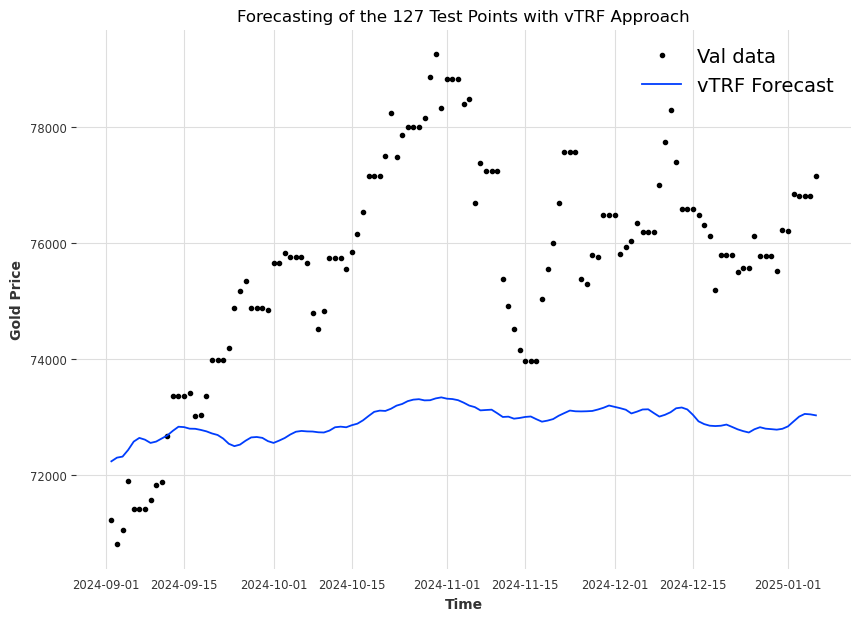

In [442]:
# Plot vTRF forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_test, values=preds_vtrf, format='-', label='vTRF Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Test Points with vTRF Approach')
plt.show()

### PatchTST

In [443]:
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST

from utils.preds import make_predictions_rolling_one_nf

In [444]:
df_models_metrics_tst = pd.DataFrame(columns=["Model", "Train MAPE", "Val MAPE", "Train RMSE", "Val RMSE"])

#### Prepare the Data for NeuralForecasting

In [445]:
gold_price_nf = gold_price.reset_index().rename(columns={'index':'ds', 'Price':'y'})
gold_price_nf['unique_id'] = 'gold'
cols = ['unique_id', 'ds', 'y'] + [c for c in gold_price_nf.columns if c not in ['unique_id', 'ds', 'y']]
gold_price_nf = gold_price_nf[cols]
gold_price_nf.head(2)

unique_id         ds        y  is_holiday  days_to_next_holiday  is_weekend  \
0      gold 2014-01-01  29542.0           1                     0           0   
1      gold 2014-01-02  29975.0           0                    18           0   

    brent    wti    dxy    vix   eurusd        sp500  t5yie  
0  107.94  95.14  80.21  14.32  1.37553  1845.859985   1.71  
1  107.94  95.14  80.12  14.32  1.37653  1845.859985   1.71

In [446]:
gold_price_nf_train = gold_price_nf.iloc[:2*split_size, :]
gold_price_nf_val = gold_price_nf.iloc[2*split_size:split_size, :]
gold_price_nf_train_val = gold_price_nf.iloc[:split_size, :]
gold_price_nf_test = gold_price_nf.iloc[split_size:, :]

In [447]:
gold_price_nf_exogenus_val = gold_price_nf_val.drop(columns=['y'])
gold_price_nf_exogenus_test = gold_price_nf_test.drop(columns=['y'])

#### Default Model

##### Create Model

In [448]:
patch = PatchTST(
    h=1,
    input_size=30,
    encoder_layers=3,
    n_heads=16,
    hidden_size=128,
    linear_hidden_size=256,
    dropout=0.2,
    fc_dropout=0.2,
    head_dropout=0,
    attn_dropout=0,
    patch_len=16,
    stride=8,
    revin=True,
    revin_affine=False,
    revin_subtract_last=True,
    activation='gelu',
    res_attention=True,
    batch_normalization=False,
    learn_pos_embed= True,
    max_steps=5000,
    learning_rate=0.0001,
    num_lr_decays=-1,
    early_stop_patience_steps=-1,
    val_check_steps=100,
    batch_size=32,
    windows_batch_size=1024,
    inference_windows_batch_size=1024,
    start_padding_enabled=False,
    step_size=1,
    scaler_type='standard',
    random_seed=42,
    drop_last_loader=False
)

model_tst_default = NeuralForecast(
    models=[patch],
    freq='D'
)

model_tst_default.name = 'Default Model'

model_tst_default.fit(df=gold_price_nf_train)

Seed set to 42


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s, v_num=949, train_loss_step=0.225, train_loss_epoch=0.225]


##### Make Predictions

In [449]:
preds_tst_default = make_predictions_rolling_one_nf(train_df=gold_price_nf_train,
                                test_exog_df=gold_price_nf_exogenus_val,
                                length_prediction=-split_size,
                                y_true=y_val,
                                model=model_tst_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.67it/s]


##### Evaluate Predictions

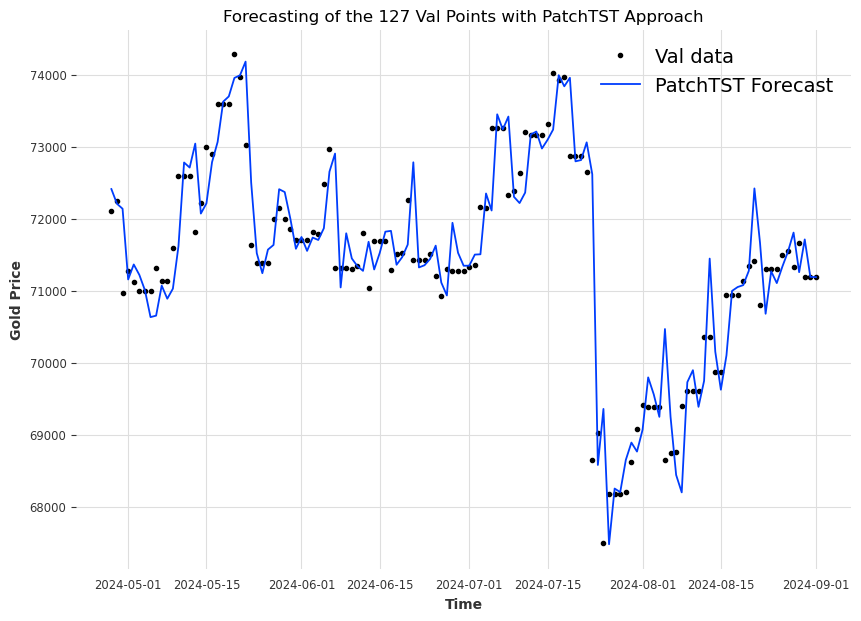

In [450]:
# Plot PatchTST forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tst_default, format='-', label='PatchTST Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with PatchTST Approach')
plt.show()

In [451]:
tst_metrics_default = evaluate_preds(y_true=y_val,
                            y_pred=preds_tst_default)
tst_metrics_default

{'mae': np.float32(410.3621),
 'mse': np.float32(421479.44),
 'rmse': np.float32(649.2145),
 'mape': np.float32(0.5781104)}

##### Evaluate Overfitting

In [452]:
preds_holdout_train_tst_default = make_predictions_rolling_one_nf(train_df=gold_price_nf_train.iloc[:-200, :],
                                                          test_exog_df=gold_price_nf_train.iloc[-200:, :].drop(columns='y'),
                                                          length_prediction=200,
                                                          y_true=gold_price_nf_train.iloc[-200:, 2].values,
                                                          model=model_tst_default)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.15it/s]


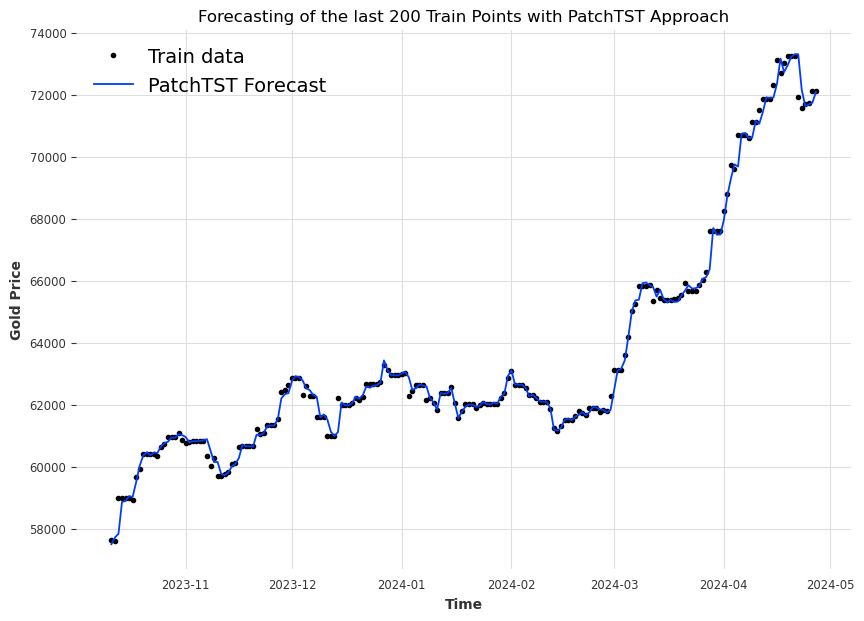

In [453]:
# Plot PatchTST forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tst_default, format='-', label='PatchTST Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with PatchTST Approach')
plt.show()

In [454]:
tst_train_metrics_default = evaluate_preds(y_pred=preds_holdout_train_tst_default,
                                      y_true=y_train[-200:])
tst_train_metrics_default

{'mae': np.float32(135.35274),
 'mse': np.float32(69752.69),
 'rmse': np.float32(264.10733),
 'mape': np.float32(0.20842241)}

##### Persist Metrics

In [455]:
df_models_metrics_tst = pd.concat([
    df_models_metrics_tst,
    pd.DataFrame([{
        "Model": model_tst_default.name,  # aquí guardas el objeto completo
        "Train MAPE": tst_train_metrics_default['mape'],
        "Val MAPE": tst_metrics_default['mape'],
        "Train RMSE": tst_train_metrics_default['rmse'],
        "Val RMSE": tst_metrics_default['rmse']
    }])
], ignore_index=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11352\3990072237.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



#### Complex Model

##### Create Model

In [456]:
patch = PatchTST(
    h=1,
    input_size=60,
    encoder_layers=6,
    n_heads=32,
    hidden_size=256,
    linear_hidden_size=512,
    dropout=0.3,
    fc_dropout=0.3,
    head_dropout=0.1,
    attn_dropout=0.1,
    patch_len=32,
    stride=16,
    revin=True,
    revin_affine=True,
    revin_subtract_last=True,
    activation='gelu',
    res_attention=True,
    batch_normalization=True,
    learn_pos_embed= True,
    max_steps=10000,
    learning_rate=0.00005,
    num_lr_decays=2,
    early_stop_patience_steps=-1,
    val_check_steps=50,
    batch_size=64,
    windows_batch_size=2048,
    inference_windows_batch_size=2048,
    start_padding_enabled=True,
    step_size=1,
    scaler_type='standard',
    random_seed=42,
    drop_last_loader=False
)

model_tst_complex = NeuralForecast(
    models=[patch],
    freq='D'
)

model_tst_complex.name = 'Complex Model'

model_tst_complex.fit(df=gold_price_nf_train)

Seed set to 42


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s, v_num=1277, train_loss_step=0.300, train_loss_epoch=0.300]


##### Make Predictions

In [457]:
preds_tst_complex = make_predictions_rolling_one_nf(train_df=gold_price_nf_train,
                                test_exog_df=gold_price_nf_exogenus_val,
                                length_prediction=-split_size,
                                y_true=y_val,
                                model=model_tst_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.49it/s]


##### Evaluate Predictions

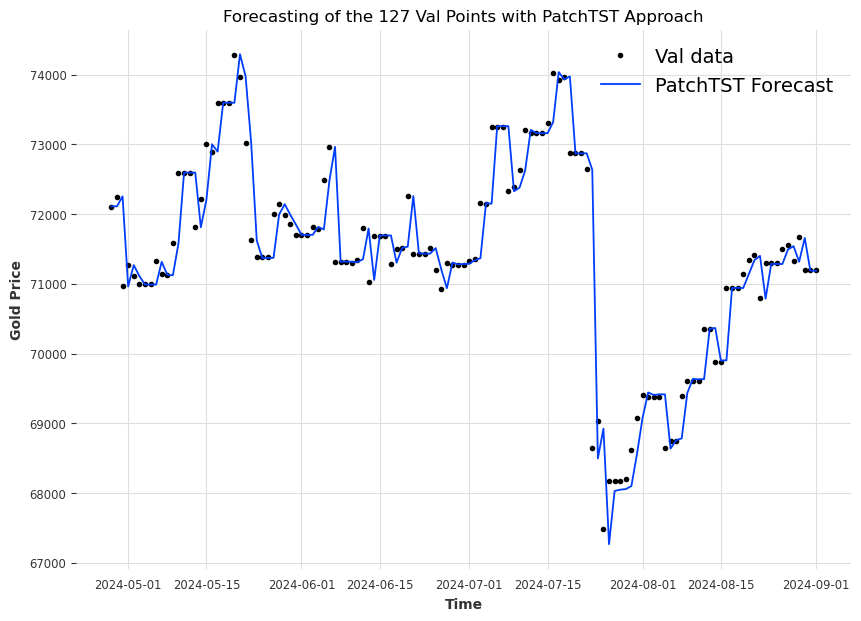

In [458]:
# Plot PatchTST forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val, values=y_val, label="Val data", start=0, end=-split_size)
plot_time_series(timesteps=X_val, values=preds_tst_complex, format='-', label='PatchTST Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=-split_size)
plt.title(f'Forecasting of the {-split_size} Val Points with PatchTST Approach')
plt.show()

In [459]:
tst_metrics_complex = evaluate_preds(y_true=y_val,
                            y_pred=preds_tst_complex)
tst_metrics_complex

{'mae': np.float32(328.14438),
 'mse': np.float32(347578.12),
 'rmse': np.float32(589.55756),
 'mape': np.float32(0.46160376)}

##### Evaluate Overfitting

In [460]:
preds_holdout_train_tst_complex = make_predictions_rolling_one_nf(train_df=gold_price_nf_train.iloc[:-200, :],
                                                          test_exog_df=gold_price_nf_train.iloc[-200:, :].drop(columns='y'),
                                                          length_prediction=200,
                                                          y_true=gold_price_nf_train.iloc[-200:, 2].values,
                                                          model=model_tst_complex)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.98it/s] 


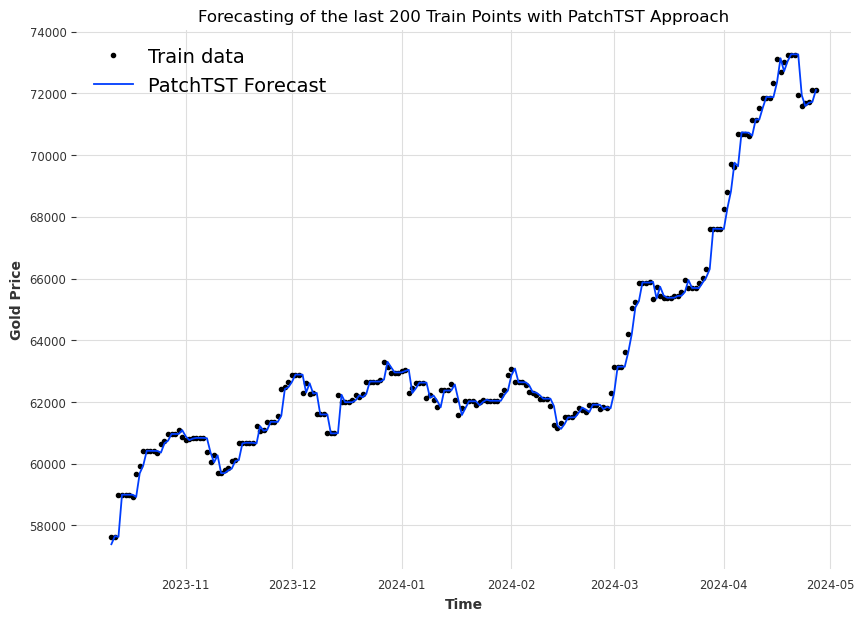

In [461]:
# Plot PatchTST forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-200:], values=y_train[-200:], label="Train data")
plot_time_series(timesteps=X_train[-200:], values=preds_holdout_train_tst_complex, format='-', label='PatchTST Forecast', xlabel='Time', ylabel='Gold Price')
plt.title('Forecasting of the last 200 Train Points with PatchTST Approach')
plt.show()

In [462]:
tst_train_metrics_complex = evaluate_preds(y_pred=preds_holdout_train_tst_complex,
                                      y_true=y_train[-200:])
tst_train_metrics_complex

{'mae': np.float32(207.81573),
 'mse': np.float32(117379.43),
 'rmse': np.float32(342.6068),
 'mape': np.float32(0.3242274)}

##### Persist Metrics

In [463]:
df_models_metrics_tst = pd.concat([
    df_models_metrics_tst,
    pd.DataFrame([{
        "Model": model_tst_complex.name,  # aquí guardas el objeto completo
        "Train MAPE": tst_train_metrics_complex['mape'],
        "Val MAPE": tst_metrics_complex['mape'],
        "Train RMSE": tst_train_metrics_complex['rmse'],
        "Val RMSE": tst_metrics_complex['rmse']
    }])
], ignore_index=True)

#### Final Model and Metrics

In [464]:
df_models_metrics_tst

Model  Train MAPE  Val MAPE  Train RMSE    Val RMSE
0  Default Model    0.208422  0.578110  264.107330  649.214478
1  Complex Model    0.324227  0.461604  342.606812  589.557556

In [465]:
patch = PatchTST(
    h=1,
    input_size=60,
    encoder_layers=6,
    n_heads=32,
    hidden_size=256,
    linear_hidden_size=512,
    dropout=0.3,
    fc_dropout=0.3,
    head_dropout=0.1,
    attn_dropout=0.1,
    patch_len=32,
    stride=16,
    revin=True,
    revin_affine=True,
    revin_subtract_last=True,
    activation='gelu',
    res_attention=True,
    batch_normalization=True,
    learn_pos_embed= True,
    max_steps=10000,
    learning_rate=0.00005,
    num_lr_decays=2,
    early_stop_patience_steps=-1,
    val_check_steps=50,
    batch_size=64,
    windows_batch_size=2048,
    inference_windows_batch_size=2048,
    start_padding_enabled=True,
    step_size=1,
    scaler_type='standard',
    random_seed=42,
    drop_last_loader=False
)

model_tst = NeuralForecast(
    models=[patch],
    freq='D'
)

model_tst.fit(df=gold_price_nf_train_val)

Seed set to 42


Epoch 9999: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s, v_num=1605, train_loss_step=0.342, train_loss_epoch=0.342]


In [466]:
preds_tst = make_predictions_rolling_one_nf(train_df=gold_price_nf_train_val,
                                test_exog_df=gold_price_nf_exogenus_test,
                                length_prediction=-split_size,
                                y_true=y_test,
                                model=model_tst)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.13it/s]


In [467]:
tst_metrics = evaluate_preds(y_true=y_test,
                            y_pred=preds_tst)
tst_metrics

{'mae': np.float32(333.28302),
 'mse': np.float32(261029.9),
 'rmse': np.float32(510.91086),
 'mape': np.float32(0.43974185)}

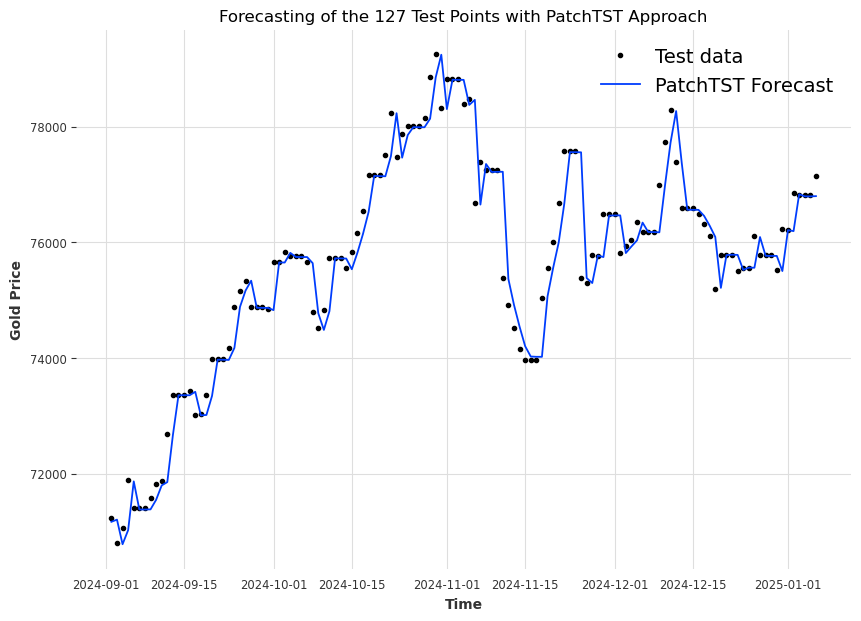

In [468]:
# Plot PatchTST forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test, values=preds_tst, format='-', label='PatchTST Forecast', xlabel='Time', ylabel='Gold Price')
plt.title(f'Forecasting of the {-split_size} Test Points with PatchTST Approach')
plt.show()